In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import geopandas as gp
import shapely
import fiona

shp_file_name = "NSW_LOCALITY_POLYGON_shp/NSW_LOCALITY_POLYGON_shp.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = ("https://data.gov.au/dataset/91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
                 "5e295412-357c-49a2-98d5-6caf099c2339/download/nsw_locality_polygon_shp.zip")

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
import matplotlib.style as style
style.available
style.use('fivethirtyeight')

# Setting up notebook
> Importing plotting styles and maps data for plotting.


In [4]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [5]:
# unzipping the file
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [6]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.columns
burbs.sample(3)

LC_PLY_PID   DT_CREATE DT_RETIRE  LOC_PID  NSW_LOCALI NSW_LOCA_1  \
335       19906  2012-11-21      None   NSW436  2013-01-23       None   
362       11701  2010-02-18      None  NSW2512  2012-02-04       None   
3991      26393  2016-06-07      None   NSW210  2016-08-08       None   

     NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
335        BOCO       None       None          G       None          1   
362     MARINNA       None       None          G       None          1   
3991   BARRATTA       None       None          G       None          1   

                                               geometry  
335   POLYGON ((149.185372627979 -36.5738734482544, ...  
362   POLYGON ((147.644042872492 -34.7616757091709, ...  
3991  POLYGON ((144.39898580816 -35.04505432494, 144...

In [7]:
saved_style_state = matplotlib.rcParams.copy()

# Importing Airbnb Dataset
> Imported Dataset of listings from 10 July, 2019.

In [8]:
air_bnb = pd.read_csv("listings.csv")
# , dtype={'user_id': int}

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# how many rows and columns are in the airbnb dataset?
air_bnb.shape

(38080, 106)

In [10]:
# all the names of the columns
air_bnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [11]:
# display all 106 columns 
pd.set_option('display.max_columns', 106)

### Tidying Up Dataset
> Using user-defined functions to tidy up elements in columns. 

In [12]:
def float_str_to_int(str1):
    try:
        a = str(str1)
        a = a.strip( '.00' )
        a = a.strip('$')
        a = ''.join(a.split(','))
        if str1 == "$0.00":
            return 0
    #     a = a.strip(' ')
        return int(a.strip(' '))
    except Exception as e:
        print(e)
        import pdb; pdb.set_trace()
        return str1
#     return int(float(a))

In [13]:
def remove(str1):
    a = str(str1)
    a = a.strip( 'NSW' )
    a = a.strip('.0')
    a = a.split('\n')
    if a == "nan":
        return a 
    return a

In [14]:
def simplify_postcodes(row):
    z = row.zipcode
    if type(z) is str:
        if "NSW " in z:
            return z[4:]
        else:
            return z
    elif type(z) is float and not np.isnan(z):
        return str(int(z))
    else:
        return "0000"

air_bnb["simple_postcode"] = air_bnb.apply(simplify_postcodes,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
24680  26244400  https://www.airbnb.com/rooms/26244400  20190710033517   
954     1971046   https://www.airbnb.com/rooms/1971046  20190710033517   
24974  26609082  https://www.airbnb.com/rooms/26609082  20190710033517   
1850    3814806   https://www.airbnb.com/rooms/3814806  20190710033517   
22480  23779491  https://www.airbnb.com/rooms/23779491  20190710033517   

      last_scraped                                              name  \
24680   2019-07-10                                        Cozy home!   
954     2019-07-10               Harbour & city views - Little Manly   
24974   2019-07-10                  Little Albion Guest House - Cosy   
1850    2019-07-10                Bondi-Park side 2 storey House 3br   
22480   2019-07-10  HAMPTONS HAVEN-hosted by: L'Abode Accommodation.   

                                                 summary  \
24680  My house is 5 minutes walking from the market ...   
954    Lovely 2 bedroom apartment located on the elev...   
24974                                                NaN   
1850   Available  Saturday 13 December  2014  through...   
22480  Coastal Escape near Clovelly Beach If you’re a...   

                                                   space  \
24680                                                NaN   
954    Check out my photos - the apartment is EXACTLY...   
24974  The House Delightfully intimate, devastatingly...   
1850   AVAILABLE FROM 13 DECEMB (Phone number hidden ...   
22480  WHAT WE LOVE  Make the most of the Sydney suns...   

                                             description experiences_offered  \
24680  My house is 5 minutes walking from the market ...                none   
954    Lovely 2 bedroom apartment located on the elev...                none   
24974  The House Delightfully intimate, devastatingly...                none   
1850   Available  Saturday 13 December (Phone number ...                none   
22480  Coastal Escape near Clovelly Beach If you’re a...                none   

                                   neighborhood_overview  \
24680                                                NaN   
954    Only a short stroll to Little Manly beach wher...   
24974  Surry Hills is a vibrant up and coming neighbo...   
1850   Family neighbourhood, with young families surr...   
22480                                                NaN   

                                                   notes  \
24680                                                NaN   
954    Minimum 5 night stay expect xmas and New year ...   
24974                                                NaN   
1850    The home is light, bright, airy and comfortable.   
22480  TOP 3 THINGS TO DO Snorkel sessions at Clovell...   

                                                 transit  \
24680                                                NaN   
954    Manly Council has a FREE hop skip and jump bus...   
24974                                                NaN   
1850   You cannot get a better central location, whet...   
22480                                                NaN   

                                                  access  \
24680                                                NaN   
954    Private balcony with sweeping views of Sydney ...   
24974  As a guest at the Little Albion Guest House yo...   
1850   LOCATION, LOCATION, LOCATION  Bondi Beach, Tam...   
22480                                                NaN   

                                             interaction  \
24680                                                NaN   
954    I am available via email and phone should you ...   
24974                     24 hour host service available   
1850   Interaction with Guests There is an onsite car...   
22480                                                NaN   

                                             house_rules  thumbnail_url  \
24680  Keep the share areas clean.  Entrance and bat

In [15]:
def clean_up_simple_postcode(row):
    k = row.simple_postcode
    if type(k) is str:
        if "\n2766" in k:
            return k[:4]
        else:
            return k
    else:
        return k

air_bnb["simple_postcode"] = air_bnb.apply(clean_up_simple_postcode,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
1422    2811001   https://www.airbnb.com/rooms/2811001  20190710033517   
37211  36002224  https://www.airbnb.com/rooms/36002224  20190710033517   
36681  35637124  https://www.airbnb.com/rooms/35637124  20190710033517   
31504  31501529  https://www.airbnb.com/rooms/31501529  20190710033517   
6778    9825894   https://www.airbnb.com/rooms/9825894  20190710033517   

      last_scraped                                             name  \
1422    2019-07-10                     Short walk to Sydney Central   
37211   2019-07-10  Private  Bedroom sea views hot tub and fire pit   
36681   2019-07-11                                      Beach house   
31504   2019-07-10    3 Br Executive Apartment Heart of the Central   
6778    2019-07-10   Rhodes: 2brm apartment, 2 bathrooms, pool, gym   

                                                 summary  \
1422   Really comfortable 1 bedroom apartment in a fa...   
37211  Hi, We have a private room to rent in our 3 be...   
36681  There is a complex of 4 year old house which h...   
31504  This Incredible apartment located in the heart...   
6778   Stay in this modern 2brm apartment with top fa...   

                                                   space  \
1422   Central, comfortable, fully self-contained apa...   
37211                                                NaN   
36681                                                NaN   
31504  This apartment is fully equipped with everythi...   
6778   Two bedrooms, a bunk bed, Aircon in every room...   

                                             description experiences_offered  \
1422   Really comfortable 1 bedroom apartment in a fa...                none   
37211  Hi, We have a private room to rent in our 3 be...                none   
36681  There is a complex of 4 year old house which h...                none   
31504  This Incredible apartment located in the heart...                none   
6778   Stay in this modern 2brm apartment with top fa...                none   

                                   neighborhood_overview  \
1422   Surry Hills and Darlinghurst is a vibrant spot...   
37211                                                NaN   
36681                                                NaN   
31504  Darling Harbour - 5 mins walk ICC - 7 mins wal...   
6778   Rhodes train station less than 10 mins easy wa...   

                                                   notes  \
1422   Only the guests approved for the booking are p...   
37211                                                NaN   
36681                                                NaN   
31504                                                NaN   
6778   Great coffee machine tennis,swimming,restauran...   

                                                 transit  \
1422   You won't need a car but an undercover car par...   
37211                                                NaN   
36681                                                NaN   
31504  Short walk to China Town, Darling Harbour, tra...   
6778                                      Train or ferry   

                                                  access  \
1422   Entire apartment with lift, car park, security...   
37211                                                NaN   
36681                                                NaN   
31504  you will have 2 sets of the key for you whole ...   
6778   Security door, three flights of stairs, Key pr...   

                                             interaction  \
1422   I will always try to meet you at checkin and g...   
37211                                                NaN   
36681                                                NaN   
31504                  I will be onsite if guest needed.   
6778            Available for queries any time on phone.   

                                             house_rules  thumbnail_url  \
1422   Please no pets, no children, no smoking and no...  

In [16]:
# def convert_to_integer_for_price(row):
#     x = row.price
#     if type(x) is str:
#         if type(x) is float:
#             new_x = float(x)
#             return new_x 
#         return float(x)
#     return float(x)
# air_bnb["price"] = air_bnb.apply(convert_to_integer_for_price,axis=1)
# air_bnb.sample(5)

In [17]:
def simplify_host_response(row):
    y = row.host_response_rate
    if type(y) is str:
        no_p = y.strip('%')
        return no_p
    elif type(y) is float and not np.isnan(y):
        no_p = y.strip('%')
        return str(int(no_p))
    else:
        return "0"

air_bnb["simple_host_response_rate"] = air_bnb.apply(simplify_host_response,axis=1)

In [18]:
air_bnb.head()

id                         listing_url       scrape_id last_scraped  \
0  11156  https://www.airbnb.com/rooms/11156  20190710033517   2019-07-11   
1  12351  https://www.airbnb.com/rooms/12351  20190710033517   2019-07-11   
2  14250  https://www.airbnb.com/rooms/14250  20190710033517   2019-07-10   
3  15253  https://www.airbnb.com/rooms/15253  20190710033517   2019-07-10   
4  20865  https://www.airbnb.com/rooms/20865  20190710033517   2019-07-11   

                                                name  \
0                               An Oasis in the City   
1                  Sydney City & Harbour at the door   
2                                Manly Harbour House   
3  Stunning Penthouse Apartment In Heart Of The City   
4                 3 BED HOUSE + 1 BED STUDIO Balmain   

                                             summary  \
0  Very central to the city which can be reached ...   
1  Come stay with Vinh & Stuart (Awarded as one o...   
2  Beautifully renovated, spacious and quiet, our...   
3  Penthouse living in a great central location: ...   
4  Hi! We are a married professional couple with ...   

                                               space  \
0  Potts Pt. is a vibrant  and popular inner-city...   
1  We're pretty relaxed hosts, and we fully appre...   
2  Our home is a thirty minute walk along the sea...   
3  A charming two-level, two-bedroom, two-bathroo...   
4  HOUSE : _________ * DUCTED AIR CONDITIONING IN...   

                                         description experiences_offered  \
0  Very central to the city which can be reached ...                none   
1  Come stay with Vinh & Stuart (Awarded as one o...                none   
2  Beautifully renovated, spacious and quiet, our...                none   
3  Penthouse living in a great central location: ...                none   
4  Hi! We are a married professional couple with ...                none   

                               neighborhood_overview  \
0  It is very close to everything and everywhere,...   
1  Pyrmont is an inner-city village of Sydney, on...   
2  Balgowlah Heights is one of the most prestigio...   
3  The location is really central and there is nu...   
4  BALMAIN is an older inner city village / subur...   

                                               notes  \
0  $150.00 key security deposit, refundable on re...   
1  We've a few reasons for the 6.00pm arrival tim...   
2                                                NaN   
3  The apartment is on the top floor with 4 fligh...   
4  During your stay guests may use the landline f...   

                                             transit  \
0  It is 7 minutes walk to the Kings Cross.train ...   
1  Our home is centrally located and an easy walk...   
2  Balgowlah - Manly bus # 131 or #132  (Bus stop...   
3  If walking is not your thing I am well service...   
4  Balmain is well serviced by buses (from Darlin...   

                                              access  \
0   Kitchen & laundry facilities.   Shared bathroom.   
1  We look forward to welcoming you just as we wo...   
2  Guests have access to whole house except locke...   
3  Guests have own key and access to use faciliti...   
4  Whole house (including studio/flat & courtyard...   

                                         interaction  \
0                              As much as they want.   
1  As much or as little as you like. We live here...   
2                                                NaN   
3  You would be staying with me and my very cute,...   
4  We will always be available should you require...   

                                         house_rules  thumbnail_url  \
0        Be considerate.   No showering after 2330h.            NaN   
1  We look forward to welcoming you to stay you j...            NaN   
2  Standard Terms and Conditions of Temporary Hol...            NaN   
3  I am fairly easygoing and will try to accomoda...            NaN   
4  PLEASE ENJOY YOURSELVES WITHOUT 

## Which suburb has the worst response rate?
>Which suburb in NSW has 0% response rate?

Text(0.5, 0, 'Percentage %')

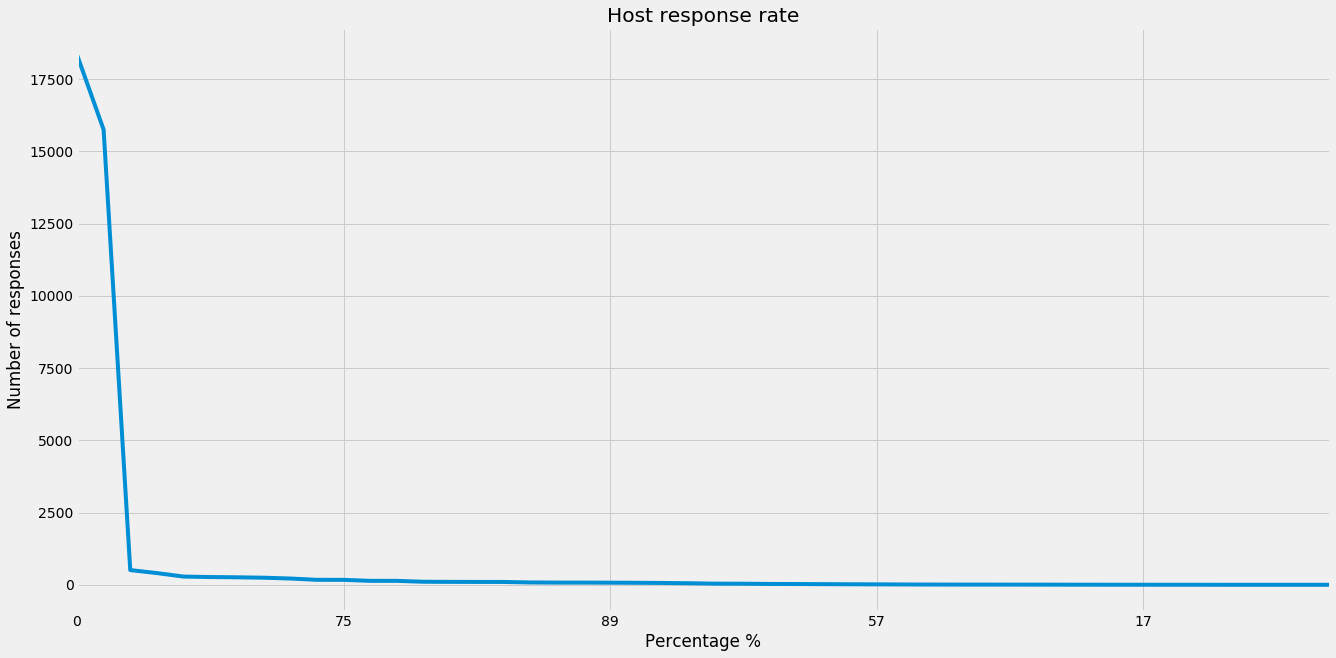

In [19]:
air_bnb.simple_host_response_rate.value_counts().plot()
plt.title('Host response rate')
plt.ylabel('Number of responses')
plt.xlabel('Percentage %')

In [20]:
# which suburb is the worst at responding?
air_bnb.simple_host_response_rate.value_counts()[0]

18345

In [21]:
# which suburb is the worst at responding?
def zero_response_rate(column):
    for x in column:
        if x =="0":
            return True
    return False

zero_response_rate(air_bnb.simple_host_response_rate)

True

In [22]:
# made a new column 
air_bnb["zero_response_rate"] = air_bnb.apply(zero_response_rate,axis=1)
air_bnb.sample(2)

id                           listing_url       scrape_id  \
1665  3363195  https://www.airbnb.com/rooms/3363195  20190710033517   
1780  3648797  https://www.airbnb.com/rooms/3648797  20190710033517   

     last_scraped                                          name  \
1665   2019-07-11  Mc Mahon's Pt Waterfront 2 Bedroom Apartment   
1780   2019-07-10              Bright Ocean View 1 Bedroom Apt.   

                                                summary space  \
1665  Large two bedroom apartment. Absolute waterfro...   NaN   
1780  Our spacious, bright 1 bedroom apartment overl...   NaN   

                                            description experiences_offered  \
1665  Large two bedroom apartment. Absolute waterfro...                none   
1780  Our spacious, bright 1 bedroom apartment overl...                none   

     neighborhood_overview notes transit access interaction house_rules  \
1665                   NaN   NaN     NaN    NaN         NaN         NaN   
1780                   NaN   NaN     NaN    NaN         NaN         NaN   

      thumbnail_url  medium_url  \
1665            NaN         NaN   
1780            NaN         NaN   

                                            picture_url  xl_picture_url  \
1665  https://a0.muscache.com/im/pictures/42623788/a...             NaN   
1780  https://a0.muscache.com/im/pictures/46750419/7...             NaN   

       host_id                                    host_url host_name  \
1665   5392754   https://www.airbnb.com/users/show/5392754      Kaye   
1780  18443501  https://www.airbnb.com/users/show/18443501    Cathal   

      host_since                               host_location host_about  \
1665  2013-03-09  McMahons Point, New South Wales, Australia        NaN   
1780  2014-07-20          Coogee, New South Wales, Australia        NaN   

      host_response_time host_response_rate  host_acceptance_rate  \
1665  within a few hours               100%                   NaN   
1780                 NaN                NaN                   NaN   

     host_is_superhost                                 host_thumbnail_url  \
1665                 f  https://a0.muscache.com/im/users/5392754/profi...   
1780                 f  https://a0.muscache.com/im/users/18443501/prof...   

                                       host_picture_url  \
1665  https://a0.muscache.com/im/users/5392754/profi...   
1780  https://a0.muscache.com/im/users/18443501/prof...   

           host_neighbourhood  host_listings_count  host_total_listings_count  \
1665  Wollstonecraft/Waverton                  3.0                        3.0   
1780                   Coogee                  1.0                        1.0   

                                     host_verifications host_has_profile_pic  \
1665  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   
1780  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t   

     host_identity_verified                          street neighbourhood  \
1665                      t  McMahons Point, NSW, Australia  North Sydney   
1780                      t          Coogee, NSW, Australia        Coogee   

     neighbourhood_cleansed  neighbourhood_group_cleansed            city  \
1665           North Sydney                           NaN  McMahons Point   
1780               Randwick                           NaN          Coogee   

     state zipcode  market             smart_location country_code    country  \
1665   NSW    2060  Sydney  McMahons Point, Australia           AU  Australia   
1780   NSW    2034  Sydney          Coogee, Australia           AU  Australia   

      latitude  longitude is_location_exact property_type        room_type  \
1665 -33.84510  151.20153                 t     Apartment  Entire home/apt   
1780 -33.92563  151.25584                 t     Apartment  Entire home/apt   

      ...  beds  bed_type                                          amenities  \
1665  ...   3.0  Real Bed  {TV,Int

In [23]:
# only used the true values from the new column
zeroresponse = air_bnb[air_bnb["zero_response_rate"]]

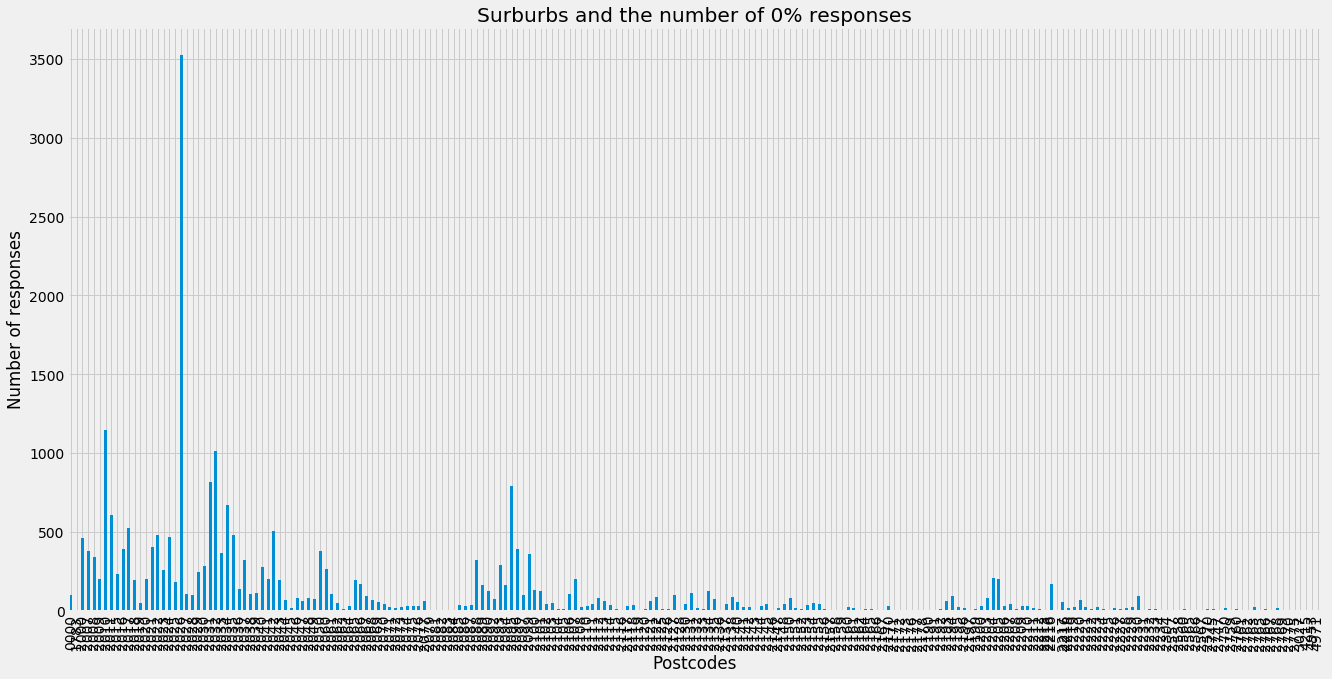

In [24]:
which_suburb_zero_responses = zeroresponse.groupby("simple_postcode").sum().host_listings_count.plot(kind="bar")
plt.title('Surburbs and the number of 0% responses')
plt.ylabel('Number of responses')
plt.xlabel('Postcodes')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [25]:
zero_response_sum = zeroresponse.groupby("simple_postcode").sum()

Text(0.5, 0, 'Postcode')

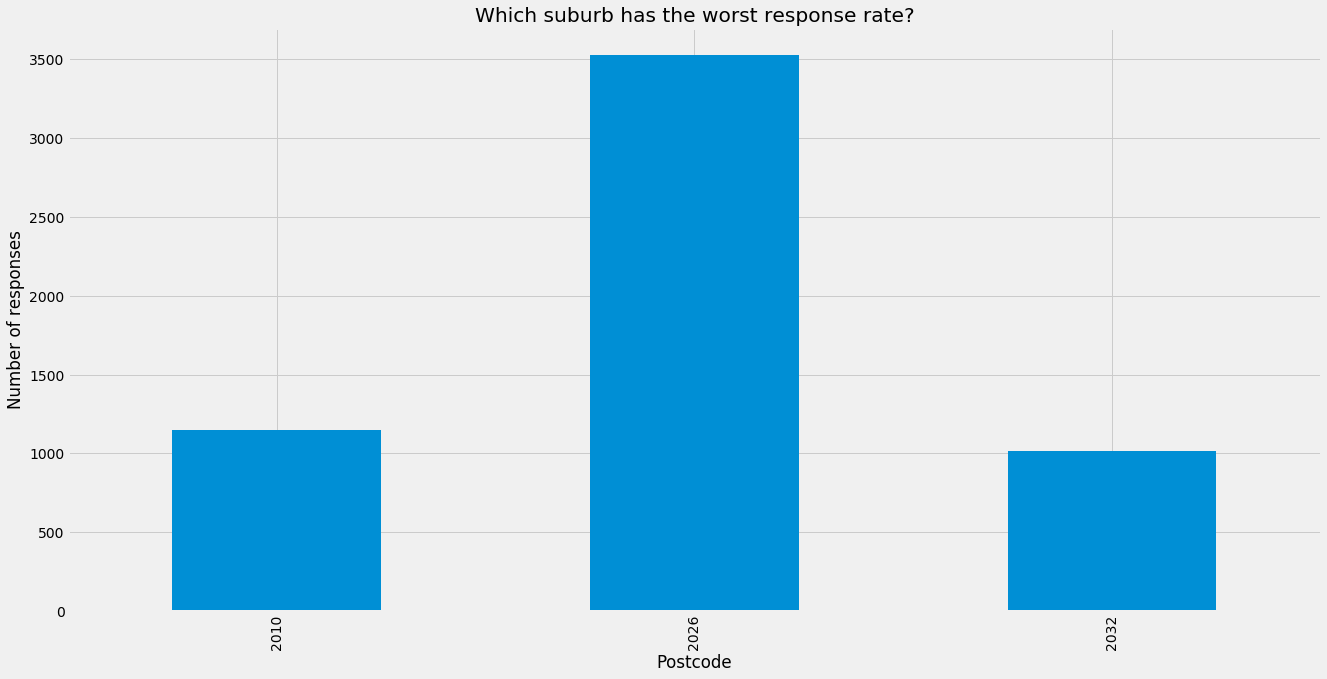

In [26]:
# which suburb has the worst response rate?
hl = zero_response_sum["host_total_listings_count"].value_counts()
zero_response_sum["host_total_listings_count"][zero_response_sum["host_total_listings_count"]>1000].plot(kind="bar")
plt.title("Which suburb has the worst response rate?")
plt.ylabel('Number of responses')
plt.xlabel('Postcode')

## Number of Airbnbs in each city
> Bondi Beach seems to have the highest number of airbnbs at first analysis. 

In [27]:
# how many cities are there?
air_bnb["city"].value_counts()

Bondi Beach                     1947
Surry Hills                     1366
Manly                           1254
Sydney                          1074
Bondi                            978
                                ... 
Minto Heights                      1
pyrmont                            1
Sydney, Bondi Beach                1
Bondi Beach, New South Wales       1
Camden South                       1
Name: city, Length: 833, dtype: int64

Text(0.5, 0, 'City name')

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24713 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30707 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/omgitskarton/anaconda3/lib/python3.7/site-p

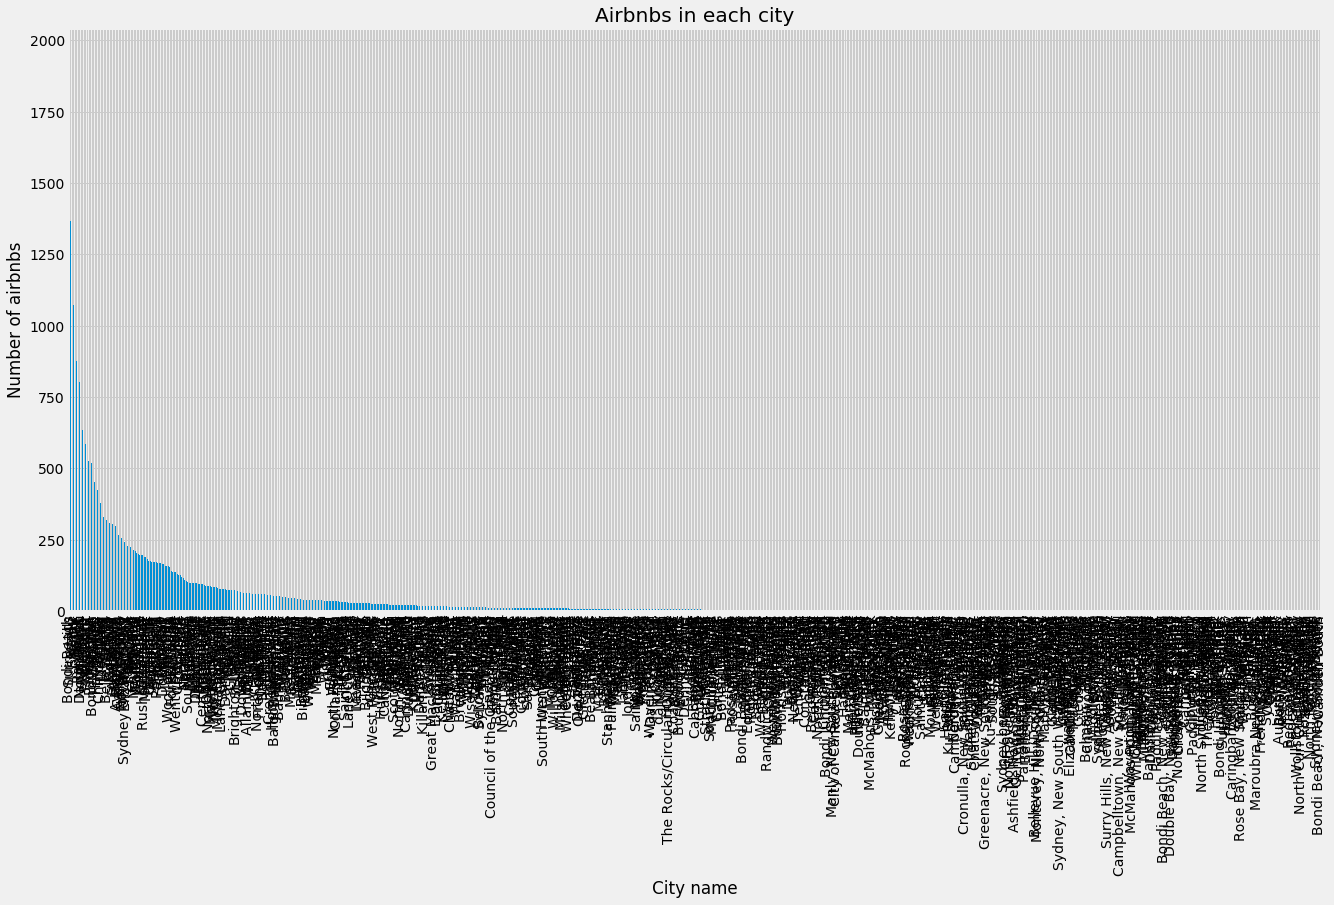

In [28]:
# How many airbnbs in each city?
air_bnb["city"].value_counts().plot(kind="bar");
plt.title("Airbnbs in each city")
plt.ylabel('Number of airbnbs')
plt.xlabel('City name')

In [29]:
# what type of cancellation policies were there?
air_bnb["cancellation_policy"].value_counts()

strict_14_with_grace_period    15367
flexible                       13924
moderate                        8587
super_strict_60                  111
super_strict_30                   67
luxury_super_strict_125            8
luxury_moderate                    7
luxury_no_refund                   7
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64

## What are the cancellation policies?

Text(0.5, 0, 'Catergoies of Cancellation Policy')

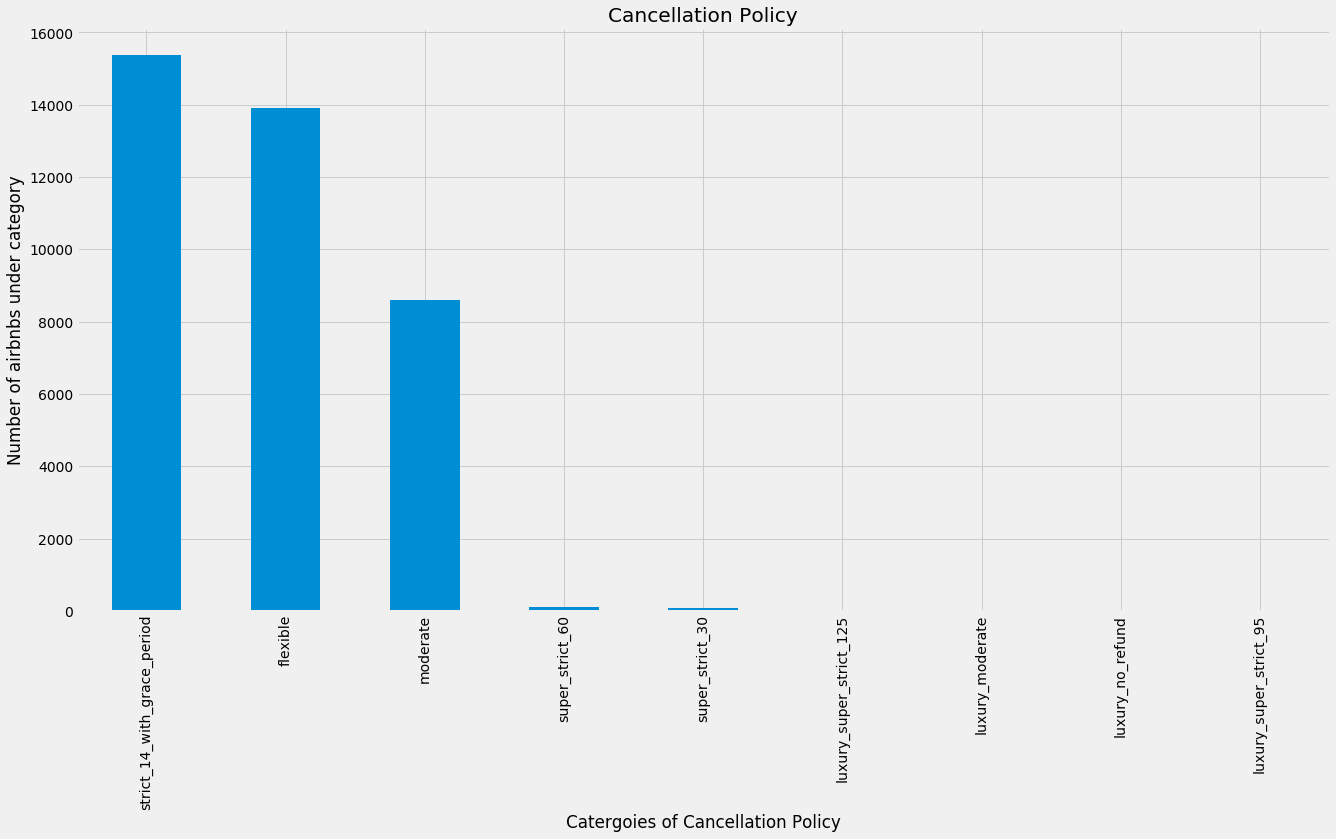

In [30]:
air_bnb["cancellation_policy"].value_counts().plot(kind="bar")
plt.title('Cancellation Policy')
plt.ylabel('Number of airbnbs under category')
plt.xlabel('Catergoies of Cancellation Policy')

## Do any of the Airbnbs offer experiences?
> Seems like no airbnbs offer any experiences. 

In [31]:
air_bnb["experiences_offered"].value_counts()

none    38080
Name: experiences_offered, dtype: int64

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


Text(0.5, 0, 'Experiences')

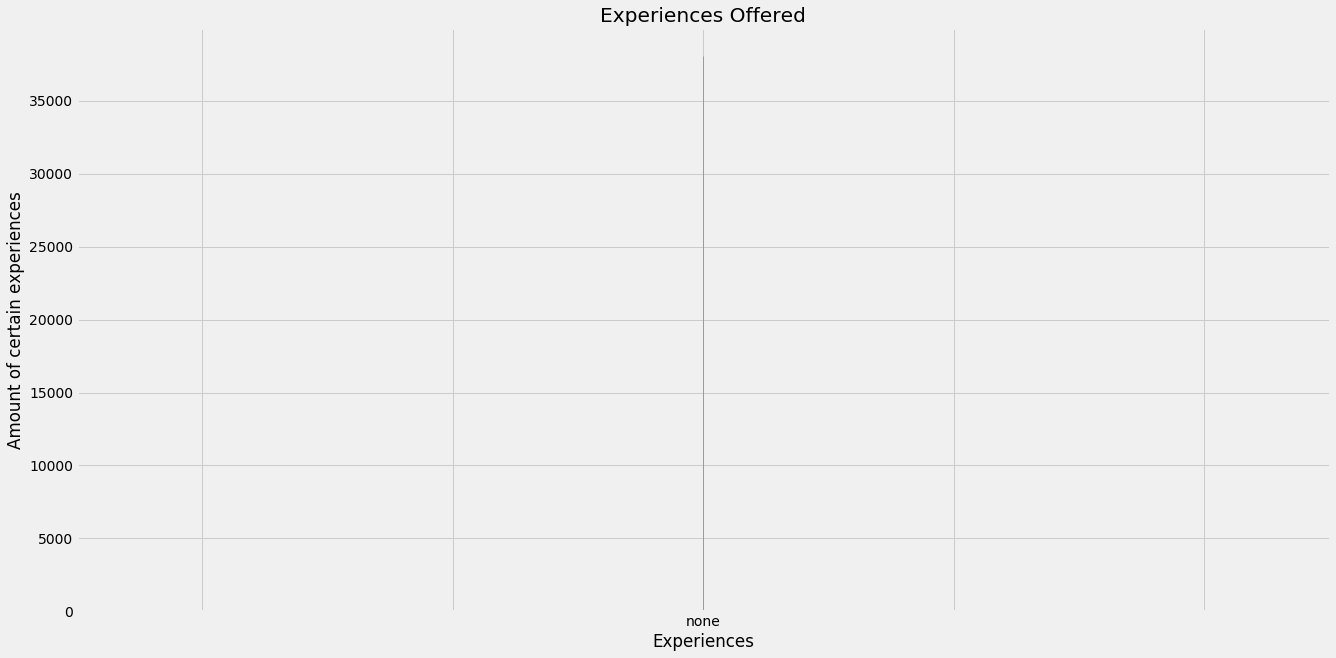

In [32]:
# did any airbnbs offer experiences?
air_bnb["experiences_offered"].value_counts().plot(kind="area");
plt.title('Experiences Offered')
plt.ylabel('Amount of certain experiences')
plt.xlabel('Experiences')

## What beds do hosts usually provide?
> What kinds of beds are there? 

Text(0.5, 0, 'Types of Bed')

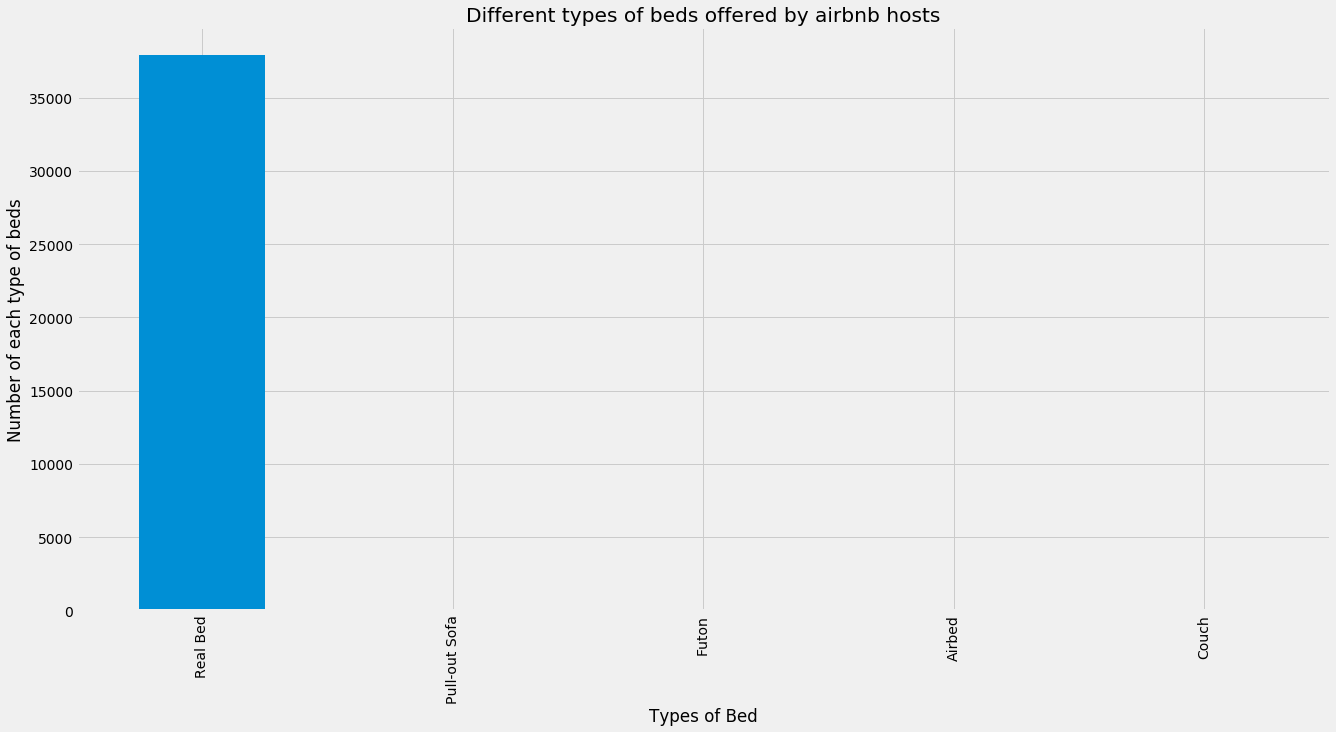

In [33]:
# different bed types offered by airbnb hosts 
air_bnb["bed_type"].value_counts().plot(kind="bar")
plt.title('Different types of beds offered by airbnb hosts')
plt.ylabel('Number of each type of beds')
plt.xlabel('Types of Bed')

In [34]:
# how many futon beds are there?
def find_futon_number(column):
    count = 0
    for x in column:
        if x =="Futon":
            count+=1
#             print(count)
    return count
            
find_futon_number(air_bnb.bed_type)
# air_bnb["bed_type"== Futon].value_counts().plot(kind="bar")

41

In [35]:
# What suburb are they in?
def futon_suburb(column):
    for x in column:
        if x =="Futon":
            return True
    return False

futon_suburb(air_bnb.bed_type)

True

In [36]:
air_bnb["Futon"] = air_bnb.apply(futon_suburb,axis=1)
air_bnb.sample(10)

id                            listing_url       scrape_id  \
2441    4589874   https://www.airbnb.com/rooms/4589874  20190710033517   
30476  30828036  https://www.airbnb.com/rooms/30828036  20190710033517   
31404  31419266  https://www.airbnb.com/rooms/31419266  20190710033517   
19250  21939223  https://www.airbnb.com/rooms/21939223  20190710033517   
29926  30549089  https://www.airbnb.com/rooms/30549089  20190710033517   
5072    8374962   https://www.airbnb.com/rooms/8374962  20190710033517   
833     1818516   https://www.airbnb.com/rooms/1818516  20190710033517   
5048    8345313   https://www.airbnb.com/rooms/8345313  20190710033517   
36389  35388351  https://www.airbnb.com/rooms/35388351  20190710033517   
35969  35095694  https://www.airbnb.com/rooms/35095694  20190710033517   

      last_scraped                                               name  \
2441    2019-07-10                                BONDI BEACH RETREAT   
30476   2019-07-11  Wonderful Brand New Apartment next to Olympic ...   
31404   2019-07-10     New Studio mins to Beach, Lagoon & Coast Walks   
19250   2019-07-10         North Bondi - beachside designer apartment   
29926   2019-07-10            2 bed apartment in a fantastic location   
5072    2019-07-10                Amazing Bondi Apartment 170sqm home   
833     2019-07-10                Charming sandstone and timber house   
5048    2019-07-10                 One double-bedroom flat, Nth Bondi   
36389   2019-07-11               Lovely room in the heart of Randwick   
35969   2019-07-11                  Mascot Private Room 20mins to CBD   

                                                 summary  \
2441   Bondi Beach Retreat offers resort style accomo...   
30476  This is totally fantastic brand new apartment ...   
31404  This brand new studio is perfect for a Norther...   
19250  In the heart of North Bondi's shops & cafes, a...   
29926  A 2 bedroom, 1 bathroom apartment in a fantast...   
5072   This is an amazing large space for a family or...   
833    Our 19th C house overlooks the city, is one bu...   
5048   One double-bedroom ground-floor flat with basi...   
36389  Hi,  I'm looking to rent out my room while I t...   
35969  This unit is centrally located within walking ...   

                                                   space  \
2441   Queen size bedroom with built ins, Air Conditi...   
30476  it and has absolutely great park view and wate...   
31404  Narrabeen lagoon, playground, oval and cricket...   
19250  The apartment has recently been fully renovate...   
29926  The space will be completely yours - the whole...   
5072   A high quality fully fitted apartment, being a...   
833    Our 19th C house overlooks the city, is one bu...   
5048   Close enough to the best bits of Bondi, but fa...   
36389  In the house itself you can access Netflix, St...   
35969  This is a 2 Bedroom Unit, Private room for you...   

                                             description experiences_offered  \
2441   Bondi Beach Retreat offers resort style accomo...                none   
30476  This is totally fantastic brand new apartment ...                none   
31404  This brand new studio is perfect for a Norther...                none   
19250  In the heart of North Bondi's shops & cafes, a...                none   
29926  A 2 bedroom, 1 bathroom apartment in a fantast...                none   
5072   This is an amazing large space for a family or...                none   
833    Our 19th C house overlooks the city, is one bu...                none   
5048   One double-bedroom ground-floor flat with basi...                none   
36389  Hi,  I'm looking to rent out my room while I t...                none   
35969  This unit is centrally located within walking ...                none   

                                   neighborhood_overview  \
2441   House is seconds from everything though quiet!...   
30476  It definitely can satisfied the basic necessit...   
31404  Stud

In [37]:
# finding out which suburb the futons are located in
# a file of all the airbnbs with futons
futonBNB = air_bnb[air_bnb["Futon"]]

In [38]:
futonBNB

id                            listing_url       scrape_id  \
110      315059    https://www.airbnb.com/rooms/315059  20190710033517   
188      496747    https://www.airbnb.com/rooms/496747  20190710033517   
1121    2140246   https://www.airbnb.com/rooms/2140246  20190710033517   
1606    3210540   https://www.airbnb.com/rooms/3210540  20190710033517   
1698    3449802   https://www.airbnb.com/rooms/3449802  20190710033517   
2649    4739402   https://www.airbnb.com/rooms/4739402  20190710033517   
2711    4779185   https://www.airbnb.com/rooms/4779185  20190710033517   
3097    5230652   https://www.airbnb.com/rooms/5230652  20190710033517   
3136    5288902   https://www.airbnb.com/rooms/5288902  20190710033517   
3666    6134420   https://www.airbnb.com/rooms/6134420  20190710033517   
3792    6348422   https://www.airbnb.com/rooms/6348422  20190710033517   
3910    6495371   https://www.airbnb.com/rooms/6495371  20190710033517   
4296    7060893   https://www.airbnb.com/rooms/7060893  20190710033517   
4429    7331273   https://www.airbnb.com/rooms/7331273  20190710033517   
4601    7652264   https://www.airbnb.com/rooms/7652264  20190710033517   
5104    8417279   https://www.airbnb.com/rooms/8417279  20190710033517   
5555    9012813   https://www.airbnb.com/rooms/9012813  20190710033517   
5834    9242045   https://www.airbnb.com/rooms/9242045  20190710033517   
5844    9259004   https://www.airbnb.com/rooms/9259004  20190710033517   
6032    9395110   https://www.airbnb.com/rooms/9395110  20190710033517   
7381   10212039  https://www.airbnb.com/rooms/10212039  20190710033517   
8094   11325465  https://www.airbnb.com/rooms/11325465  20190710033517   
8404   11760748  https://www.airbnb.com/rooms/11760748  20190710033517   
8699   12190940  https://www.airbnb.com/rooms/12190940  20190710033517   
8990   12692174  https://www.airbnb.com/rooms/12692174  20190710033517   
9804   13629326  https://www.airbnb.com/rooms/13629326  20190710033517   
9848   13694461  https://www.airbnb.com/rooms/13694461  20190710033517   
9875   13720195  https://www.airbnb.com/rooms/13720195  20190710033517   
9886   13736307  https://www.airbnb.com/rooms/13736307  20190710033517   
10057  13941758  https://www.airbnb.com/rooms/13941758  20190710033517   
10154  14076297  https://www.airbnb.com/rooms/14076297  20190710033517   
11096  15331992  https://www.airbnb.com/rooms/15331992  20190710033517   
13999  17611591  https://www.airbnb.com/rooms/17611591  20190710033517   
16142  19939776  https://www.airbnb.com/rooms/19939776  20190710033517   
16258  20058436  https://www.airbnb.com/rooms/20058436  20190710033517   
16920  20728803  https://www.airbnb.com/rooms/20728803  20190710033517   
17459  21118691  https://www.airbnb.com/rooms/21118691  20190710033517   
17519  21165925  https://www.airbnb.com/rooms/21165925  20190710033517   
19471  21999536  https://www.airbnb.com/rooms/21999536  20190710033517   
21003  22520914  https://www.airbnb.com/rooms/22520914  20190710033517   
32448  32388997  https://www.airbnb.com/rooms/32388997  20190710033517   

      last_scraped                                               name  \
110     2019-07-11                     Stylish Home In Great Location   
188     2019-07-10                   Bondi, Sydney, room in cosy flat   
1121    2019-07-10                        Quiet, convenient apartment   
1606    2019-07-10                     Cool City Pad in Circular Quay   
1698    2019-07-10  Xmas in spacious Terrace house with garden & d...   
2649    2019-07-11                Marrickville Modern  An Urban Oasis   
2711    2019-07-10                  Private Garden Studio by the Pool   
3097    2019-07-10                       Charming  Art Deco Apartment   
3136    2019-07-10                      Large Art Deco - At the Beach   
3666    2019-07-10                  Single bed mattress private room.   
3792    2019-07-10                                         The Manor-   
3910    2019-07-11          

Text(0.5, 0, 'Postcode')

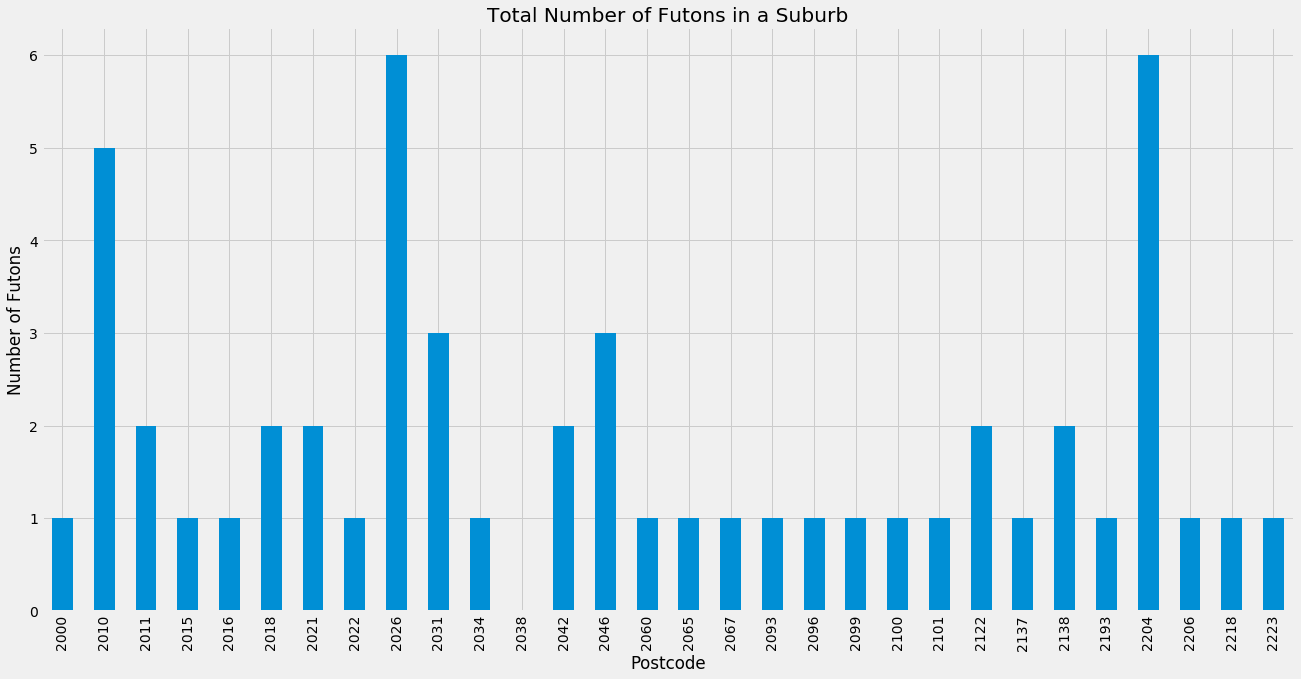

In [39]:
sum_of_futon_in_suburb = futonBNB.groupby("simple_postcode").sum().host_listings_count.plot(kind="bar")
plt.title('Total Number of Futons in a Suburb')
plt.ylabel('Number of Futons')
plt.xlabel('Postcode')

> The Futons are spread evenly across NSW.

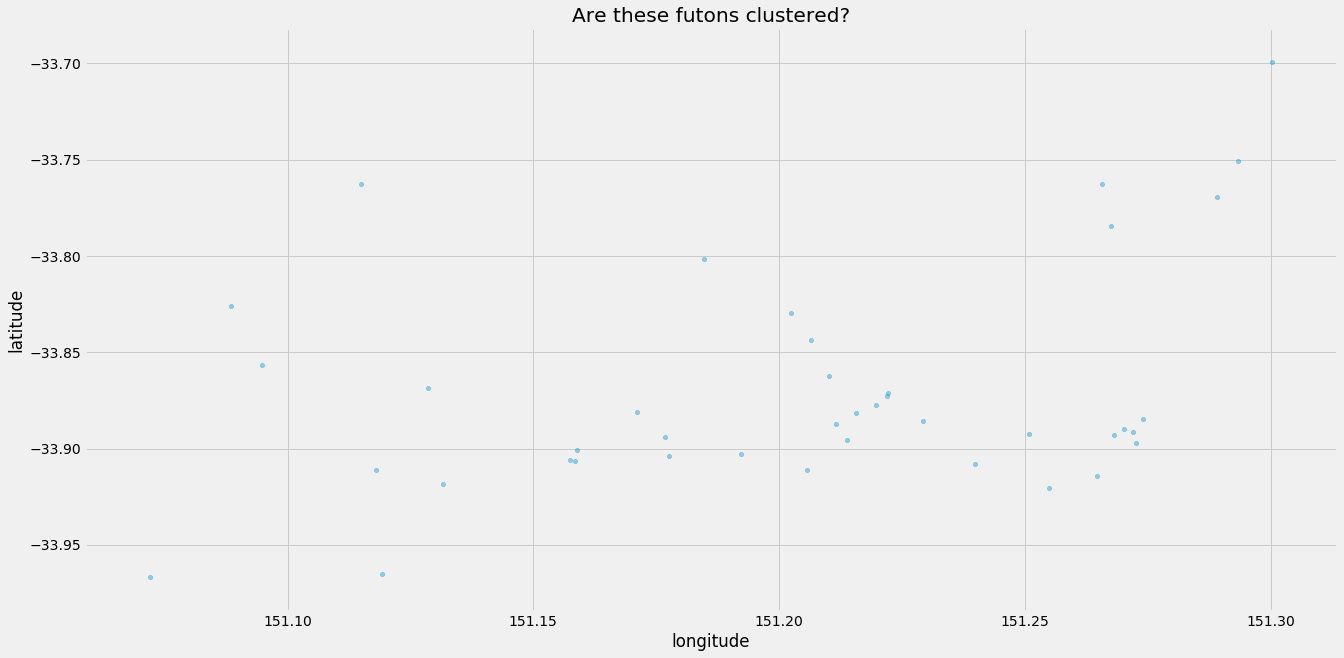

In [40]:
# Where the futons are
futonBNB.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.title('Are these futons clustered?')
plt.show()

Text(0.5, 1, 'NORTH BONDI')

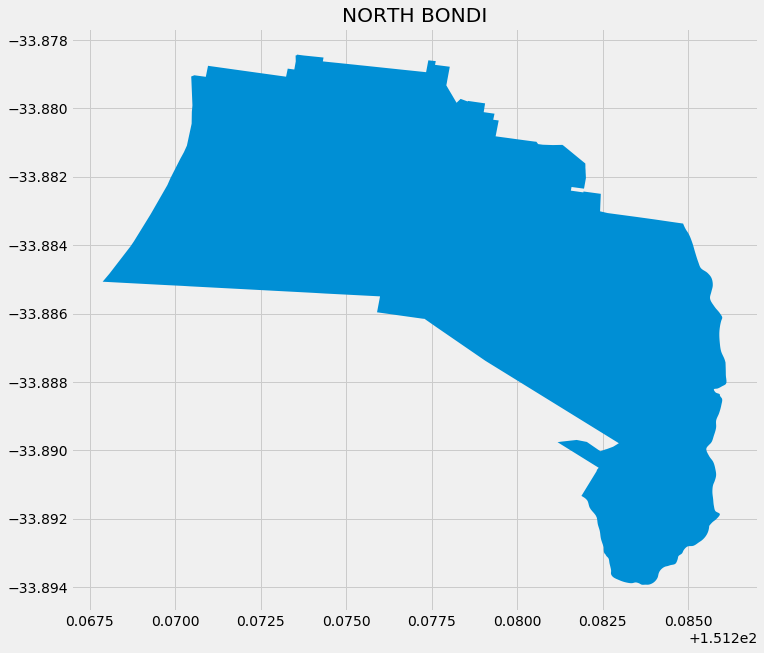

In [41]:
# Suburbs with the highest amount of Futons
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
air_bnb_burbs = (burbs[burbs.NSW_LOCA_2 == "NORTH BONDI"])
air_bnb_burbs.head()
air_bnb_burbs.plot()
plt.title("NORTH BONDI")

Text(0.5, 1, 'MARRICKVILLE')

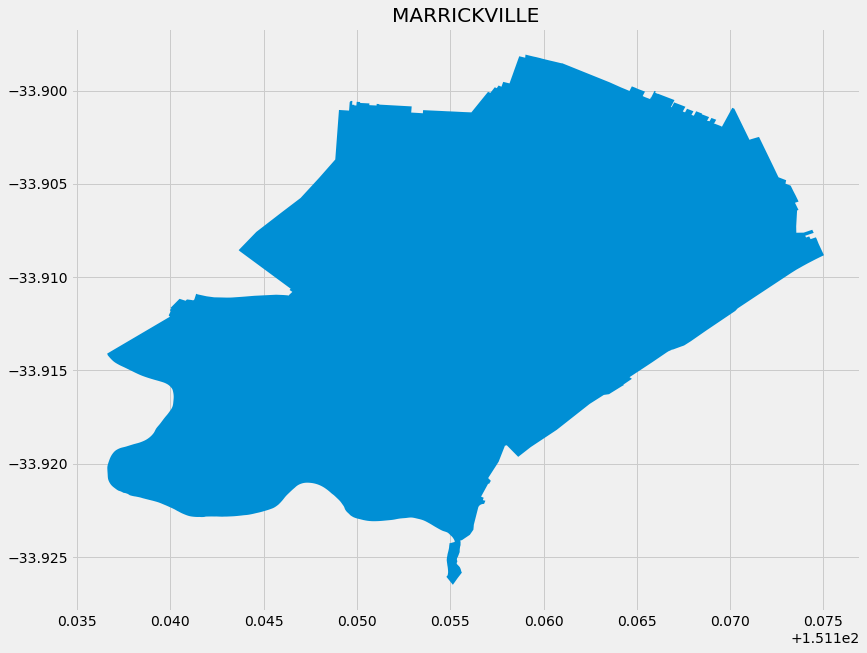

In [42]:
# which suburb has the most futons
burbs = gp.GeoDataFrame.from_file(shp_file_name)
air_bnb_burbs = burbs[burbs.NSW_LOCA_2 == "MARRICKVILLE"]
air_bnb_burbs.head()
air_bnb_burbs.plot()
plt.title("MARRICKVILLE")

### Where do those hosts live?
> With the exception of some not providing their location, most hosts live in Sydney City. 

Text(0.5, 0, 'Suburb')

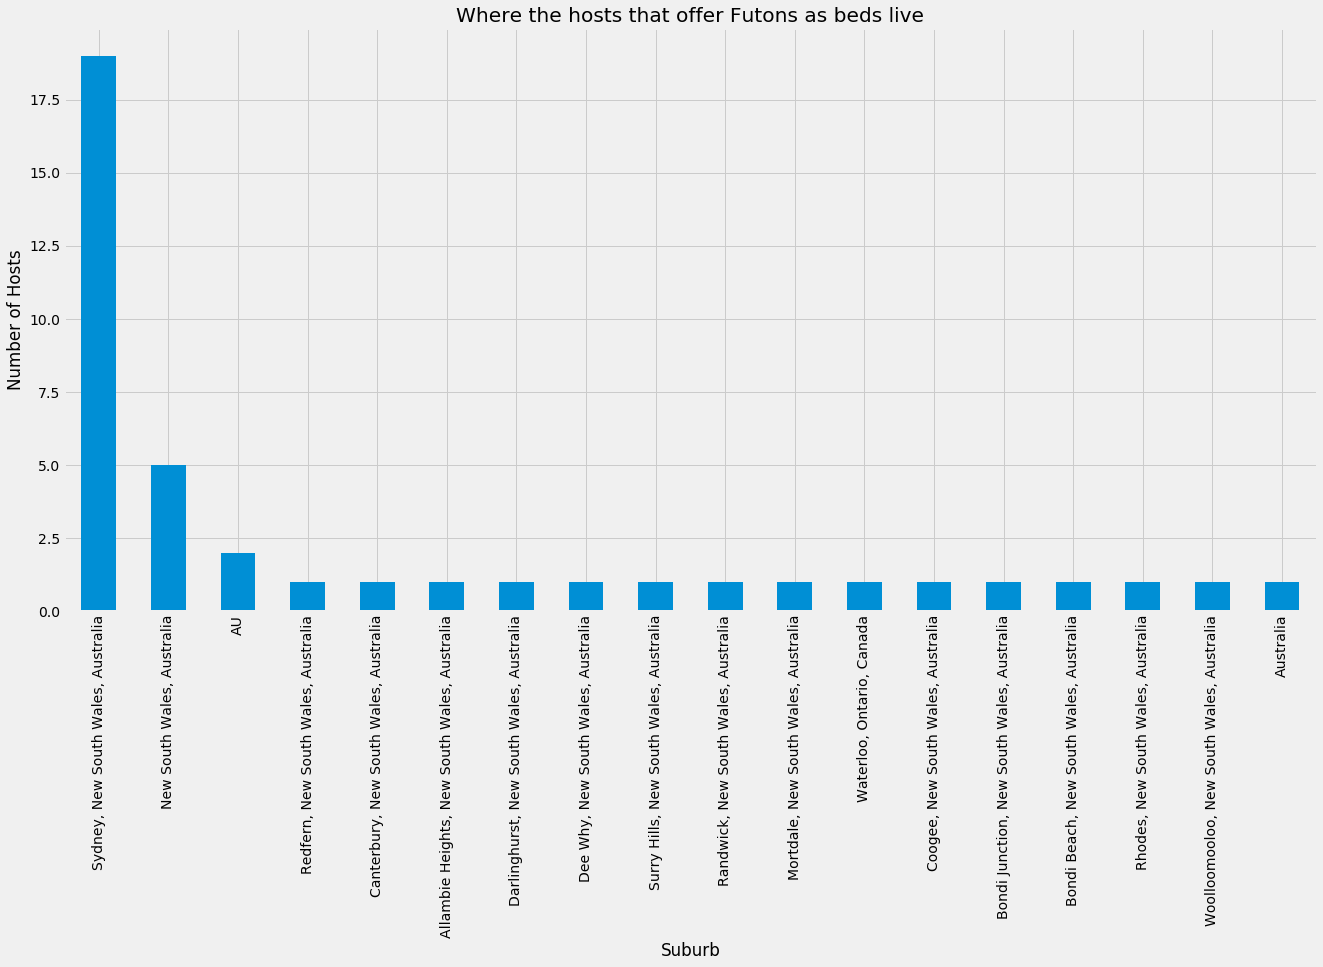

In [43]:
futonBNB["host_location"].value_counts().plot(kind="bar");
plt.title("Where the hosts that offer Futons as beds live")
plt.ylabel('Number of Hosts')
plt.xlabel('Suburb')

## What types of accommodation is offered?

Text(0.5, 0, 'Types of airbnbs')

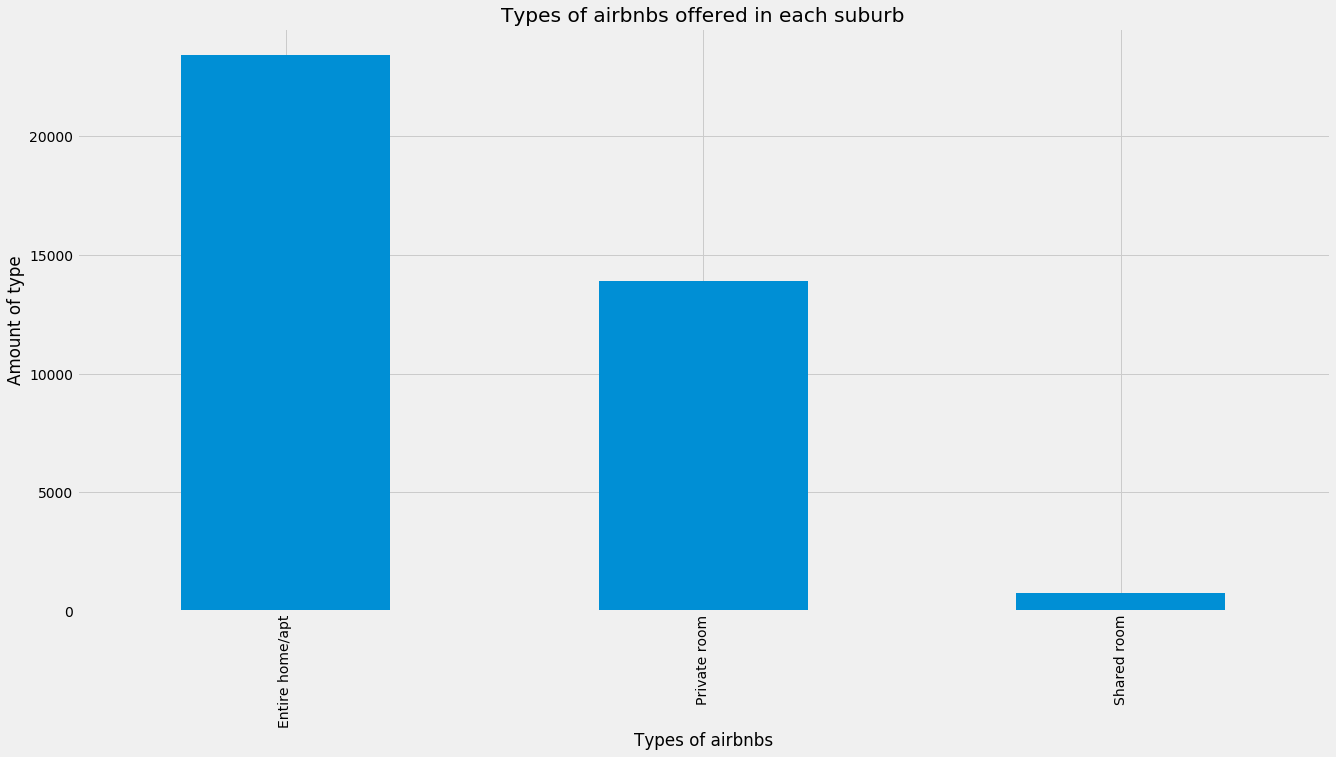

In [44]:
# different types of accomodation offered 
air_bnb["room_type"].value_counts().plot(kind="bar")
plt.title("Types of airbnbs offered in each suburb")
plt.ylabel('Amount of type')
plt.xlabel('Types of airbnbs')

In [45]:
# is it an entire home, private room or shared room?
def entirehome(column):
    for x in column:
        if x =="Entire home/apt":
            return True
    return False
    
entirehome(air_bnb.room_type)

True

In [46]:
air_bnb["Entire_home"] = air_bnb.apply(entirehome,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
21711  23126922  https://www.airbnb.com/rooms/23126922  20190710033517   
20373  22284544  https://www.airbnb.com/rooms/22284544  20190710033517   
12549  16300694  https://www.airbnb.com/rooms/16300694  20190710033517   
26768  28664838  https://www.airbnb.com/rooms/28664838  20190710033517   
4953    8217795   https://www.airbnb.com/rooms/8217795  20190710033517   

      last_scraped                                               name  \
21711   2019-07-10  Fully furnished bedrooms in a truly awesome house   
20373   2019-07-10                       Room In Beautiful Freshwater   
12549   2019-07-11     Resort living: 2 min stroll to Rushcutters Bay   
26768   2019-07-10  Comfy family home in chill beachside neighbour...   
4953    2019-07-10                   Lovely sunlit bedroom with views   

                                                 summary  \
21711  Fully furnished bedrooms for 1 or 2 people in ...   
20373  You're getting a simple room in a share house,...   
12549  Centrally located in the beautiful district of...   
26768  Come stay at our place in Bronte and you'll fe...   
4953   Perfect location for your Sydney visit - minut...   

                                                   space  \
21711  Full kitchen with Coffee Machine and Cold Pres...   
20373                                                NaN   
12549  This home offers a unique sense of style, beau...   
26768  Great for families, groups or a pair of couple...   
4953   Just listed.....situated in the heart of Darli...   

                                             description experiences_offered  \
21711  Fully furnished bedrooms for 1 or 2 people in ...                none   
20373  You're getting a simple room in a share house,...                none   
12549  Centrally located in the beautiful district of...                none   
26768  Come stay at our place in Bronte and you'll fe...                none   
4953   Perfect location for your Sydney visit - minut...                none   

                                   neighborhood_overview  \
21711  Close to beach, local shops, cafe, restaurants...   
20373                                                NaN   
12549  You are close to all the very best activities ...   
26768  Bus stops are 3-5 mins walk and buses to Bondi...   
4953   Darlinghurst is a wonderful place to live -  c...   

                                                   notes  \
21711                                                NaN   
20373                                                NaN   
12549  Detailed welcome notes are in a file in the ap...   
26768  When you arrive at the property you will find ...   
4953                                                 NaN   

                                                 transit  \
21711                              Walk, Bike, Bus, Uber   
20373                                                NaN   
12549           There is a parking space in the basement   
26768  Buses to Bondi junction leave from Bronte Road...   
4953   Close to bus and train transport.   Free apart...   

                                                  access  \
21711  Full laundry with products Full kitchen with p...   
20373                                                NaN   
12549  You will have access to the entire home and po...   
26768  You’ll have access to the entire property when...   
4953   You can use the good-sized pool and undergroun...   

                                             interaction  \
21711                                                NaN   
20373                                                NaN   
12549  We have a little help from our friends at Home...   
26768  Your stay will be hosted by the local hospital...   
4953   I’m a retired English language teacher working...   

                                             house_rules  thumbnail_url  \
21711                                         

In [47]:
entirehomeBNB = air_bnb[air_bnb["Entire_home"]]

Text(0.5, 0, 'Suburb')

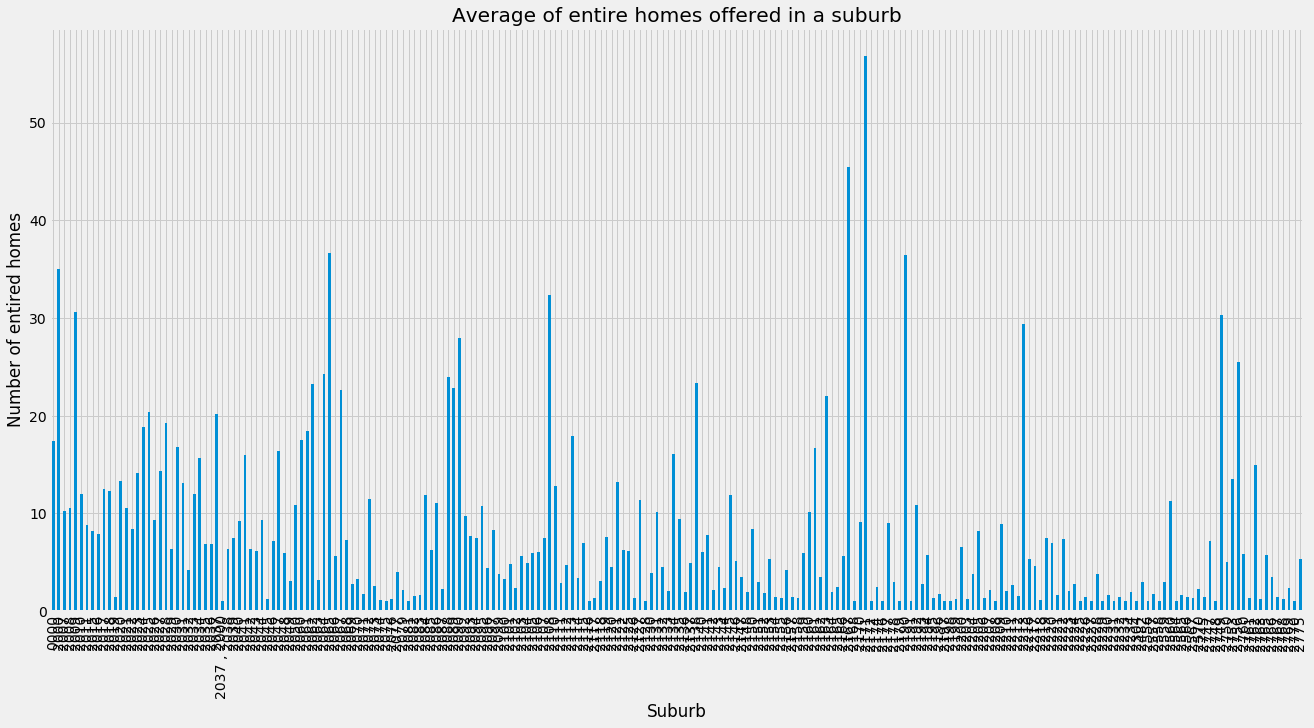

In [48]:
mean_of_entirehomes_in_suburb = entirehomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="bar")
plt.title("Average of entire homes offered in a suburb")
plt.ylabel('Number of entired homes')
plt.xlabel('Suburb')

In [49]:
# is it an entire home or shared room?
def sharedhome(column):
    for x in column:
        if x =="Private room" or x =="Shared room":
            return True
    return False

sharedhome(air_bnb.room_type)

True

In [50]:
air_bnb["Shared"] = air_bnb.apply(sharedhome,axis=1)
air_bnb.sample(10)

id                            listing_url       scrape_id  \
32591  32505855  https://www.airbnb.com/rooms/32505855  20190710033517   
30260  30748333  https://www.airbnb.com/rooms/30748333  20190710033517   
36665  35624460  https://www.airbnb.com/rooms/35624460  20190710033517   
20001  22179881  https://www.airbnb.com/rooms/22179881  20190710033517   
24712  26281162  https://www.airbnb.com/rooms/26281162  20190710033517   
24038  25297415  https://www.airbnb.com/rooms/25297415  20190710033517   
18888  21819068  https://www.airbnb.com/rooms/21819068  20190710033517   
26860  28748907  https://www.airbnb.com/rooms/28748907  20190710033517   
17584  21195156  https://www.airbnb.com/rooms/21195156  20190710033517   
27343  29188311  https://www.airbnb.com/rooms/29188311  20190710033517   

      last_scraped                                               name  \
32591   2019-07-10        Friendly home 4 minute walk from the beach!   
30260   2019-07-10  Walk to the city from this renovated heritage gem   
36665   2019-07-10  Mosman water views (Bikes included), close to CBD   
20001   2019-07-10            Stylish Character Terrace In Alexandria   
24712   2019-07-10                       517/63 Belmore Road Randwick   
24038   2019-07-10                          Apartment in Manly Beach!   
18888   2019-07-11                  Beach front one bedroom apartment   
26860   2019-07-10       #2 Perfect CBD Location Sunny Double Bedroom   
17584   2019-07-10    Nice bedroom in new apartment close to airport!   
27343   2019-07-11     Peaceful Top floor 4 bed unit near Manly Beach   

                                                 summary  \
32591  Light and spacious house a 4 minute walk from ...   
30260  You'll find yourself at the centre of everythi...   
36665  Sunny stylish apartment in the heart of Mosman...   
20001  Our house is a renovated character filled terr...   
24712  Well positioned apartment in the heart of Rand...   
24038  Quaint apartment in the center of manly!! 5 mi...   
18888  Modern one bedroom beach front apartment. 25 m...   
26860  A bright and welcoming private double bedroom ...   
17584  Private room for 2 in a luxury apartment avail...   
27343  In whisper-quiet surrounds, with district view...   

                                                   space  \
32591  I rent the other room in the house. I’m super ...   
30260  Located on Harris St, this terrace apartment r...   
36665  The apartment was recently renewed! In additio...   
20001  The house has a large front bedroom with a dou...   
24712                                                NaN   
24038                                                NaN   
18888  One bedroom modern beach front apartment locat...   
26860  A perfectly located 3 bedroom home walking dis...   
17584                                                NaN   
27343  This house is situated in a private and presti...   

                                             description experiences_offered  \
32591  Light and spacious house a 4 minute walk from ...                none   
30260  You'll find yourself at the centre of everythi...                none   
36665  Sunny stylish apartment in the heart of Mosman...                none   
20001  Our house is a renovated character filled terr...                none   
24712  Well positioned apartment in the heart of Rand...                none   
24038  Quaint apartment in the center of manly!! 5 mi...                none   
18888  Modern one bedroom beach front apartment. 25 m...                none   
26860  A bright and welcoming private double bedroom ...                none   
17584  Private room for 2 in a luxury apartment avail...                none   
27343  In whisper-quiet surrounds, with district view...                none   

                                   neighborhood_overview  \
32591  Coogee is awesome and I’m so close to everythi...   
30260  Located just across Darling Harbour from the c...   
36665  One 

In [51]:
sharedhomeBNB = air_bnb[air_bnb["Shared"]]

In [52]:
sharedhomeBNB.sample(5)

id                            listing_url       scrape_id  \
34536  33997881  https://www.airbnb.com/rooms/33997881  20190710033517   
10665  14859175  https://www.airbnb.com/rooms/14859175  20190710033517   
23521  24735597  https://www.airbnb.com/rooms/24735597  20190710033517   
8978   12682455  https://www.airbnb.com/rooms/12682455  20190710033517   
12364  16230566  https://www.airbnb.com/rooms/16230566  20190710033517   

      last_scraped                                             name  \
34536   2019-07-10                         Beautiful City Hide Away   
10665   2019-07-10                             Stylish Bondi Living   
23521   2019-07-10  In the Heart of Sydney Large Heritage Townhouse   
8978    2019-07-10                           Bondi Beachside Beauty   
12364   2019-07-10               Comfy room in beautiful apartment.   

                                                 summary  \
34536  Incredible location! Super close to Newtown (1...   
10665  1 bedroom fully furnished is available from no...   
23521  Our charming old heritage townhouse with origi...   
8978   Lovely, immaculate room in a beachside apartme...   
12364  Comfy room in beautiful apartment. Includes ev...   

                                                   space  \
34536  Large Master bedroom with comfortable queen si...   
10665  Great  apartment walking distance from both Bo...   
23521  Large master bedroom with private balcony over...   
8978   Welcome to Bondi Beach. If you're looking for ...   
12364                                                NaN   

                                             description experiences_offered  \
34536  Incredible location! Super close to Newtown (1...                none   
10665  1 bedroom fully furnished is available from no...                none   
23521  Our charming old heritage townhouse with origi...                none   
8978   Lovely, immaculate room in a beachside apartme...                none   
12364  Comfy room in beautiful apartment. Includes ev...                none   

                                   neighborhood_overview  \
34536  Erskineville is one of Sydneys niches suburbs....   
10665     Bondi beach... the greatest place in the world   
23521  The house is a 20min bus ride to Circular Quay...   
8978   We live in the quiet, untouristy part of Bondi...   
12364  Sydney's little Little Italy five dock is quie...   

                                                   notes  \
34536                                                NaN   
10665                                                NaN   
23521                                                NaN   
8978   As we are beachside, there is limited parking....   
12364                                                NaN   

                                                 transit  \
34536  Very close to the train station. 15 mins to ne...   
10665  busses and trains but honestly i walk to bondi...   
23521  The house is a 20min bus ride to Circular Quay...   
8978   Buses 333, 380 stop just 2 minutes away and co...   
12364  Less than 15min drive to the CBD and 30 min wi...   

                                                  access  \
34536  You will have access to the kitchen and the co...   
10665                   You can access all the apartment   
23521  You will have full access to the indoor and ou...   
8978   Please feel free to make use of the kitchen an...   
12364                                                NaN   

                                             interaction  \
34536  We are respectful and considerate. Always will...   
10665                                                NaN   
23521         You will have the whole house to yourself!   
8978   Myself (British) and my partner Ezra (Mexican)...   
12364                                                NaN   

                                             house_rules  thumbnail_url  \
34536  Please do not bring any additional people with...  

Text(0.5, 0, 'Suburb')

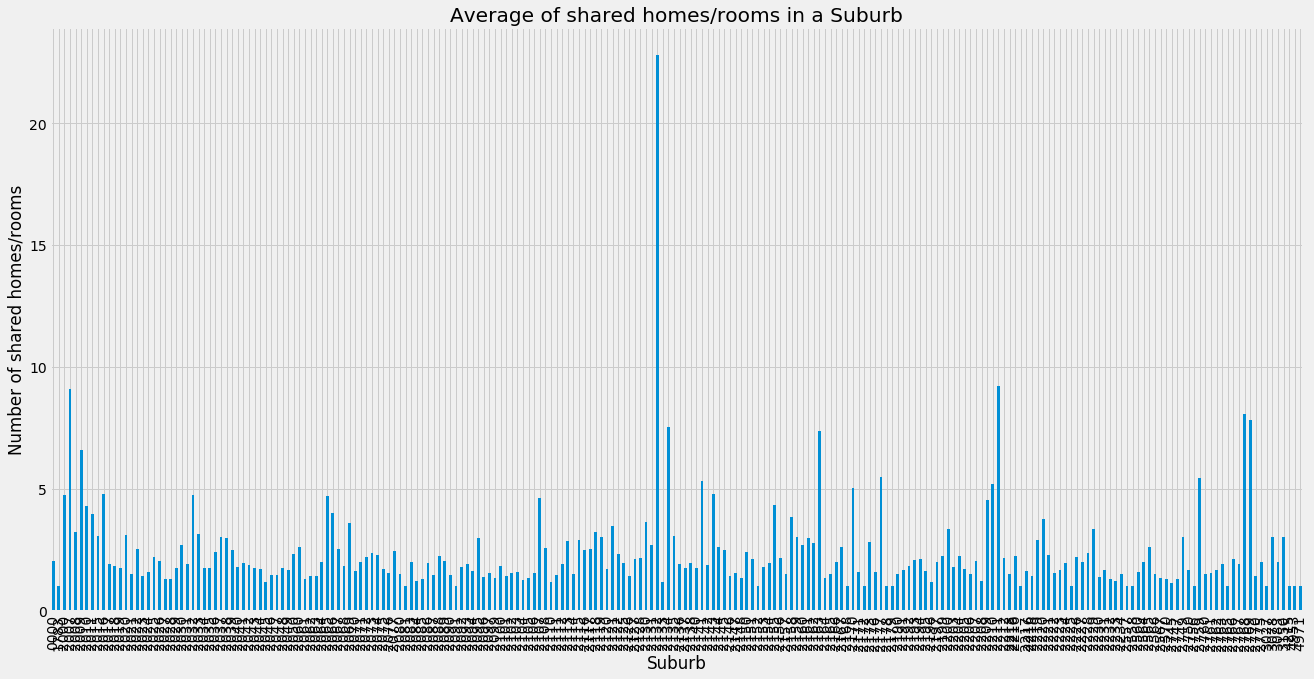

In [53]:
mean_of_sharedhomes_in_suburb = sharedhomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="bar")
plt.title("Average of shared homes/rooms in a Suburb")
plt.ylabel('Number of shared homes/rooms')
plt.xlabel('Suburb')

Text(0.5, 0, 'Bed types')

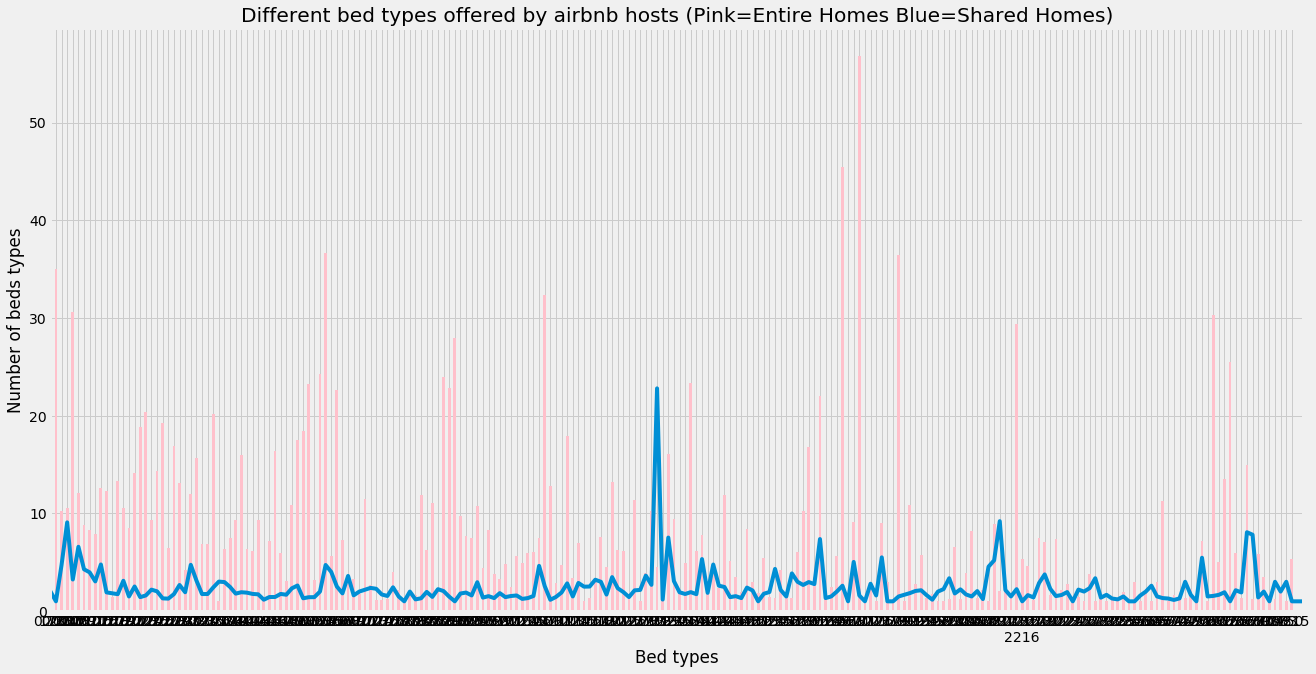

In [54]:
# ratio of entire homes to shared homes in different suburbs
mean_of_entirehomes_in_suburb = entirehomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="bar",facecolor='pink')
mean_of_sharedhomes_in_suburb = sharedhomeBNB.groupby("simple_postcode").mean().host_listings_count.plot(kind="line")
plt.title('Different bed types offered by airbnb hosts (Pink=Entire Homes Blue=Shared Homes)')
plt.ylabel('Number of beds types')
plt.xlabel('Bed types')

In [55]:
air_bnb.price = air_bnb.price.apply(float_str_to_int)

In [56]:
type(air_bnb.price.iloc[0])

numpy.int64

In [57]:
some_numbers = pd.Series(range(100))
some_numbers.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [58]:
some_numbers[some_numbers < 8]

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
dtype: int64

In [59]:
some_numbers[(some_numbers < 4) | (some_numbers > 97)]

0      0
1      1
2      2
3      3
98    98
99    99
dtype: int64

## Which suburbs have the least amount of Airbnbs?

In [60]:
air_bnb["zipcode"].value_counts()

2026           1988
2026.0         1952
2010.0         1164
2000.0         1137
2010           1022
               ... 
4971.0            1
2037 , 2000       1
4953.0            1
2163              1
2769              1
Name: zipcode, Length: 449, dtype: int64

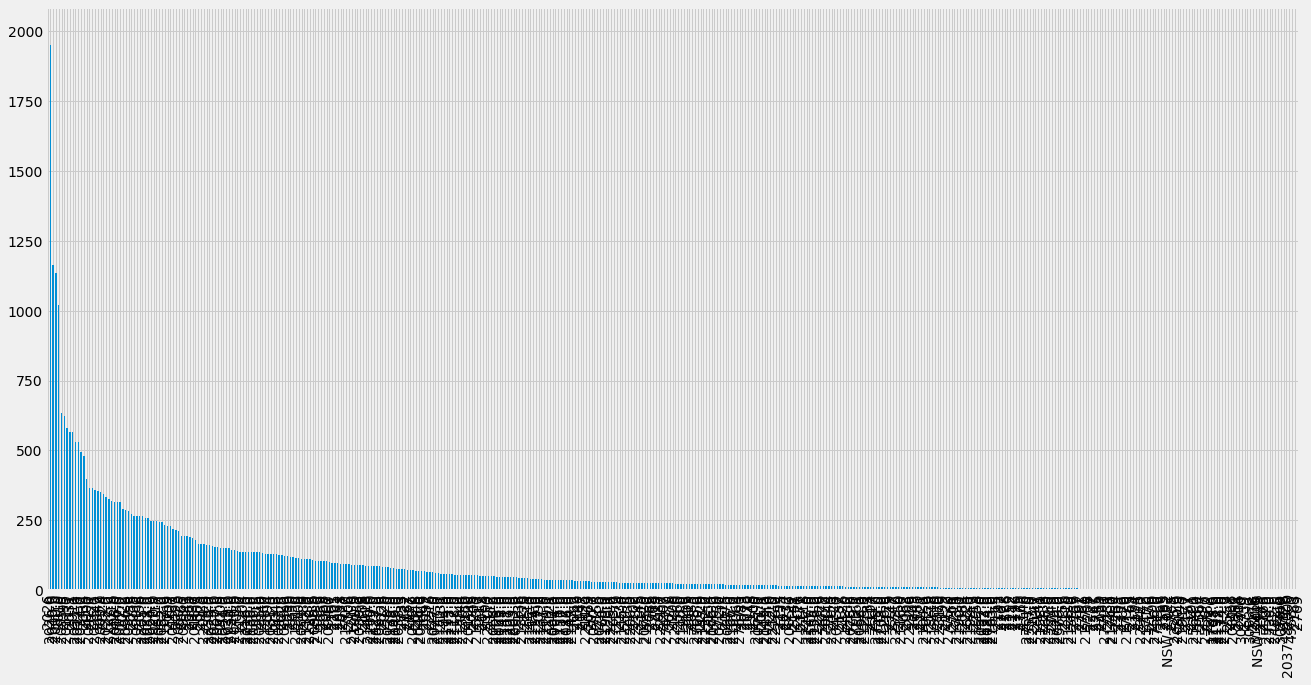

In [61]:
air_bnb["zipcode"].value_counts().plot(kind="bar")

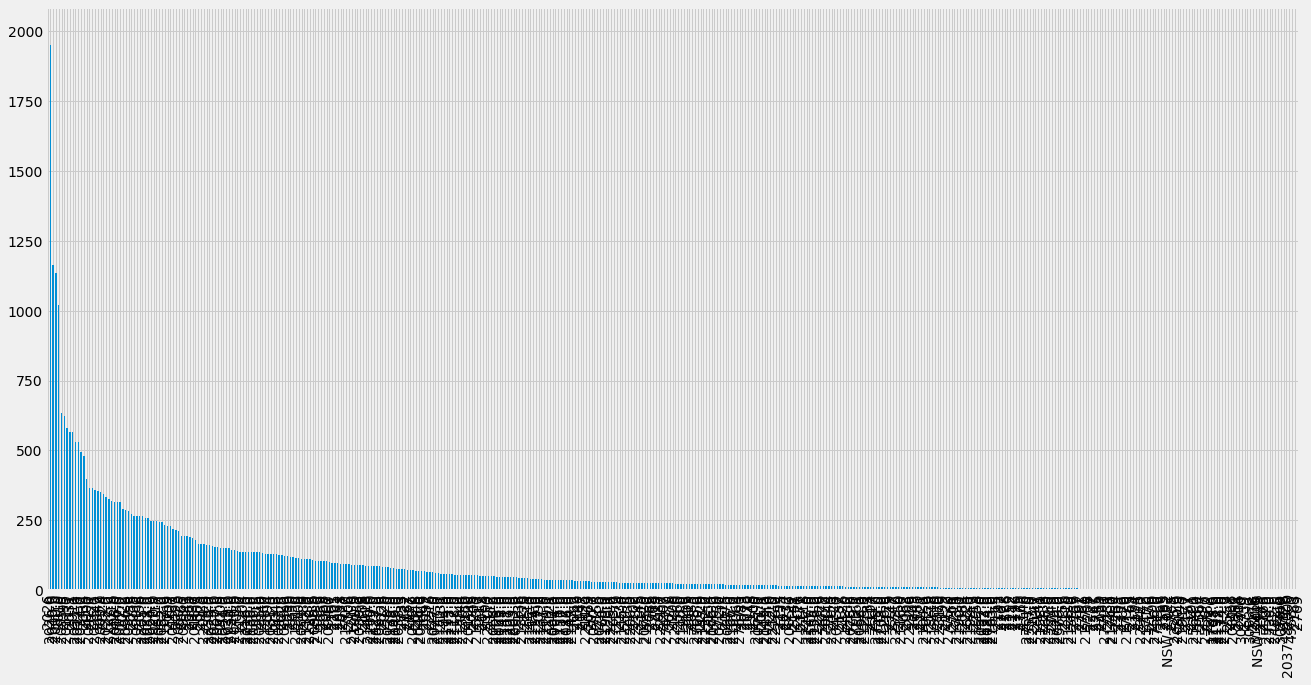

In [62]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 2000].plot(kind="bar")

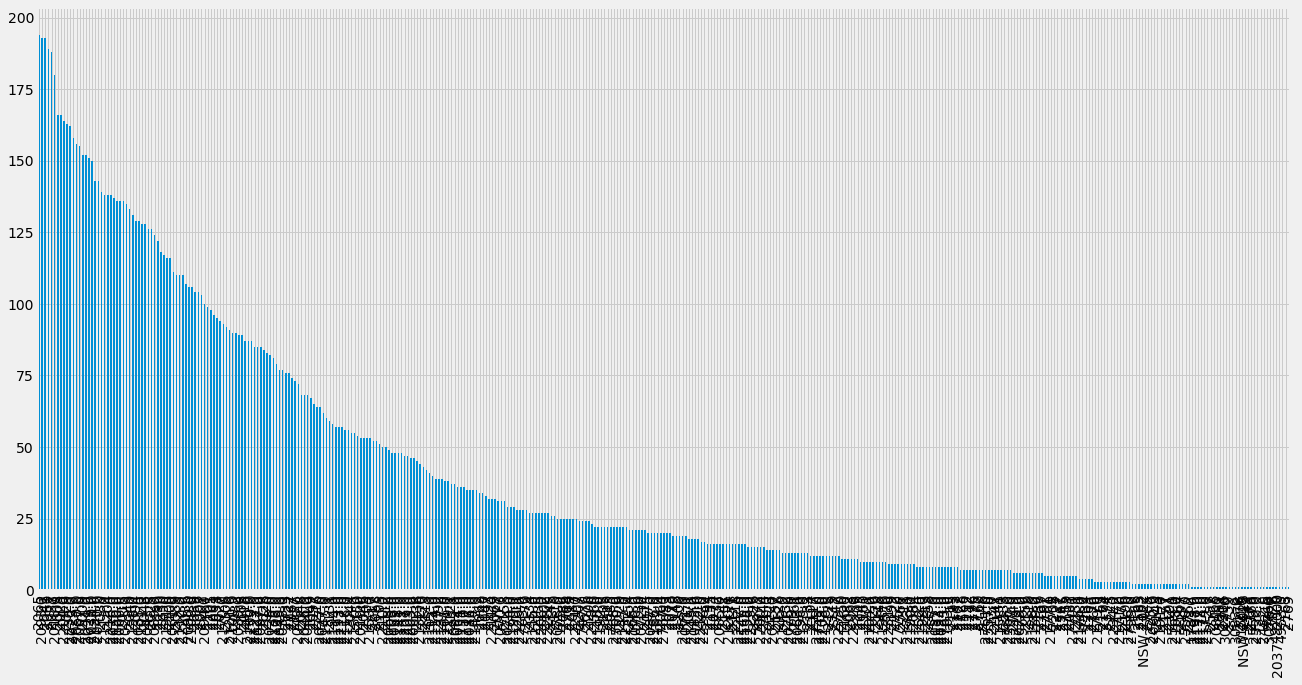

In [63]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 200].plot(kind="bar")

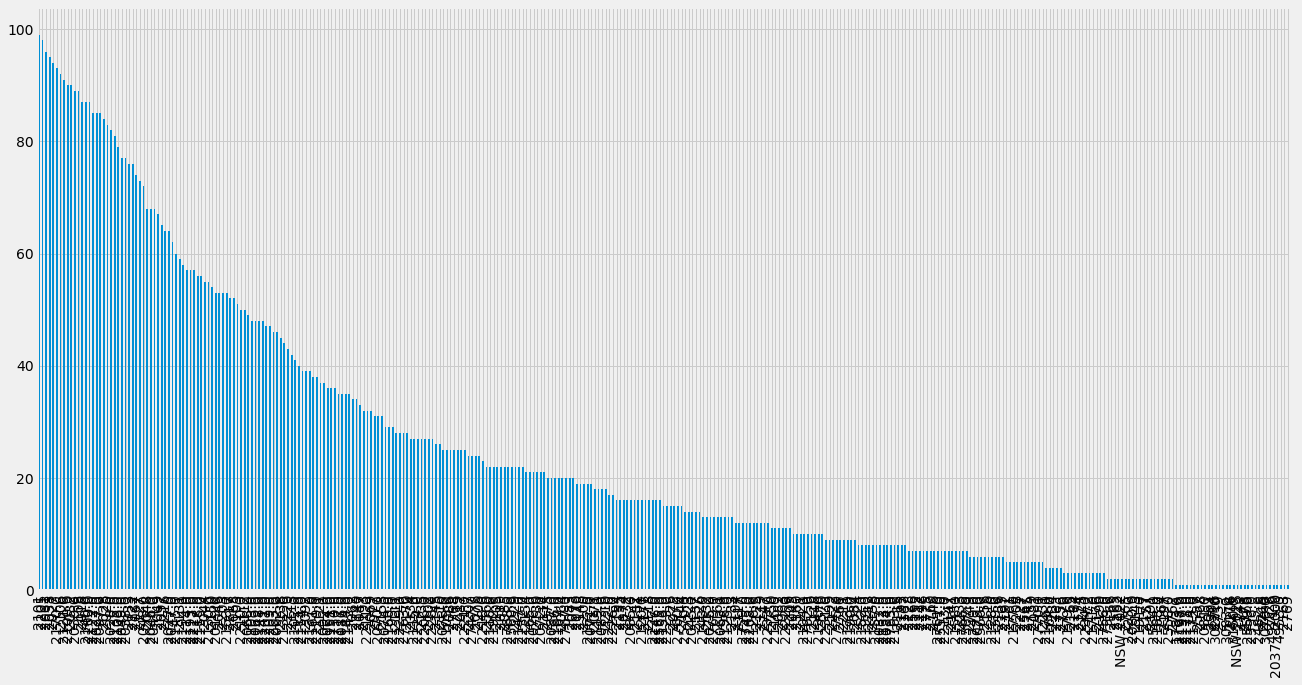

In [64]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 100].plot(kind="bar")

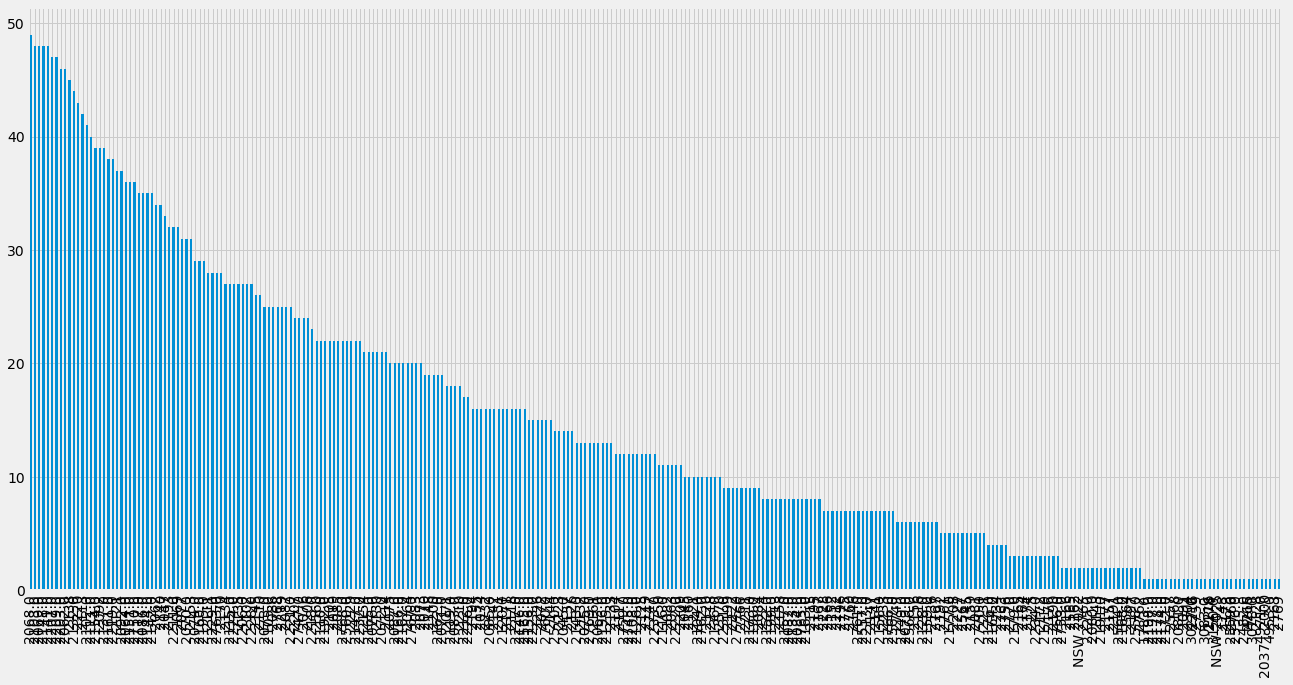

In [65]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 50].plot(kind="bar")

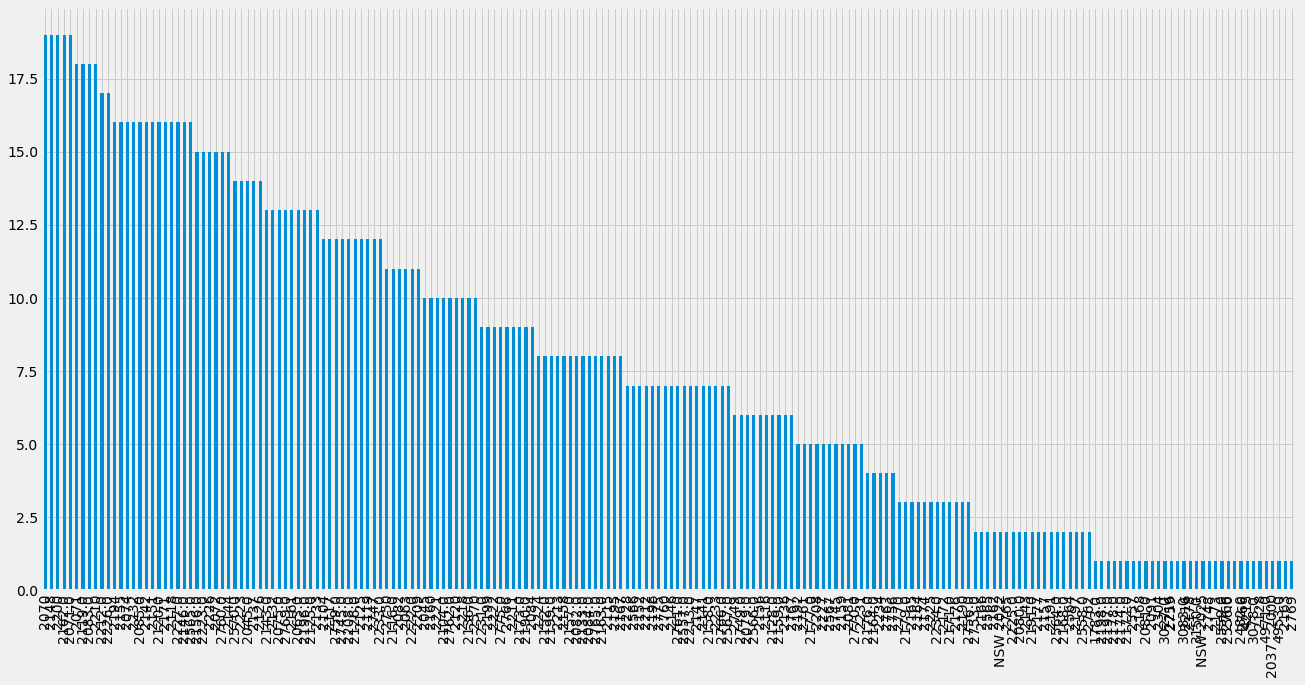

In [66]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 20].plot(kind="bar")

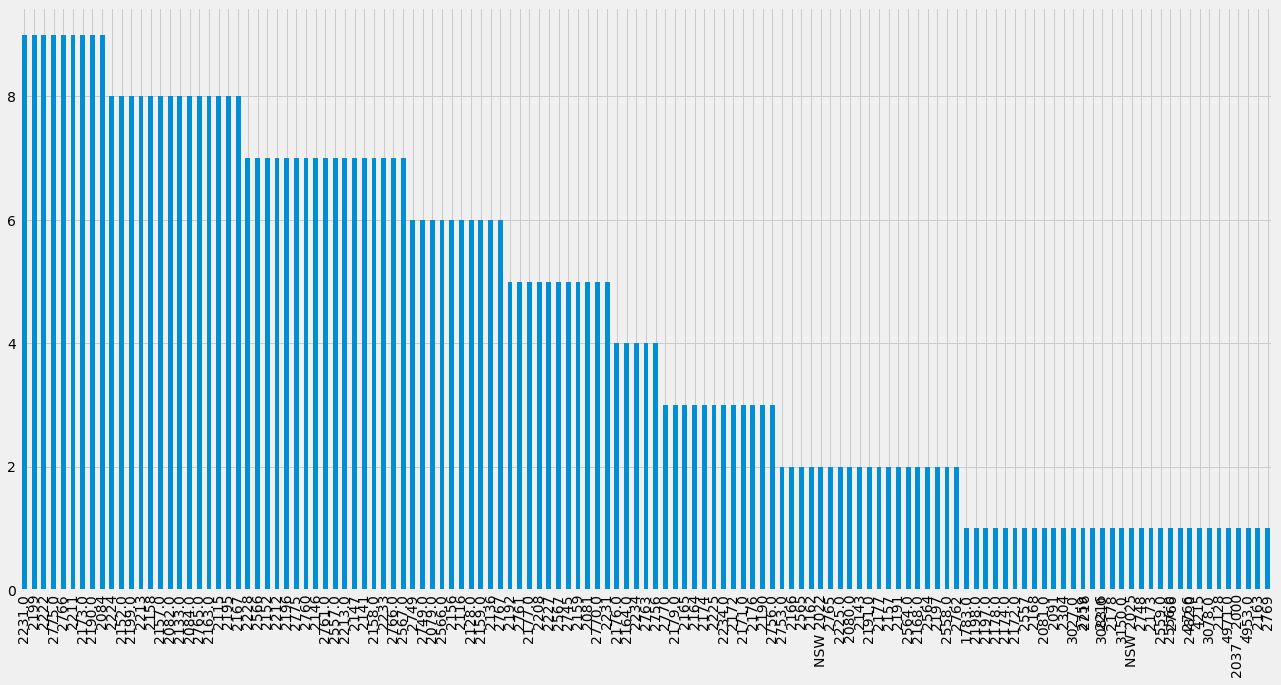

In [67]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 10].plot(kind="bar")

In [68]:
air_bnb.zipcode = air_bnb.zipcode.apply(remove)

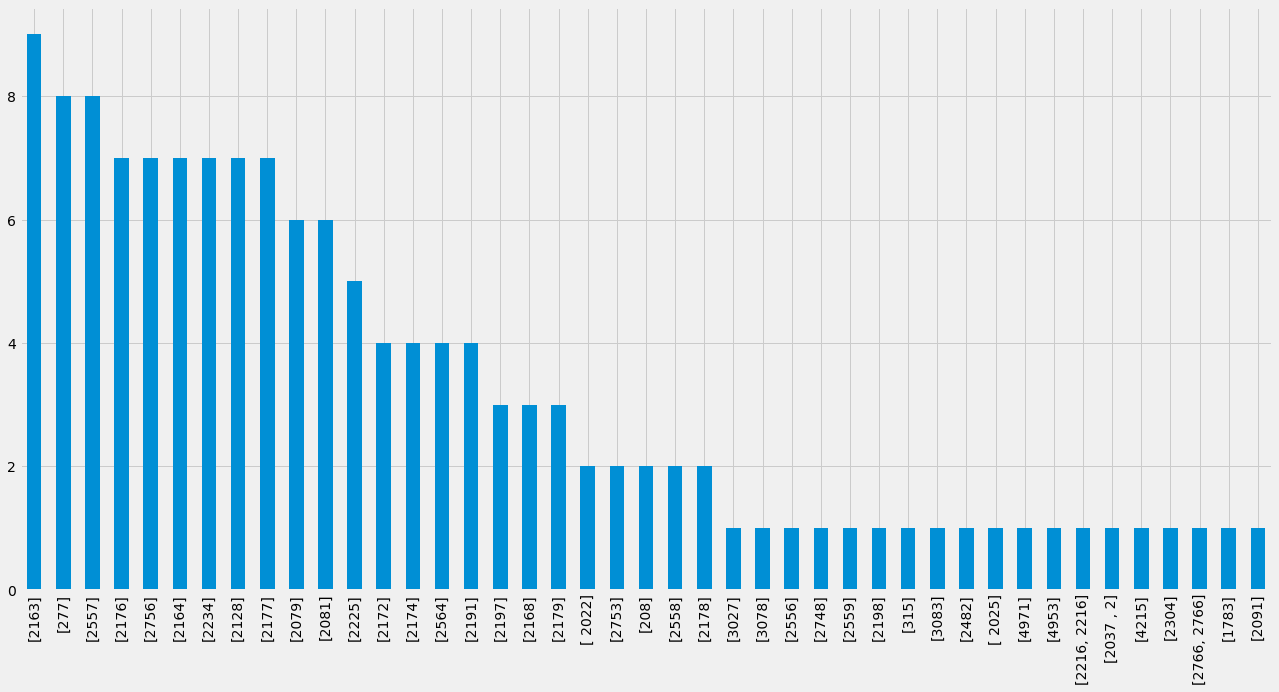

In [69]:
abz = air_bnb["zipcode"].value_counts()
abz[abz < 10].plot(kind="bar")

In [70]:
# # suburbs with least amount of airbnbs
# abz = air_bnb["zipcode"].value_counts()
# abz[abz > 10].plot(kind="bar")

In [71]:
air_bnb[air_bnb['zipcode']==1]['price'] 

Series([], Name: price, dtype: int64)

In [72]:
mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

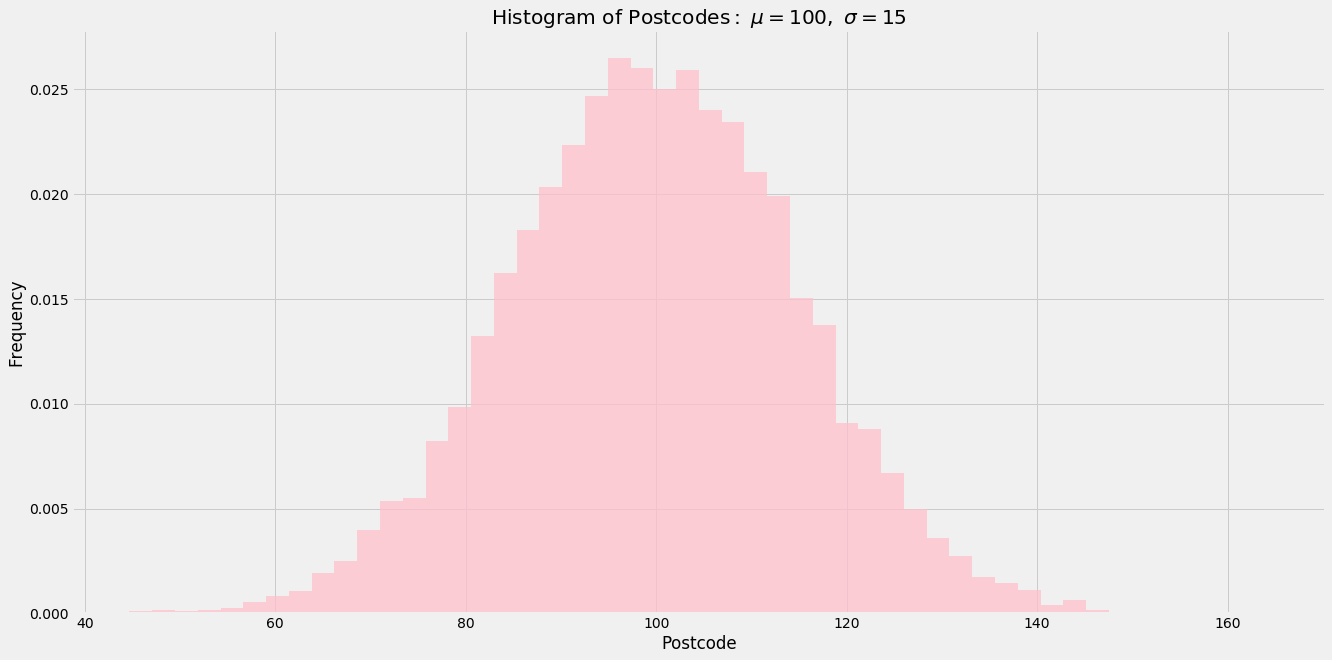

In [73]:
# the histogram of the data
plt.hist(x, 50, density=True, facecolor='pink', alpha=0.75)
plt.xlabel('Postcode')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ Postcodes:}\ \mu=100,\ \sigma=15$') # allows for latex formatting
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

## The amount of Airbnbs in NSW costing less than $200

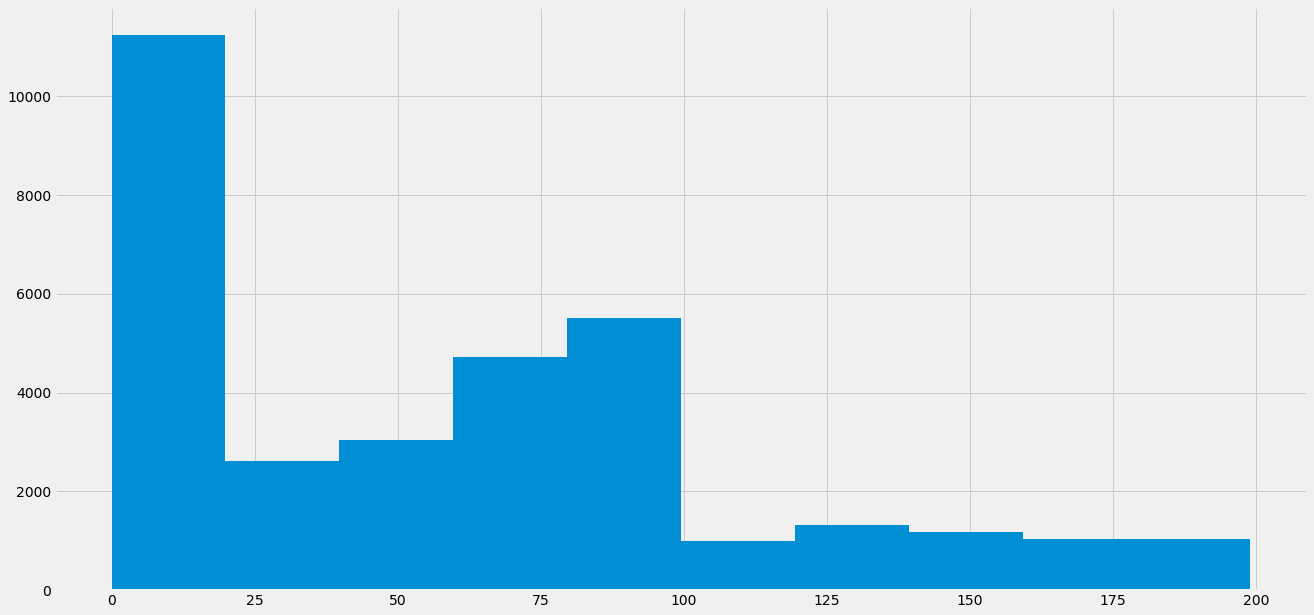

In [74]:
# amount of airbnbs with prices lower than $200
capped_price_data = air_bnb["price"][air_bnb["price"] < 200]

plt.hist(capped_price_data)
plt.show()

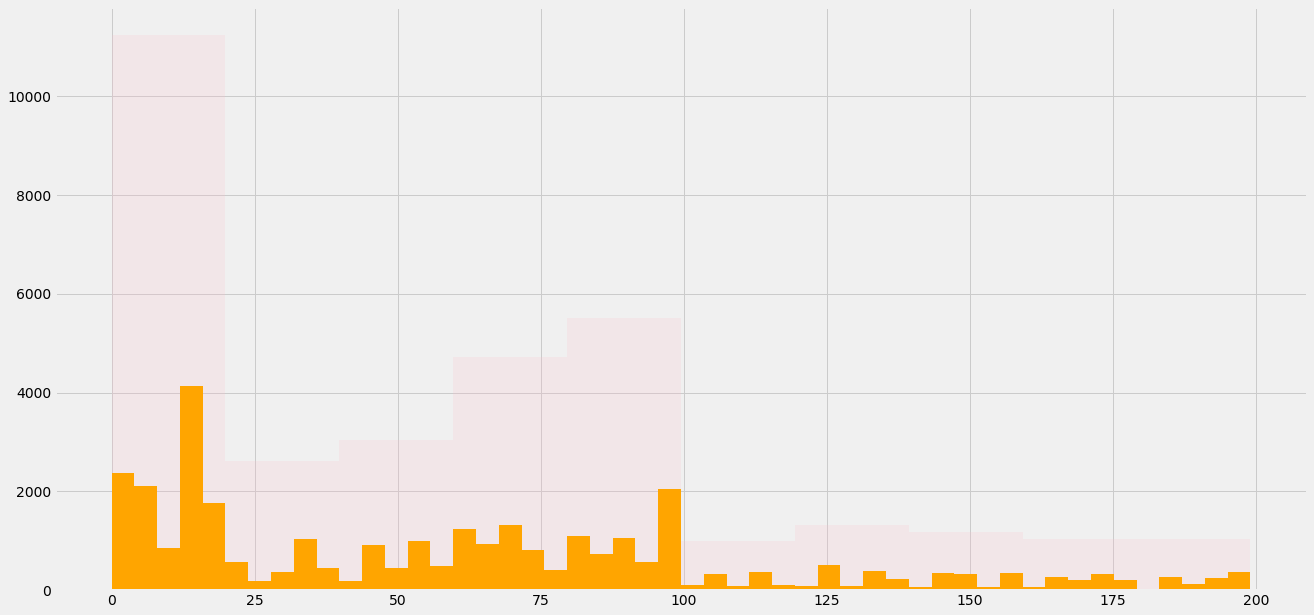

In [75]:
capped_price_data =air_bnb["price"][air_bnb["price"] < 200]

plt.hist(capped_price_data, bins=10, facecolor='pink', alpha=0.2) #<-old one
plt.hist(capped_price_data, bins=50, facecolor='orange', alpha=1)  #<-new one
plt.show()

## What's the average price of airbnbs in a suburb?

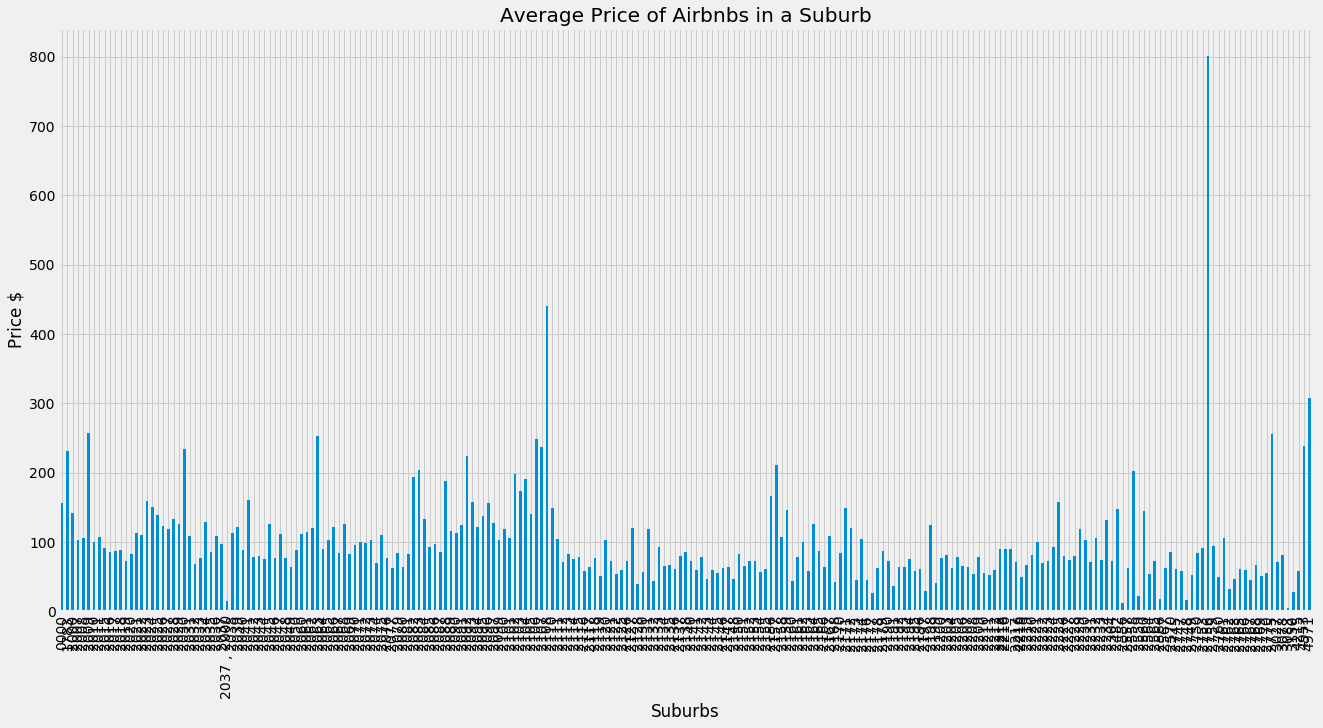

In [76]:
# the average price of airbnbs in suburb
average_price = air_bnb.groupby("simple_postcode").mean().price.plot(kind="bar")
# average price of suburbs
average_price.plot()
plt.title('Average Price of Airbnbs in a Suburb')
plt.ylabel('Price $')
plt.xlabel('Suburbs')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## Average number of people a house accomodates

Text(0.5, 0, 'ID')

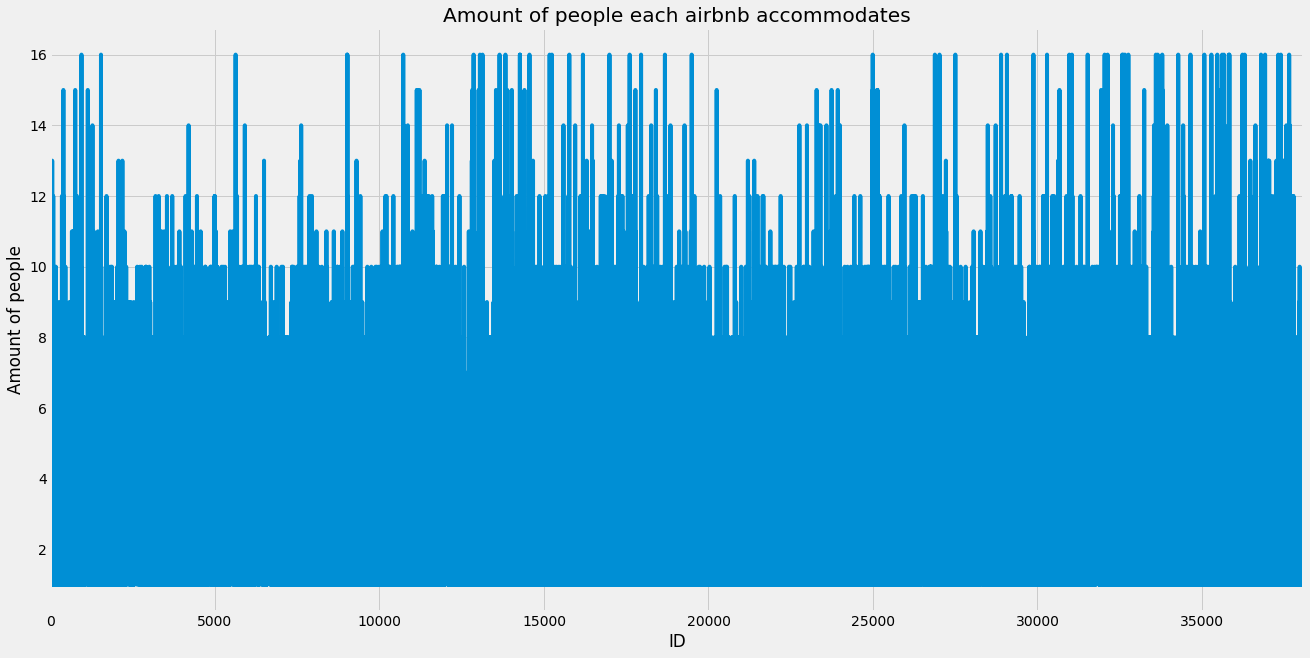

In [78]:
# how many people a house accommodates
air_bnb.accommodates.plot()
plt.title('Amount of people each airbnb accommodates')
plt.ylabel('Amount of people')
plt.xlabel('ID')

In [79]:
ac = air_bnb.accommodates.value_counts()
print(ac)

2     16204
4      7157
1      4098
6      3217
3      2377
5      1790
8      1452
7       691
10      471
9       285
12      120
16       62
11       61
14       39
13       29
15       27
Name: accommodates, dtype: int64


Text(0.5, 0, 'Postcode')

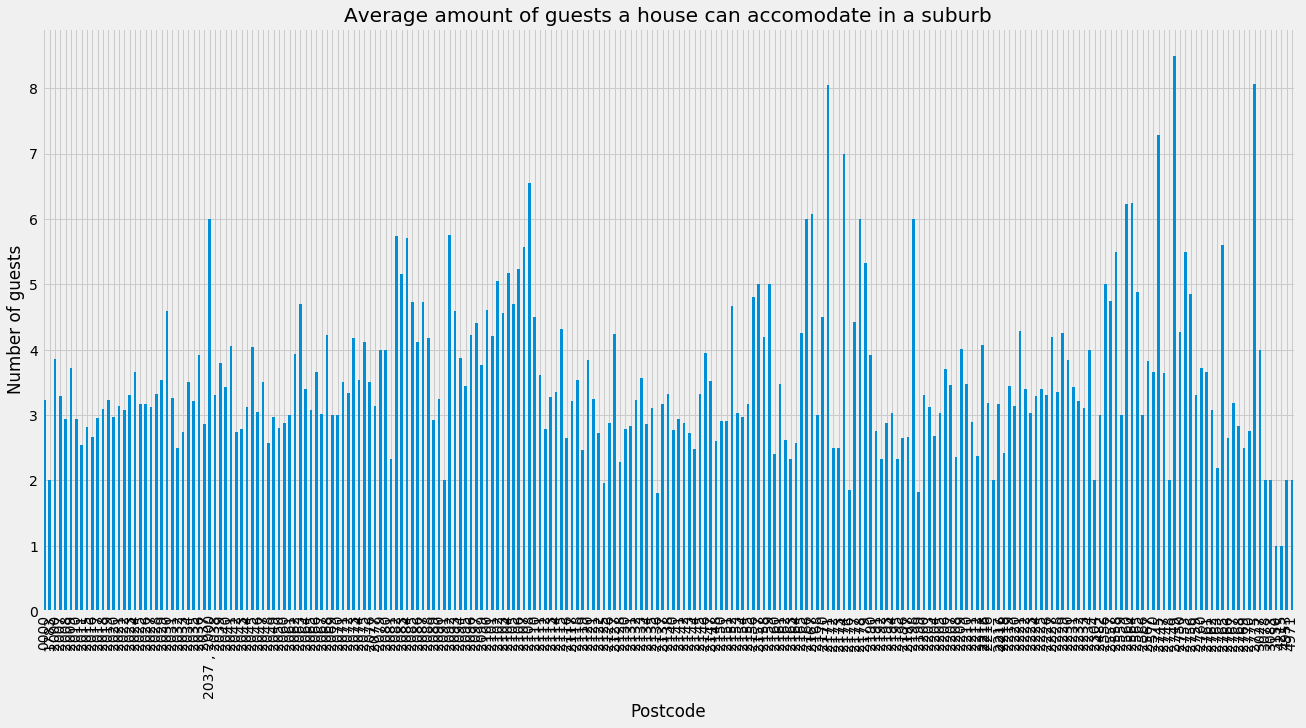

In [80]:
average_accomodates = air_bnb.groupby("simple_postcode").mean().accommodates.plot(kind="bar")
plt.title('Average amount of guests a house can accomodate in a suburb')
plt.ylabel('Number of guests')
plt.xlabel('Postcode')

### Grouping by postcodes

In [81]:
# groupby and aggregate 
# max or mean 
air_bnb_post = air_bnb.groupby(["simple_postcode"]).mean()

In [82]:
air_bnb_sum = air_bnb.groupby(["simple_postcode"]).sum()

In [83]:
air_bnb_sum.sample(5)

id          scrape_id  thumbnail_url  medium_url  \
simple_postcode                                                              
2191                77032461     80762840134068            0.0         0.0   
2020              8182858597   6683125021094127            0.0         0.0   
2082               340847741    383623490636823            0.0         0.0   
2095             24568968128  25399913222163576            0.0         0.0   
2223               543718911    585530590971993            0.0         0.0   

                 xl_picture_url      host_id  host_acceptance_rate  \
simple_postcode                                                      
2191                        0.0    288844778                   0.0   
2020                        0.0  37079661424                   0.0   
2082                        0.0   1113353976                   0.0   
2095                        0.0  70454357970                   0.0   
2223                        0.0   2176050603                   0.0   

                 host_listings_count  host_total_listings_count  \
simple_postcode                                                   
2191                             6.0                        6.0   
2020                          2351.0                     2351.0   
2082                            30.0                       30.0   
2095                         10735.0                    10735.0   
2223                            52.0                       52.0   

                 neighbourhood_group_cleansed     latitude     longitude  \
simple_postcode                                                            
2191                                      0.0   -135.59939     604.37938   
2020                                      0.0 -11229.40748   50043.85818   
2082                                      0.0   -638.15093    2871.41378   
2095                                      0.0 -42516.31838  190317.41146   
2223                                      0.0   -985.35637    4381.25142   

                 accommodates  bathrooms  bedrooms    beds  square_feet  \
simple_postcode                                                           
2191                       11        6.5       8.0     6.0          0.0   
2020                      986      424.5     429.0   536.0          0.0   
2082                      109       38.0      55.0    63.0          0.0   
2095                     4344     1669.5    2042.0  2518.0       1830.0   
2223                       88       33.5      46.0    52.0          0.0   

                  price  guests_included  minimum_nights  maximum_nights  \
simple_postcode                                                            
2191                146                4              90            2425   
2020              27295              528            1260          259133   
2082               3678               49              43           15872   
2095             172064             1913            6943          833740   
2223               2108               38             629           23815   

                 minimum_minimum_nights  maximum_minimum_nights  \
simple_postcode                                                   
2191                                 90                      90   
2020                               1252                    1296   
2082                                 43                      50   
2095                               6685                    7516   
2223                                628                     633   

                 minimum_maximum_nights  maximum_maximum_nights  \
simple_postcode                                                   
2191                               2425                    2425   
2020                             259133                  259133   
2082                              15872                   15872   
2095                             830205                  833678   
2223                              23815               

## Comparison of top 3 suburbs with most airbnbs and top 3 suburbs with highest income

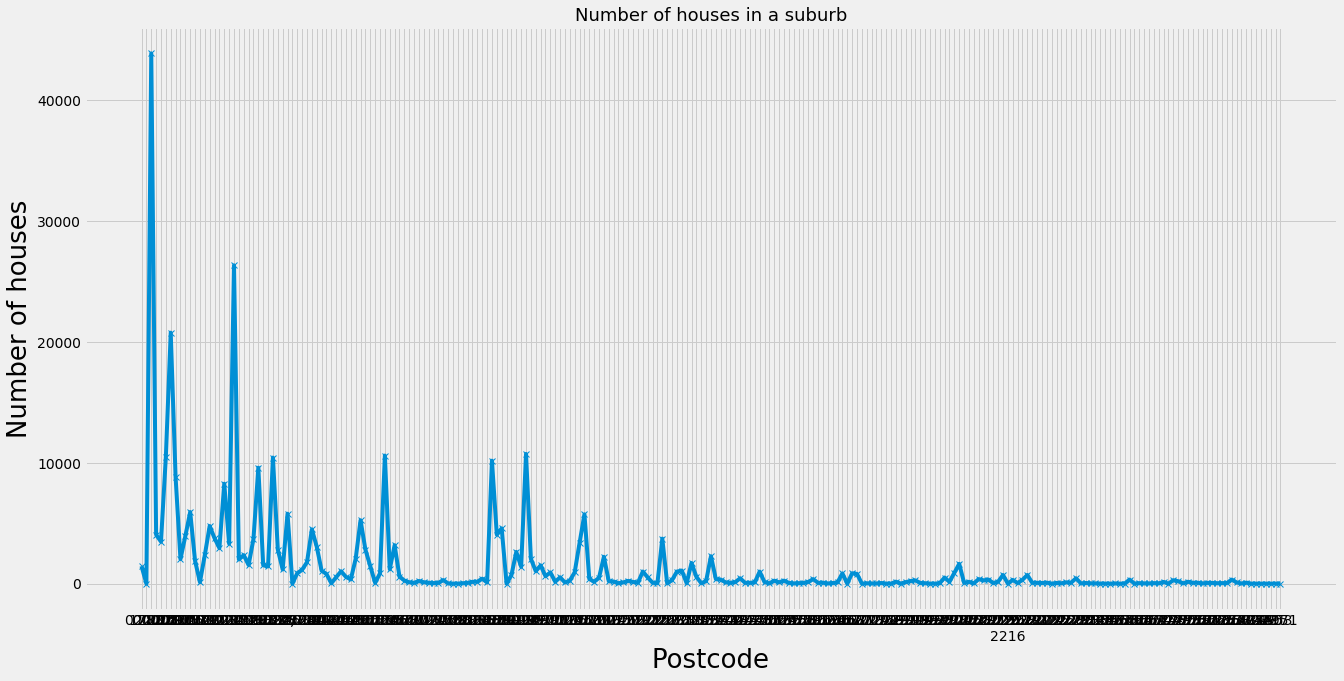

In [84]:
number_of_homes = air_bnb_sum["host_listings_count"]
# plt.xkcd()
plt.plot(number_of_homes, "x-")
plt.title("Number of houses in a suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Number of houses', fontsize=26)
plt.grid(True)
plt.show()

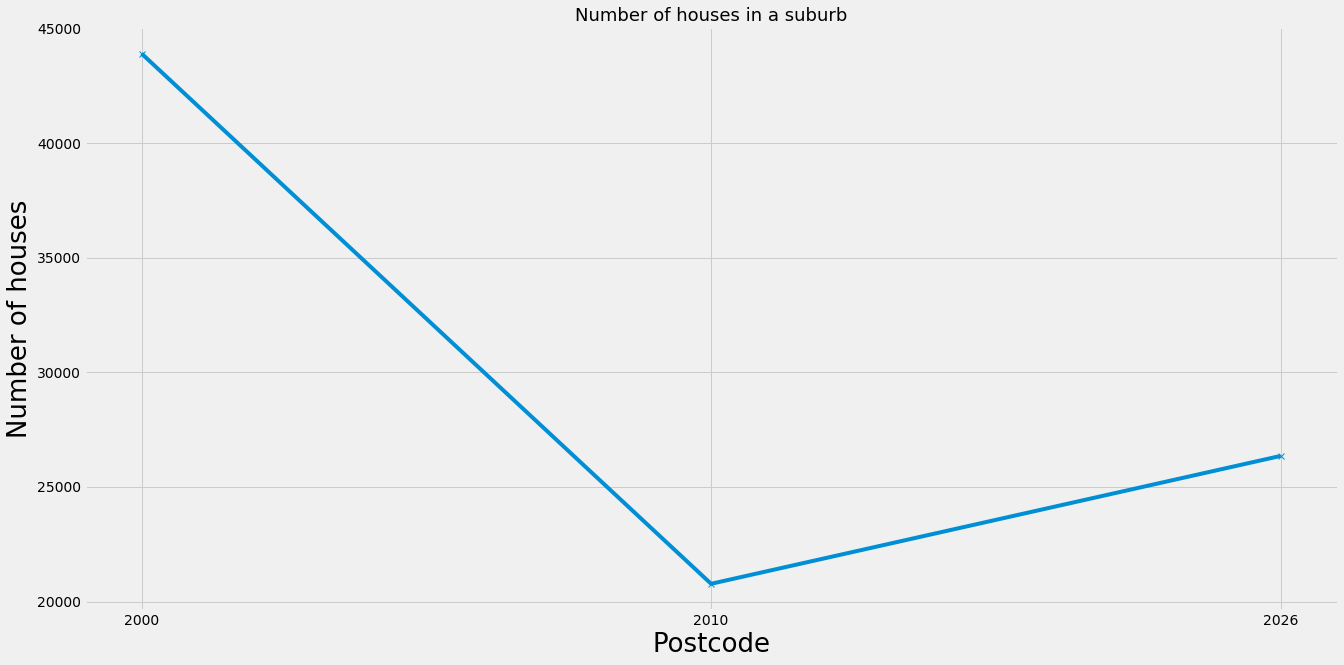

In [85]:
# shows the top 3 suburbs containing the most airbnbs
number_of_homes = air_bnb_sum.host_listings_count[air_bnb_sum.host_listings_count>int(20000)]
# plt.xkcd()
plt.plot(number_of_homes, "x-")
plt.title("Number of houses in a suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Number of houses', fontsize=26)
plt.grid(True)
plt.show()

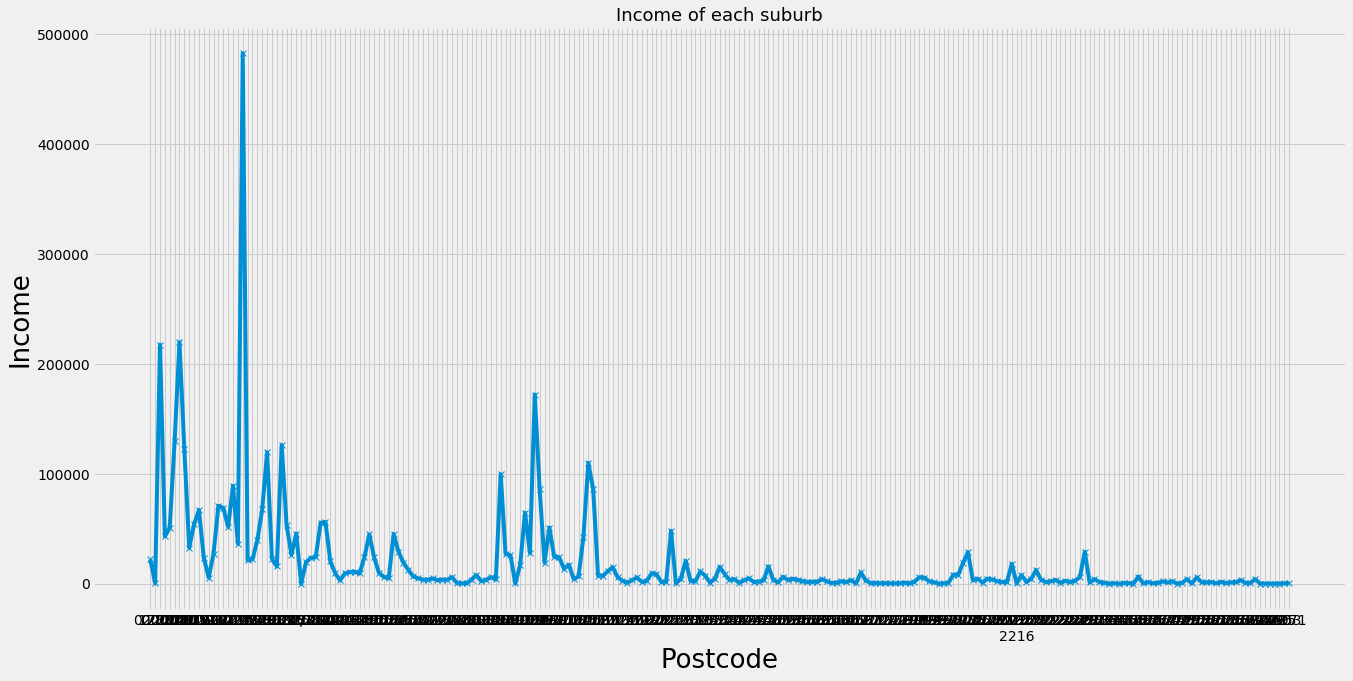

In [86]:
income = air_bnb_sum["price"]
# plt.xkcd()
plt.plot(income, "x-")
plt.title("Income of each suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Income', fontsize=26)
plt.grid(True)
plt.show()

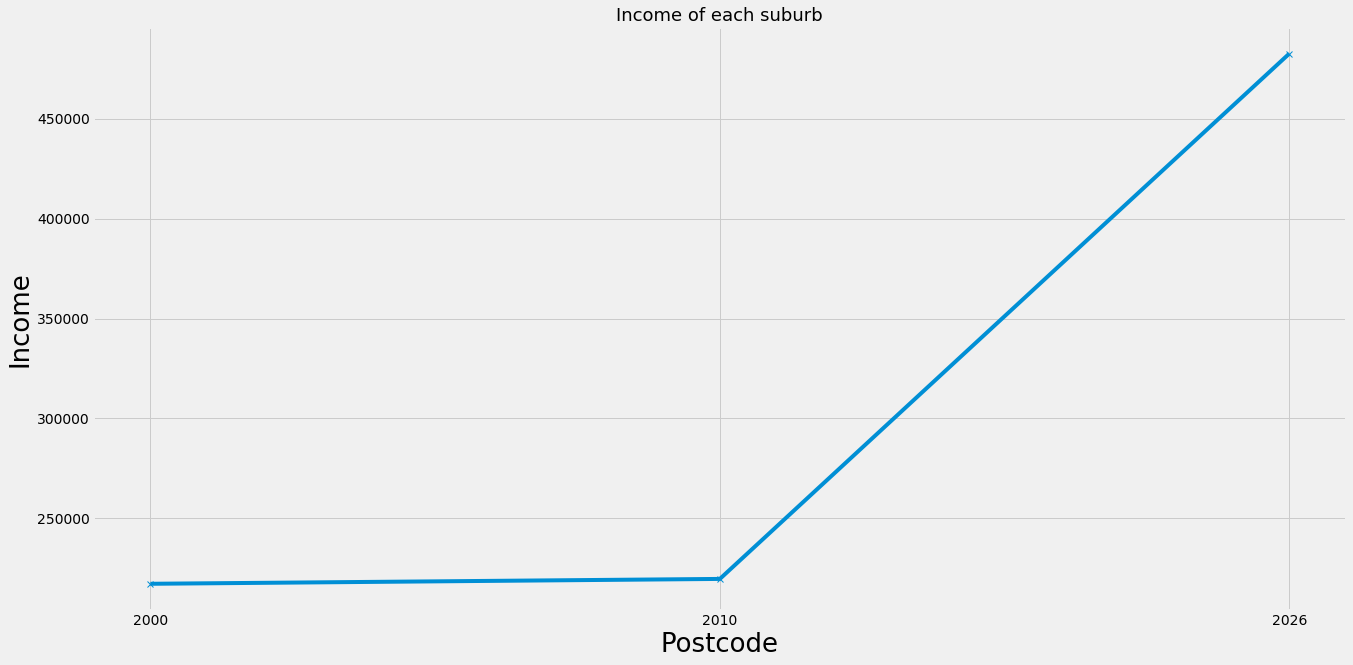

In [87]:
number_of_homes = air_bnb_sum.price[air_bnb_sum.price>int(200000)]
# plt.xkcd()
plt.plot(number_of_homes, "x-")
plt.title("Income of each suburb", fontsize=18)
plt.xlabel('Postcode', fontsize=26)
plt.ylabel('Income', fontsize=26)
plt.grid(True)
plt.show()

Postcode | Number of Houses in each suburb | Income
     --- | :---:                            | ---
2010     | 21000                           | $210000
2026     | 26000                           | $490000

## Are Airbnbs with Chinese characters in their description cheaper or more expensive?
> u'[\u4e00-\u9fff] searches for chinese and japanese characters in a string.

In [88]:
# Air_bnb's with chinese characters in their description 
import re
def find_chinese(row):
    for x in (row):
        if re.search(u'[\u4e00-\u9fff]', str(x)):
            print ('found chinese character in ' + str(x))
    return str(x)

find_chinese(air_bnb.description)

found chinese character in Top Floor City View Apartment–1 Bed Room + 1 Living Room + Enclosed Balcony. Swimming pool & Security Parking. 雪梨Burwood 全新大樓, 頂樓風景佳, 有游泳池. 400號公車直達機場, 歡迎日租/周末短租, 一房一廳,可睡3-4人,機場接送八折 1 double bed + 1 single bed to accomodate 3people. 4th guest will provide extra signle mattress without additional charge.Value accomodation. Free swimming pool , parking and internet Wifi. We can arrange airport service @ 20% off - $ 70 x 20% 0ff = $ 55 , pick up from Airport 15 mins pick up zone (5 seaters car). 機場接送八折優惠 Both Train & Bus to City & Airport. We can pre arrange Day Tour, Chinese Day Tour transportation $25 /PP, boarding from city. 可安排一日遊藍山, 車資25/人｡市價$39,$25 車資是旅行社收,司機當天會收$ 5 小費 + 景點門票 (看想参加那些景點)｡
found chinese character in The air-conditioned house studio flat is self-contained and has own entrance.  The kitchen in the extension is separated from the en-suite bedroom. FREE Wi Fi and plenty of free street parking. 度假享受,欢迎中文咨询 ｡ The studio flat has a separate kitchen

found chinese character in Our house is  nice and comfortable. 6min's walk to train station ,20_25 minutes to city centre , around 12minutes to both internatinal and domestic airport terminals. Plenty of free street parking.我们房子离国际机场仅8公里,火车6站既到,火车费用16澳币,打车机场到住宿45澳币左右｡到市中心的火车每15分钟一班,可直达歌剧院,情人港,唐人街等热点景点市中心,只需23分钟火车.从我们住宿步行到火车站7分钟｡我们最近的街上有各国的餐馆｡5分钟内可到购物超市,房内可煮食,厨具一应俱全｡ 如果你初来乍到,我们会给你一切力所能及的帮助｡欢迎光临｡
found chinese character in 【位置】Urbanest Darling Square 步行5分钟路程内:唐人街､Woolworth､Market city(内有超大华超)､UTS､达令港 【设施】健身房､洗衣房､自习区､电影房､游戏房､屋顶休闲区 【房型】19楼 单人间,独立卫浴,4人share厨房(有一位室友基本不使用厨房,相当于3人share)
found chinese character in 70平米标准一屋一厅,一个车位,位于购物中心对面,几分钟步行至火车站,非常方便安全｡中央空调,泳池,SPA,健身房,安静舒适便捷! 位于chatswood 购物中心对面,与购物中心分享一个停车出口｡距离chatswood 火车站步行几分钟可到,非常便利方便 有免费游泳池,SPA, 健身房,中央空调 与购物中心仅一步之遥,火车站几分钟步行可至 可以坐火车,bus 出行,
found chinese character in Hi, my name is Miria. I am the host of this apartment and I am an international students in Sydney. We are friendly and like to listen to your needs.  It's a comfortable mast

found chinese character in 这套豪华公寓位于悉尼休闲港湾温特沃斯区,热门住宅区之一,人称“第二个情人港”,绿茵水秀的绝佳环境,超大绿化面积,三面环水,紧邻帕拉马塔河,Bennelong大桥直通Rhodes区,同时极近奥林匹克公园,里面有各种类型的体育场馆及水上运动中心,经常会举办大型演唱会和体育赛事,近距离接触明星偶像｡ 房间为标准2室2卫超新公寓,有电视､空调､超快Wi-Fi等配套设施,公寓安保车位为您的爱车提供最安心的保障｡ 位于悉尼中心地带,不管是东到City,西至帕拉马塔,还是北上Chatswood,南下华人区Hurstville, 这都是您的最佳选择｡交通便利,步行800m可至渡轮码头,让你在浏览沿途风光的过程中轻松抵达悉尼歌剧院､情人港及其周边区域｡ 3分钟步行至多个公交站台,6-8分钟公交车程就可到Rhodes火车站或奥林匹克公园火车站,可前往悉尼各个区域｡ 生活方便,主街上有数家好评咖啡店,吃喝都很方便,公车20分钟范围不仅有澳洲连锁超市,还有IKEA, Costco等全球连锁大咖,最重要的是还有悉尼购物圣地DFO,各种大牌超低折扣,剁手党的最爱!! 房间为标准2室2卫超新公寓,最多可容纳6人居住,带有电视､空调､超快Wi-Fi等配套设施,公寓内的安保车位为您的爱车提供最安心的保障｡ 位于悉尼中心地带,不管是东到City,西至帕拉马塔,还是北上Chatswood,南下华人区Hurstville, 这都是您的最佳选择｡交通便利,步行800m可至渡轮码头,让你在浏览沿途风光的过程中轻松抵达悉尼歌剧院､情人港及其周边区域｡ 3分钟步行至多个公交站台,6-8分钟公交车程就可到Rhodes火车站或奥林匹克公园火车站,可前往悉尼各个区域｡
found chinese character in 位于Ultimo主干道Jones St上,坐落于公园旁边 环境清新干净,紧挨达令港､唐人街,交通便利 房子格局也很别致给您带来不一样的体验 一房一卫一厅,有独立的洗衣房､阳台,每天都阳光满满~ 独立的卫生间,带有按摩浴缸 房间与客厅分开,有大大的入墙衣柜可以储物 独立的洗衣房,宽敞的客厅,开放式式厨房操作台面可以煮饭 沙发､茶几､电视柜都有,暂无电视机 位于悉尼的核心区域Ultimo,公寓楼下是一个超大的公园,环境优美而安静,每天都能呼吸到最清新的

'nan'

In [89]:
def find_chinese(row):
    for x in (row):
        if re.search(u'[\u4e00-\u9fff]', str(x)):
            print ('found chinese character in ' + str(x))
            return True
    return False

In [90]:
air_bnb["Chinese_char_in_row"] = air_bnb.apply(find_chinese,axis=1)
air_bnb.sample(10)

found chinese character in Top Floor City View Apartment–1 Bed Room + 1 Living Room + Enclosed Balcony. Swimming pool & Security Parking. 雪梨Burwood 全新大樓, 頂樓風景佳, 有游泳池. 400號公車直達機場, 歡迎日租/周末短租, 一房一廳,可睡3-4人,機場接送八折
found chinese character in Holiday accommodation for large groups, families, and travelers. We welcome any guests who enjoy home-feel accommodation. My place is a home away from home. 

Selection of holiday homes:

- City Central Holiday Home (Surry Hills)  for up to 13 guests
- Family Home in Bexley (Sydney south) for up to 11 guests
- Garden House FLAT in Bexley for 5 guests
- Studio House FLAT in Bexley for 3 guests 
- Luxury Country Retreat in Robertson for 10 guests

Please refer to my website:
sy (Website hidden by Airbnb) 

我說廣東話和不標準的普通話｡
found chinese character in The air-conditioned house studio flat is self-contained and has own entrance.  The kitchen in the extension is separated from the en-suite bedroom. FREE Wi Fi and plenty of free street parking. 度假享受,欢迎中文咨询 ｡
foun

found chinese character in 広くて陽当たりの良いﾊﾞﾙｺﾆｰ､又は､ﾌﾟｰﾙｻｲﾄﾞでﾘﾗｯｸｽせ｡きます｡写真掲載あり｡
found chinese character in Hurstville 3 分钟火车站
found chinese character in Apartment is very neat and cosy, fully furnished, conveniently located near International Airport (12 min)and Sydney 's central attractions (26 mins) by train. - 3 mins walk to Riverwood station  - 2 mins walk to local shops, restaurants, cafes, pubs and supermarkets  - Have an underground lockup parking This apartment has everything you need to make your stay in Sydney comfortable and enjoyable. 公寓整洁舒适,设备齐全,交通便利,紧邻国际机场(12分钟)和悉尼中心景点(26分钟)｡ -步行3分钟至Riverwood火车站 - 2分钟步行至本地商店､餐厅､咖啡厅､酒吧及超级市场 -有一个地下禁闭停车场 这套公寓有让你在悉尼生活舒适和愉快所需要的一切｡
found chinese character in 合租公寓
found chinese character in Eastwood静街House,生活交通便利 难得好房
found chinese character in 8畳の個室(1名滞在用)
found chinese character in 安静安全的安居
found chinese character in • 入住时间是15:00｡ Please keep the apartment tidy & clean. Do not mesy on the wall. -Please do not walk in with shoes as there is brand new

found chinese character in Star Bay星月湾
found chinese character in Magical View + Convenient + Safe (说中文)
found chinese character in Hi guys!

My name is David. Thank you for clicking this page to know more about me. 

If you are planning to come to Sydney or Melbourne, Australia or Phuket, Thailand. WELCOME! and I am sure you will enjoy your journey. 

I am from property consulting background and I am just like you and the others here who like to travel and find a comfortable place to stay at a convenient location. When I go overseas and interstates, I spend hours and hours to search for accommodation. that's why I understand you and would love to help if I could make your stay a bit easier and more relaxed.

Feel free to send me a message. I look forward to hearing from you.

If you are home owners or hosts. I also provide cleaning, management and consultation service. Please do not hesitate to contact me.

Hello! 大家好!
我是David,謝謝你按進這一版來看我的自我介紹｡
我是澳籍華人,從香港多年前移民來到澳洲｡在悉尼居住了幾年｡

我和你一樣,喜歡旅

found chinese character in 绝佳的地理位置,到火车站学校均1分钟!4分钟大商场,短租2个月
found chinese character in Master room for Airbnb in a two bed room apartment with one Queen size bed and one extra sofa bed also own bathroom own key . Neat room comfortable to stay. Supply milk bread cereals for the breakfast to help yourself . if you need plate set breakfast there is extra charge please let the host know one day before, supply tea bags and kettles in the room. Also  welcome order dinner with extra charge . Supply towel ,tea coffee and blanket. Unlimited wifi with pin number ,supply blow dryer as well. Close to everything you might need for shopping or travel to city or other places. Easy catch trains or buses .see the whole views of city sydney from top roof . Watch sunrise and sunset ! Maximum stay 3 people but 1 adult male. 主人套房带钥匙和单独卫生间,位置极其便利到city或者购物中心附近有著名的百年公园,赛球场赛马场和西田购物中心,邦迪海滩汽车火车出租车步行即到出行方便,楼下有机食品店以及咖啡店各式餐馆,图书馆
found chinese character in 走路3分钟到火车站､BUS站,火车10分钟可以到达市中心的所有旅游点和政府､银行等｡公寓楼下有大型超市､各国餐厅､咖啡厅等

found chinese character in 我的房源靠近The University of Sydney,Ultimo,Glebe,Chinatown｡因为It is the student apartment and it is near the university of sydney,您一定会爱上我的房源｡我的房源适合独自旅行的冒险家和商务旅行者｡
found chinese character in We have a lovely  2 bedrooms granny flat in a picturesque,quiet and peaceful area to share with our guests for short or long term .A calm view to a leafy forest, Many colourful birds is inviting to unwind and relax. 700m walk from Hornsby station and Westfield shopping Mall. 33mins by train from Sydney CBD and two train lines to Sydney anywhere . Fully furnished granny flat. Big bed room :1 queen size bed,1big desk,and wardrobe. single bed room: 1 single size bed ,1 desk,and wardrobe. Lving room: table&4chairs,  Kitchen:stove,oven,kettle,kitchenware Beautiful pool views. 座落在早期意大利移民聚居的花园别墅｡ 1100平米的泳池花园别墅,森林围绕,清晨在鸟儿的歌声中开始新的一天｡ 步行700米可达hornsby火车站和shopping mall,shopping mall内有超过5家中国超市,为喜爱中餐的国人带来极大的方便｡更有诸多餐馆美食围绕,方便您品尝不同的异国风味｡33分钟火车可直达悉尼CBD,车程10分钟可达著名的库灵盖国家公园,车程30分钟可达北岸多个海滩,包括著名的曼利海滩｡

found chinese character in 室內請脫鞋.
found chinese character in 超级干净整洁步行6分钟到火车站30分钟到Brighton海边
found chinese character in 因为我不收清洁费,所以离开时请打扫干净房间
found chinese character in Near Roseville train station, less than 5 mins walk,15 minutes walk to Chatswood. good location to stay if you want to travel to Chatswood/City CBD. It is a very safe suburb ｡ 洗衣房,厨房,客厅,阳台｡ 会的 离Roseville火车站步行6分钟,离Chatswood火车站步行15分钟｡
found chinese character in 近Talor,city,UNSW主人房低价招租
found chinese character in 全新unit 主卧(独立卫浴)
found chinese character in 我的房源靠近The grounds of Alexandria, East village shopping centre, Green Square train station, Bus stops, Newtown｡因为地段､温馨､人,您一定会爱上我的房源｡我的房源适合情侣､独自旅行的冒险家､商务旅行者､有小孩的家庭｡
found chinese character in My place is close to 全新装修Apartment位于Arncliffe/wolli creek近机场 ,步行10分到超大Woolworths,Danmurphy和中国超市｡现有舒适double room出租,自带built in,unlimited internet,55寸大电视机 henrietta xu (Phone number hidden by Airbnb) , restaurants and dining, family-friendly activities.
found chinese character in ★Eastwood近

found chinese character in Contemporary townhouse near park and bus stop offers enviable lifestyle.  -a quiet, modern and oversize room -private bathroom,balcony and study space -double bed,table,desk,built-in wardrobes,unlimited wifi -secure visitor parking and street parking -indoor workout facility -shared gas stove cooking,laundry with just one couple -2 mins walk to park and 513,545 bus stop -15-20 mins bus to parramatta and macquarie university. 欢迎国内旅行的朋友
found chinese character in Near new two bedroom granny flat. Close to beach, train station, super market and westfield Miranda. 全新两室一厅独立房｡近海滩,大型商场,火车站和超市｡
found chinese character in 坐落在漂亮整洁的私家花园中｡热带雨林风情｡假山鱼塘｡有美丽的凉亭,BBQ可以享受｡
found chinese character in Hello, my friend! I have a part time job in 2019, but still working hard with all the rooms in my place,  Granville Townhouse  and my friend LiEr's room.

I worked in a league office before I came to AU and traveled a lot in west China specially in Tibet.  The most impress inn I eve

found chinese character in A peaceful and private studio located on ground floor with independent entrance and lock. Facing the garden, it has a large bedroom equipped with 1 double bed& 1 king single bed, the 2nd room equipped with 1 king single bed. Independent toilet/shower, hot water supply, a small kitchen. 15mins walking to Train Station/shopping mall, 2 mins to bus stops. Free parking and Wifi. The host is couple with kids living on the upper level. Perfect for 2-4 persons or family to stay. 房间安静整洁,配套齐全,欢迎入住!
found chinese character in 悉尼北区-独立水景Studio!
found chinese character in Newly renovated Sandstone terrace house right next to Star Casino Sydney, 5min walk to supermarkets Coles & IGA & Sydney fish market ,Sydney Pyrmont  bridge ; 10m walk to Darling Harbour ( 情人港)and Sydney International Convention Centre (ICC) and 15min walk to Sydney CBD ; Many great cafes and famous restaurants around;10min walk to Sydney Powerhouse Museum and Sydney Maritime Museum and Sea Life Sydney A

found chinese character in Rhodes High-grade neighborhood apartment 高层水景保安公寓
found chinese character in 本人住在澳大利亚悉尼,喜爱旅游,餐饮,和聚会
found chinese character in We are very down to earth people. We like meeting new people especially from all around the world. And we're very proud of the way we've designed our apartment and rooms. Each room has its own flavor and feel.

We want each guest arriving my place feeling safe, comfortable and relaxed while staying with me. We love making sure that's done the right way. So, we make sure everything is communicated before hand and leave our interactions up to you!

I can't live without good food, a nice cold beer, laughter, friends and family. Shirley loves sweets, singing karaoke, meeting new people and cats!! (but, we have no cats at home.)

公寓及各个房间风格完全是由我们自己设计的,这一点我们非常自豪~希望我们的公寓能给你们带来舒适､自在的享受｡若有任何疑虑,我们希望可以第一时间得到沟通以保证相互的理解｡

来悉尼需要任何建议的话,欢迎来询问我们喔!

found chinese character in -為节能环保以及不會產生過度使用電,氣問題,保障雙方利益,房客守則規定整租的用電量若超過9澳元房客需支付额外电费(澳洲平均4人住房用電量每日為7.2澳元)｡

found chinese character in This room has Separate outside entrance, own fridge, own microwave, NOT a share house. You get unlimited internet, hot water , washer, cooking ( outdoor only) Close to Blacktown station, Quakers Hill Station and buses. 20 minutes to parramatta. Walk to Coles, Woolworths, Subway, Pizza Hut, Macdonalds.  Please text Dona on (PHONE NUMBER HIDDEN)).  Very private and quiet. For a female only.  /部屋は別途ｴﾝﾄﾗﾝｽあり/ห้องพักมีทางเข้าแยกต่างหาก/
found chinese character in Waterside penthouse with exclusive view. Quiet location with beautiful view. A double room furnished with with a double bed. Sharing bathroom with one other residentaand share common living area. Close to Olympic park, Rhodes. Short stroll to the Rhodes shopping centre located across the river. Bus stops downstairs, and few minutes walk to train station to go to any where you like. Asian grocery shop, convenient store and few restaurant downstairs, with more option locates across the river. Share bathroom

found chinese character in 距离车站1分钟路程,通City的车每5分钟一班,四通八达, 方便去市中心,邦迪海滩,Eastgarden购物中心,机场等...... 步行3分钟到各种各样的餐厅,泰国菜日本菜中餐西餐,想吃什么吃什么｡ 步行至超市2分钟买回家里温馨做饭,经济健康又愉快!
found chinese character in Waterloo 短租 高层公寓次卧
found chinese character in Clean tidy and fresh apartment (English&中文)
found chinese character in This Apartment is located at Arncliffe suburb, which is abt 15 mins away from Syd CBD by train and 10 mins drive to Syd airport. 6 mins walk to local train station and bus stops. IGA, grocery stores and restaurants are also within walking distance.  The master room is fully furnished with 3door mirror wardrobe, private ensuite, 1double bed, desks/chairs, Mini bar, WIFI and balcony with a good view. Indoor swimmin pool, sauna, gym and BBQ area in the complex of the apt. are free to use. 可中文沟通
found chinese character in - 请保持安静,维护室内卫生,遵守入住以及退房时间｡入住时间为下午3点到9点,退房时间为上午10点前｡任何晚退房都会收取相应费用,请务必告知我｡谢谢!
found chinese character in - 不可以穿鞋入內
found chinese character in Strathfield, best location.  Direct to

found chinese character in Hi, my name is Miria. I am the host of this apartment and I am an international students in Sydney. We are friendly and like to listen to your needs.  It's a comfortable master room in a split level apartment. You can own a large balcony and suite private bathroom.  Welcome to Sydney! 欢迎广大中国旅客入住! 这是一个很舒适安全的主人房,拥有自己独立卫浴和大阳台｡同一房子住有友好留学生, 可以为您的旅程提供一定的咨询信息｡普通话广东话皆可｡
found chinese character in Comfy & Convenient apartment in the heart of the popular Burwood CBD with super easy access to a variety shopping centres, public transport and restaurants. Also included is a complimentary parking space. 15 Mins to Sydney CBD & 20 Mins to Sydney Olympic Park by public transport. Walking distance with super easy access to shopping centres such as Westfield and Burwood Plaza. Right next to public transport with both bus & trains and directly adjacent to a brand new Food Precint in the heart of this bustling town. 可以使用屋内一切提供的服务,但是不要破坏提供的服务和物品 Available for questions via Phone,

found chinese character in Anthony小屋
found chinese character in Sydney Burwood rent 出租
found chinese character in Sydney Burwood rent 出租
found chinese character in 清强
found chinese character in 近悉尼CBD和机场,整租分租均可.
found chinese character in 爱彼迎
found chinese character in Affordable apartment with city view 悉尼的温馨小窝
found chinese character in 悉尼Sydney市区Parramatta CBD 5 mins步行到火车站 20分钟到city
found chinese character in Sydney(悉尼市区)Chatswood(车士活)带花园独立双人房一间
found chinese character in Sydney(悉尼市区)Chatswood 花园别墅独立双人房一间
found chinese character in Your trusted international holiday rental host across major cities. Feel at home wherever you are! LIVE · LOVE · EXPLORE

- Melbourne
- Sydney
- Gold Coast
- Auckland
- London
- Da Nang
- Kuala Lumpur
- George Town
- Johor Bahru

I speak fluent English, Cantonese (广东话), Mandarin (普通话), Bahasa Melayu, Bahasa Indonesia & Tagalog.

If the dates you're after are available on my calendars, you may proceed to "INSTANT-BOOK" em'.

My calendars on AirBnb are alwa

found chinese character in 大家好,我们是一对来自中国的年轻夫妻,已经在澳洲定居｡我们喜欢旅游,也喜欢名宿这种有别于传统宾馆的住宿方式｡我们可以为您提供详细而地道的美食信息和旅游信息,让您的悉尼之旅温馨而难忘｡我们也希望结交更多的朋友,分享彼此的旅途见闻和不同的文化,同时能在您结束一天疲惫的旅程之后为您提供一个舒适的家｡
found chinese character in GREAT LOCATION & BRAND NEW modern and stylish apartment. Seconds to shops, cafes, and restaurants. 12 minutes walk to Hyde Park and CBD. Located at the heart of Darlinghurst which is well known for restaurants, bustling nightlife, and shopping. Minutes to Kings Cross station.  You will be sharing with host ,but you will have your own ensuite bathroom.  可以说中文
found chinese character in hurstville 进车站温馨大房
found chinese character in Hi 你好,我是Joseph欢迎关注我的小屋,希望你旅行愉快｡
found chinese character in Welcome to contact me anytime!  I am very responsive;) 可以國語溝通
found chinese character in 公寓
found chinese character in 中文房东
found chinese character in 全新公寓,有燃气炉,冰箱,烤箱,微波炉,洗碗机,面包机,热水壶,锅,碗,筷,叉子,刀子,洗衣机,干衣机,熨斗,吹风机｡
found chinese character in 戶外可吸煙｡
found chinese character in 为你优美而自豪
found chinese character i

found chinese character in Rosebery 公寓主卧,独立卫生间,开放式厨房,房间还有入墙式衣柜和全身镜;家具电器齐全;交通方便,去central20min､ 去UNSW 13min､悉大10min;Green square 火车站步行8min;小区门口有便利店,离商场2分钟车程｡ Master-room with private bathroom in Rosebery, 10mins walk to Taylor College, 30mins walk to UNSW,USYD,UTS. Morden kitchen, built-in wardrobe and full-length mirror in the room. Furniture and appliances provided. Convenient transportation, 20 mins bus to city. 10 mins bus to Unis, 8 mins walk to Green Square Station. 2 mins drive to shopping mall. Security guarded.
found chinese character in mascot 超低价奢华独立卫浴公寓一间主卧市区绝佳位置楼下火车站华人超市方便
found chinese character in 整个空间都属于客人,我们不会打找您｡ 若有任何需要,我们会即时停工协助｡
found chinese character in 悉尼市中心舒适两房两卫一厅整套精装公寓
found chinese character in 本人住在澳大利亚悉尼,喜爱旅游,餐饮,和聚会
found chinese character in 我诚意邀请你来到我这个安静舒适的家｡想象清晨第一缕阳光洒在床上,看到缓缓的河流与城市的交错,这就是位于Wentworth Point的水景房公寓｡既能触摸到悉尼大都市的气息,而又不受繁闹喧嚣地打扰｡ 这是一个水景房公寓,楼顶会有一个安静不受打扰的花园,远眺能看到悉尼CBD标志建筑｡ 房间配置空调,基本生活用品,屋主热情好客,有问必答,提供早餐供房客选择｡ 这里交通便利,楼下就是公交车站,走10分钟就是渡口可以之间出市区,也可以乘坐楼下直通

found chinese character in 一个爱旅游的瘦胖子,喜欢用脚来测量地球.对事物有非常严苛的要求,最讨厌那些不好吃的网红餐厅!
found chinese character in 迦南
found chinese character in 中央火车站步行3分钟 在唐人街 游泳池 健身房 楼下各种超市 餐馆
found chinese character in This brand new two-bedroom plus study apartment at higher level of the iconic Opal Tower in the heart of Sydney Olympic Park, is featured with modern design, luxurious fittings and panoramic view of Sydney Olympic Park and Stunning city views. 高层佳景公寓 (OP28) 这间全新的两室加书房公寓位于悉尼奥林匹克公园中心标志性建筑Opal Tower,房间设计现代,装饰豪华,一览悉尼奥林匹克公园的全景和令人惊叹的城市景观｡
found chinese character in 可随时致电｡如果遇到问题,请给予时间处理｡
found chinese character in wash dishes after using kitchen  do not make loud noise 使用完洗碗 不要太大噪音
found chinese character in 悉尼auburn双人房
found chinese character in 馨
found chinese character in Please took off shoes when come into the room.  Please clean dishes after using and take away rubbish when check out.  In the event of key lost, $400 charges will be applied ( No negotiation) 进屋请脱鞋,请把碗筷清洗干净, 离开时请把垃圾带走｡
found chinese 

租房咨询 V信号:cosyeasy
found chinese character in 悉尼豪宅民宿:超大私人独立房间,适合国内一家旅游居住,最多可住4个大人2个孩子,独立卫生间
found chinese character in Hi, I am Silvia and I've been a journalist for nearly 20 years. I interests include photography, traveling and reading. I enjoy meeting people from all different cultures.
I immigrated to Australia from China with my family in 2003. We currently live in Sydney. The man next to me on my profile picture is my husband, Ralph, and that was when we were Puffing Billy Steam Railway of Melbourne! We are happy to hosting visitors from all over the world. 
We dreamed of driving all across Australia before coming here, but currently we've only explored one tenth of this country, with much more adventures ahead of us. 

我是西尔维娅, 曾经在中国做过近20年的记者｡ 我的兴趣包括摄影､旅游和阅读和聊天｡ 我喜欢结识来自不同文化的人｡
2003年, 我们全家三口从中国移居澳大利亚,目前居住在悉尼｡ 我个人资料照片旁边的那个一脸幸福样的人是我的丈夫拉尔夫, 那是我们在墨尔本普芬比利蒸汽火车Puffing Billy拍摄的｡做Airbnb挣钱是一方面,但我们更开心的是能够为出门旅行的人们提供尽可能的帮助｡
在来澳大利亚之前, 我们有一个梦想, 驾车走遍全澳, 遗憾的是目前我们只探索了这个国家的十分之一, 你愿意和我们约起吗?  前面还有更多的冒险

found chinese character in 奈許
found chinese character in 悉尼独立HOUSE单间两人住宿
found chinese character in 我是一名刚毕业的女生,希望广交五湖四海的朋友｡我上传到有关房间的图片全部来自手机普通拍摄,没有经过任何处理和美化,我愿意展示最真的一面供大家参考｡空间宽敞明亮,整洁,绝对是性价比最高的家庭旅馆｡
found chinese character in 有问题随时打电话,  房东住得很近｡
found chinese character in 全新水景公寓,两房两卫,温馨舒适
found chinese character in Luxury Apartment near CBD & airport 说中文
found chinese character in 私享独特Talk to the stars while having a hot bath on your own balcony Experience the unique! A centre located Penthouse Studio with views to die for! Breath taking views both from studio and top Terrance! High secured Building +Free Parking  We offer late check out It’s in the middle of everything with train station, Club and Supermarket, cafes, medical center, local restaurants just doorsteps! Within 15mins to Syd Airport, Opera house, Harbour bridge and Westfield by train Walk to UTS and USYD
found chinese character in ##我們房子是三房兩衛....床位出租 走路火車站三分鐘,火車市區12分鐘 我們在Burwood 鮮芋仙CommBank 銀行斜對面,讓你每天趕搭火車上班不遲到,離city 市區也只要12分

found chinese character in Rouse hill  2 个单人房间 $72 每晚  两层楼大别墅,门前公交车站､对面超市､商店中心､各种餐馆､加油站等 去市区､每5-10分钟一趟,地铁走路10多分钟 ,地点极佳
found chinese character in 3 Big Rooms Rouse Hill breakfast included only $99 for 4-5 people  Two-storey big house ROUSE Hill, bus stop in front of the House, opposite supermarket, shopping Center,  restaurants, petrol statiomn  station  etc.  Bus trian even 5- 10 minutes to city parramatta Rouse Hill Center Blacktown excellent location . the house Spacious and bright, large, clean, tidy, bus stop, opposite supermarket train start on 26/05/19 4-5 my mob no is (Phone number hidden by Airbnb) bus stop in front of the House, opposite supermarket, shopping Center,  restaurants, petrol statiomn  station  etc.  Bus trian even 5- 10 minutes to city parramatta Rouse Hill Center Blacktown excellent location . park just in fornt my house 门前爬车位 in the my you can see Rouse hill village  Spacious and bright, large, clean, tidy, bus stop, opposite supermarket shopping center
found c

found chinese character in I'm running a travel company, you may ask me if you have any travel questions. I would like to provide the best accommodation for travelers. 
澳洲本土旅游公司 超低价一日游 应有尽有
澳洲本地房屋出租公司 服务于留学生
旅游咨询 V信号:travelequalway
租房咨询 V信号:cosyeasy
found chinese character in I'm running a travel company, you may ask me if you have any travel questions. I would like to provide the best accommodation for travelers. 
澳洲本土旅游公司 超低价一日游 应有尽有
澳洲本地房屋出租公司 服务于留学生
旅游咨询 V信号:travelequalway
租房咨询 V信号:cosyeasy
found chinese character in Zetland 宽敞明亮单间 独立卫浴 楼下就是Coles
found chinese character in I'm running a travel company, you may ask me if you have any travel questions. I would like to provide the best accommodation for travelers. 
澳洲本土旅游公司 超低价一日游 应有尽有
澳洲本地房屋出租公司 服务于留学生
旅游咨询 V信号:travelequalway
租房咨询 V信号:cosyeasy
found chinese character in City奢华别墅主人房master room独立整层空间
found chinese character in 我给我的客人个人空间,但在需要时可联糸我
found chinese character in 近UNSW以及coggee海滩,来旅游或留学不可错过的房间~
found chinese character in 双人房,

found chinese character in 名宿之王/ King
found chinese character in This private double room offers an one queen bedroom with private bathroom, washing machine and dryer. (will update pictures) Share an open style full kitchen with a dish washer & fridge, It is ideal for a couple. This cozy home is a country styled one level unit, the door open to the back yard and face to swimming pool, guests will share the pool, backyard, clothes line and Bbq equipment with host family member. Minimum guest number : 2 这是一个能住1-2人的空间,它是一个带独立卫浴的主人套房,拥有独立的洗衣机和烘干机
found chinese character in Clean and comfortable double room, contains 2 single bed, wardrobe, desk. Offers fresh quilt cover, sheet & pillowcases to every new guest, also offers shampoo, condition, shower gel and body lotion. Share bathroom and kitchen. The guests share the pool,backyard, patio, clothes line with host family. 这是一个离 Chatswood 非常近的安静住宅区,距离Sydney市中心约10公里｡House后门出去,Park Ave 街的另一端约700m,是 Roseville Golf Club｡ 走路去Roseville火车站15分钟,2分钟走路到

found chinese character in 超大单间招租!近火车站!近医院!近商场!
found chinese character in 华美之家
found chinese character in 全新独立两房水景公寓
found chinese character in 如果自己做饭需要清洁自己的碗筷,需要保护好公寓内的所有物品包括高级电器和电子用品, 这间卧室最多只能住2个人,如果需要住第三个甚至更多,请提前联系我,我会安排书房和客厅的床位,每位需要AUD50每个晚上
found chinese character in 5至10分钟步行路程到中央火车站central station｡ 小区楼中有4小时免费的访客车位｡ 机场打UBER 至小区只需30AUD左右｡ 小区位于市中心繁华地带,但是闹中取静,即方便快捷又给您一个安逸舒适的休息环境｡ 如果有任何问题可以随时联系房东,我们会尽快解答您的问题｡
found chinese character in Hi guys!

My name is David. Thank you for clicking this page to know more about me. 

If you are planning to come to Sydney or Melbourne, Australia or Phuket, Thailand. WELCOME! and I am sure you will enjoy your journey. 

I am from property consulting background and I am just like you and the others here who like to travel and find a comfortable place to stay at a convenient location. When I go overseas and interstates, I spend hours and hours to search for accommodation. that's why I understand you and would love to help if I could make your stay a b

found chinese character in 华彩之家,Hua Cai Home(1)
found chinese character in 环境优美,出行便捷,安全免费停车位, 房间整洁宁静,友善房东｡ 去蓝山的必经之路｡ 附近有动物园,公园,可以垂钓,观鸟,烧烤,散步｡儿童乐园｡近2大超市｡ Loving and quite place. Easy access to everywhere. free parking space. Nice landlord. On the way to Blue Mountain. Next to Playground, public park, fishing, BBQ place, Bird view.  Close to Woolworth and Coles.
found chinese character in 3. 悉尼Darling Harbor master bedroom, AUD $99
found chinese character in 豪华美宅独立房间
found chinese character in 豪华美宅独立房间
found chinese character in It is a cosy home, for either business travelers, or family and friends. It is not luxury big space, but good enough for you to enjoy your own time. There is a big back yard with grass to give you some space away from city busy life. For those business travelers, a office table is available for your work or study. The self contained granny flat is second storey of a house with a separate entrance.  Landlord living in ground floor in separated space. However landl

found chinese character in 贵妃滨水山庄
found chinese character in 这是一个交通便利的幽静温馨度假小屋,位于国家森林公园附近,步行6分钟到火车站,步行8分钟到bus站,乘坐火车20分钟到市中心CBD,车程12分钟到达附近美丽海滩Cronulla beach,附近拥有众多便利店和餐馆,距离大型购物中心Westfield5分钟车程,饮食购物游玩一条龙非常方便,可提供8人座租车业务,并有优惠接送机服务｡ 这是您值得信赖贴心的出门小秘书｡
found chinese character in 北悉尼精致生活·风味美食佳肴尽在北悉尼
found chinese character in 卓然
found chinese character in LOCATION! Luxury private room in Burwood 网红狗の家
found chinese character in Hello/ 你好/Halo!

Travelling and writing are my biggest passions in life. I try to travel out of the country as much as I can, and hope to fill up as many travel logs as possible. 

To me, the essence of travelling lies in the possibilities of meeting new people, immersing myself into foreign cultures, and building lasting global friendships.
found chinese character in Wiley Park House 交通方便,近火车站
found chinese character in 宝之小屋
found chinese character in 私たちが住んでいる"Belhaven"ﾌﾗｯﾄは､ﾏﾝﾘｰのFederation Pointにあり､建物の前庭からはｼﾄﾞﾆｰﾊｰﾊﾞｰやｼﾄﾞﾆｰの湾頭を眺めることが出来ます｡ﾌﾗｯﾄを私たちとｼｪｱする形で､2ﾍﾞｯﾄﾙｰﾑの1室がｹﾞ

found chinese character in 帅
found chinese character in Central park高档公寓近一切
found chinese character in Feel free to contact me, if you have any question. Mobile: + (Phone number hidden by Airbnb)   (Email hidden by Airbnb)  Languages: English, Mandarin, Cantonese英語, 國語, 廣東話.
found chinese character in Brand New 2 bedrooms apartment near Hurstville CBD, airport & 15 mins by express train to Sydney CBD 度假享受,欢迎中文咨询 ｡
found chinese character in 祺慧 Finn
found chinese character in Kensington 公寓 走路十分钟到unsw 350九月前短租 之后也可以长租三室二卫无厅房
found chinese character in Golden sunflower (金阳花)
found chinese character in 海边两房公寓 City和悉尼大学旁 交通便利 旁边有商场
found chinese character in 西悉尼大学附近别墅大房
found chinese character in Feel free to contact me, if you have any question (Phone number hidden by Airbnb) Ken   (Email hidden by Airbnb)  Languages: English, Mandarin, Cantonese英語, 國語, 廣東話.
found chinese character in Granville station 3mins Apartment 独立房间含卫生间
found chinese character in Convenient 3 bedroom, 2 bath/rm. 方便的

id                            listing_url       scrape_id  \
10283  14256153  https://www.airbnb.com/rooms/14256153  20190710033517   
2829    4873978   https://www.airbnb.com/rooms/4873978  20190710033517   
35629  34850833  https://www.airbnb.com/rooms/34850833  20190710033517   
22151  23501208  https://www.airbnb.com/rooms/23501208  20190710033517   
11759  15902664  https://www.airbnb.com/rooms/15902664  20190710033517   
16600  20445364  https://www.airbnb.com/rooms/20445364  20190710033517   
24927  26531526  https://www.airbnb.com/rooms/26531526  20190710033517   
5894    9314553   https://www.airbnb.com/rooms/9314553  20190710033517   
29407  30335203  https://www.airbnb.com/rooms/30335203  20190710033517   
14868  18618903  https://www.airbnb.com/rooms/18618903  20190710033517   

      last_scraped                                               name  \
10283   2019-07-10      Sunny Double Bay apartment with harbour views   
2829    2019-07-10                   Bondi Beach /  French Beach Chic   
35629   2019-07-10  Lovely home with large backyard and swimming pool   
22151   2019-07-10    Natural Light North Bondi Modern Unit w Parking   
11759   2019-07-11                      The WATERLILY- Floating Oasis   
16600   2019-07-10              Spacious room very close to the city!   
24927   2019-07-10     Sydney. Northern Beaches Apartment, Narrabeen.   
5894    2019-07-10  Relax to the Sound of the Ocean from a Beachsi...   
29407   2019-07-10                 Entire flat close to CBD & Beaches   
14868   2019-07-11          One bedroom flat all to yourself - Bronte   

                                                 summary  \
10283  Our beautiful 2 bedroom apartment is in stylis...   
2829   Dudley Street, Bondi Beach.....This light and ...   
35629  Stunning family home with a spectacular back g...   
22151  A bright, light-filled bohemian styled apartme...   
11759  My place is on Pittwater, close to Church poin...   
16600  Large room with double bed and ensuite. You're...   
24927  Lovely, light-filled upper duplex within walki...   
5894   Autumn Specials. Relax on the balcony with lov...   
29407  One bedroom apartment in Alexandria. It's spac...   
14868  My cute apartment is located 5mins walk from B...   

                                                   space  \
10283  Our 6th floor apartment is bright and spacious...   
2829   Your Luck is here.... This is apartment is loc...   
35629  This home has a tranquil resort feel with its ...   
22151  Located on the 2nd floor and accessible by a l...   
11759  This Floating house available to Book from Jan...   
16600                                                NaN   
24927  The apartment is roomy and light-filled, with ...   
5894   This light and airy apartment will help you un...   
29407  Place is simple, has all appliances you might ...   
14868  My apartment is well located, close to Bondi J...   

                                             description experiences_offered  \
10283  Our beautiful 2 bedroom apartment is in stylis...                none   
2829   Dudley Street, Bondi Beach.....This light and ...                none   
35629  Stunning family home with a spectacular back g...                none   
22151  A bright, light-filled bohemian styled apartme...                none   
11759  My place is on Pittwater, close to Church poin...                none   
16600  Large room with double bed and ensuite. You're...                none   
24927  Lovely, light-filled upper duplex within walki...                none   
5894   Autumn Specials. Relax on the balcony with lov...                none   
29407  One bedroom apartment in Alexandria. It's spac...                none   
14868  My cute apartment is located 5mins walk from B...                none   

                                   neighborhood_overview  \
10283  Double Bay is a stylish harbourside enclave fe...   
2829   icebergs m deli cafe bondi beach tamarama beac...   
35629  The 

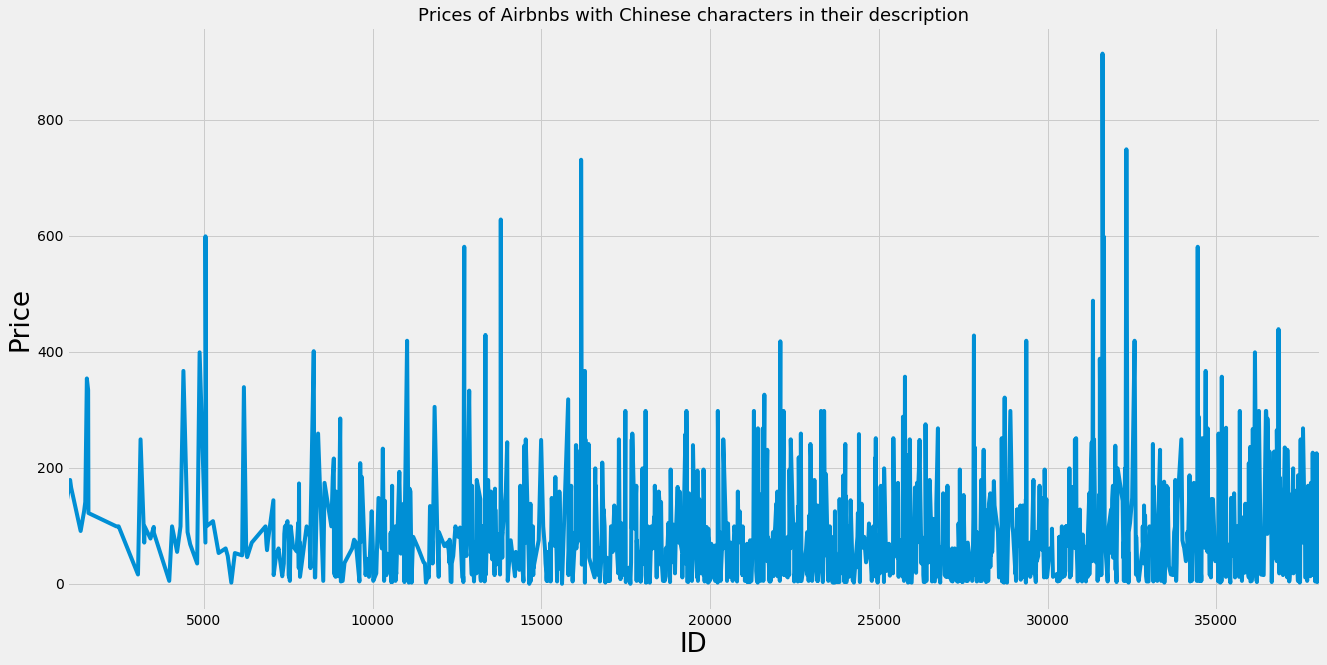

In [91]:
# summing up the prices for airbnbs with chinese description
# a file of all the airbnbs with chinese characters 
chairBNB = air_bnb[air_bnb["Chinese_char_in_row"]]
# plotting the price and ID of Air-bnbs
chairBNB.price.plot()
plt.title("Prices of Airbnbs with Chinese characters in their description", fontsize=18)
plt.xlabel('ID', fontsize=26)
plt.ylabel('Price', fontsize=26)
plt.grid(True)
plt.show()

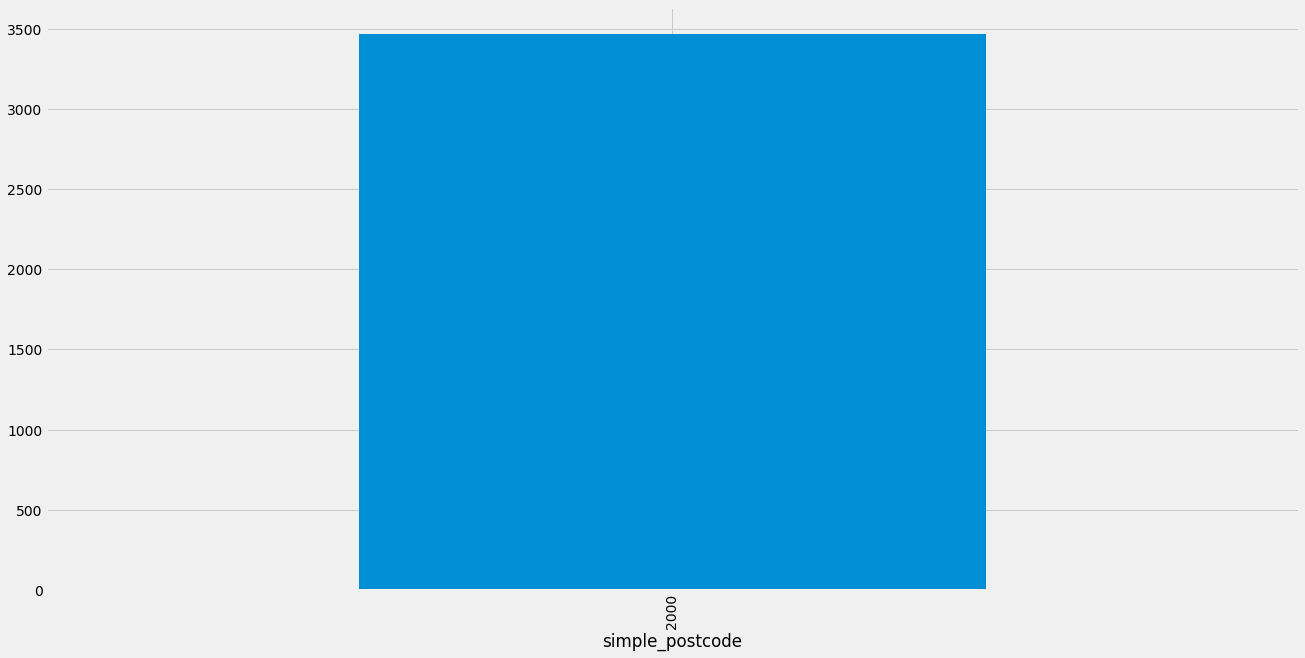

In [92]:
# Which suburb has the most houses with chinese descriptions?
chairBNBpost = chairBNB.groupby("simple_postcode")
cbs = chairBNBpost.host_listings_count.sum()
cbs[cbs>2000].plot(kind="bar")

In [93]:
# average price for airbnb with chinese characters in description 
chairBNB.price.mean()

85.62706043956044

In [94]:
# no chinese characters in description
def find_english(row):
    for x in (row):
        if re.search(u'[\u4e00-\u9fff]', str(x)):
#             print ('found chinese character in ' + str(x))
            return False
    return True

In [95]:
air_bnb["No_chinese_char_in_row"] = air_bnb.apply(find_english,axis=1)
air_bnb.sample(5)

id                            listing_url       scrape_id  \
3586    5993432   https://www.airbnb.com/rooms/5993432  20190710033517   
1246    2420697   https://www.airbnb.com/rooms/2420697  20190710033517   
36544  35546104  https://www.airbnb.com/rooms/35546104  20190710033517   
19463  21990852  https://www.airbnb.com/rooms/21990852  20190710033517   
8291   11624980  https://www.airbnb.com/rooms/11624980  20190710033517   

      last_scraped                                               name  \
3586    2019-07-10                    Art-Deco In The Heart of Sydney   
1246    2019-07-10  Contemporary large space - very stylish apartment   
36544   2019-07-10  ⭐️Luxury Darling Harbour Apt in the ❤️ Sydney CBD   
19463   2019-07-10  Bedroom Potts Point 3Level Terrace Private Roo...   
8291    2019-07-11                Sunny room facing garden for couple   

                                                 summary  \
3586   This charming 1 bdr apt has it all. Minutes wa...   
1246   Terrace style apartment delivers a tranquillit...   
36544  This amazing 2 bedrooms apartment is located i...   
19463  You'll love our spacious and homely 3 level te...   
8291   Private and spacious furnished room in a subur...   

                                                   space  \
3586   Right in the heart of inner, east Sydney. Surr...   
1246   Generous living and dining areas flowing throu...   
36544  Living room is furnished with modern and sleek...   
19463  Our place is quite spacious considering it’s c...   
8291   This is your own large furnished double bedroo...   

                                             description experiences_offered  \
3586   This charming 1 bdr apt has it all. Minutes wa...                none   
1246   Terrace style apartment delivers a tranquillit...                none   
36544  This amazing 2 bedrooms apartment is located i...                none   
19463  You'll love our spacious and homely 3 level te...                none   
8291   Private and spacious furnished room in a subur...                none   

                                   neighborhood_overview  \
3586   Gyms are a 1 minute walk away, mention you are...   
1246   Alexandria  is a groovy suburb that is bordere...   
36544  Neighbouring Darling Harbour and Haymarket, Da...   
19463                                                NaN   
8291                    friendly and quiet neighbourhood   

                                                   notes  \
3586                   There is a fridge but no freezer.   
1246   There is always plenty of tea and coffee in th...   
36544  This complex is brand new, the security is ver...   
19463  Light sleepers please note that there are bars...   
8291   The door between this room and the lounge is c...   

                                                 transit  \
3586                                                 NaN   
1246   Buses and trains minutes away to both beach or...   
36544  By train, bike, car, light rail or by foot, it...   
19463                                                NaN   
8291   - 1 min walk to bus stops - 3 min walk to mult...   

                                                  access  \
3586   Access to the apartment and the downstairs lau...   
1246   Guests have access to all areas during your st...   
36544  Other than the entire apartment, you can enjoy...   
19463  Guests have access to all 3 levels of the hous...   
8291   free fast cable Internet with Wi Fi, lounge, k...   

                                             interaction  \
3586   Happy to help decipher the massive selection o...   
1246   Contactable by phone during your stay or I wil...   
36544  My partner and I are here to guide you through...   
19463                                                NaN   
8291   We provide our guests with the most privacy wh...   

                                             house_rules  thumbnail_url  \
3586   I've just moved out with my partner but

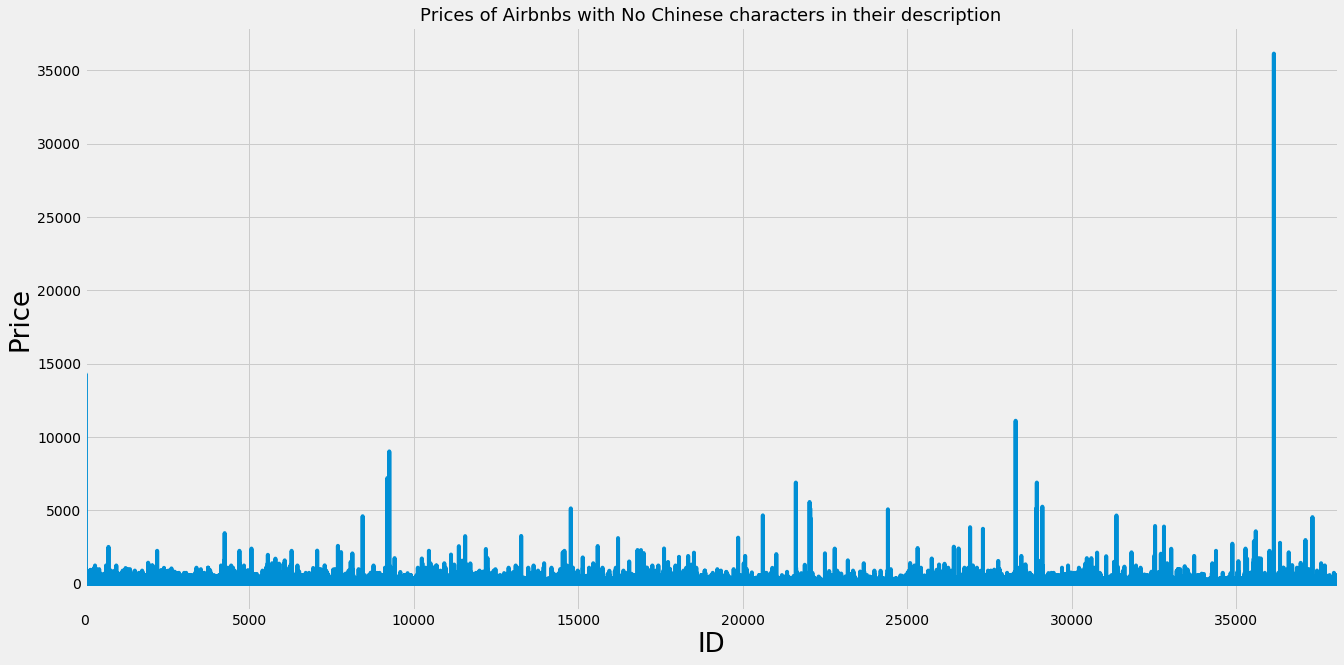

In [96]:
nochairBNB = air_bnb[air_bnb["No_chinese_char_in_row"]]
# plotting the price and ID of Air-bnbs
nochairBNB.price.plot()
plt.title("Prices of Airbnbs with No Chinese characters in their description", fontsize=18)
plt.xlabel('ID', fontsize=26)
plt.ylabel('Price', fontsize=26)
plt.grid(True)
plt.show()

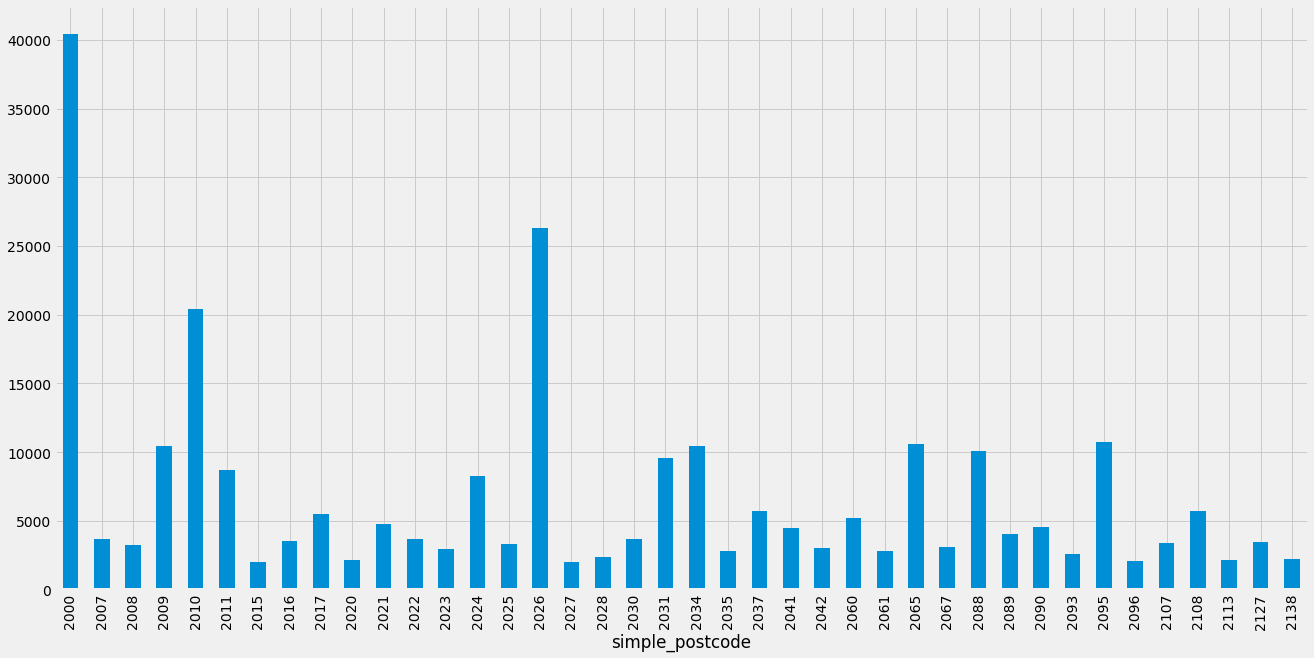

In [97]:
# Which suburb has the most houses with english descriptions?
nochairBNBpost = nochairBNB.groupby("simple_postcode")
ncbs = nochairBNBpost.host_listings_count.sum()
ncbs[ncbs>2000].plot(kind="bar")


# cbp = chairBNBpost.sum().host_listings_count>.plot(kind="bar")

In [98]:
nochairBNB.price.mean()

116.2879259501966

## Maping time

In [99]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
air_bnb_burbs = burbs[burbs.NSW_LOCA_2 == ""]
air_bnb_burbs.head()
# air_bnb_burbs.plot()

Empty GeoDataFrame
Columns: [LC_PLY_PID, DT_CREATE, LOC_PID, NSW_LOCALI, NSW_LOCA_2, NSW_LOCA_5, NSW_LOCA_6, NSW_LOCA_7, geometry]
Index: []

In [100]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.columns
burbs.sample(5)

LC_PLY_PID   DT_CREATE DT_RETIRE  LOC_PID  NSW_LOCALI NSW_LOCA_1  \
4040      29105  2018-09-20      None   NSW246  2017-05-02       None   
3956      29047  2018-09-20      None  NSW1055  2013-01-23       None   
2995      28440  2017-11-30      None  NSW2088  2018-02-08       None   
3740      28159  2017-09-12      None  NSW1483  2017-11-07       None   
838       23921  2015-02-24      None  NSW3690  2015-05-08       None   

         NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
4040      BEECHWOOD       None       None          G       None          1   
3956  COOMOO COOMOO       None       None          G       None          1   
2995       KANIMBLA       None       None          G       None          1   
3740        EUROLEY       None       None          G       None          1   
838    STEEPLE FLAT       None       None          G       None          1   

                                               geometry  
4040  POLYGON ((152.66161404775 -31.4239501602, 152....  
3956  POLYGON ((150.17693560471 -31.4995763175, 150....  
2995  POLYGON ((150.23151928557 -33.58213001765, 150...  
3740  POLYGON ((146.24888019275 -34.61203058237, 146...  
838   POLYGON ((149.333405305127 -36.5162267306738, ...

In [101]:
def clean_up_postcode_for_maps(row):
    k = row.LOC_PID
    if type(k) is str:
        if "NSW" in k:
            return k.strip('NSW')
        else:
            return k
    else:
        return k

burbs["LOC_PID"] = burbs.apply(clean_up_postcode_for_maps,axis=1)
burbs.sample(5)

LC_PLY_PID   DT_CREATE DT_RETIRE LOC_PID  NSW_LOCALI NSW_LOCA_1  \
600       23843  2015-02-24      None    1668  2015-05-08       None   
1809      29833  2019-02-26      None    2021  2015-02-12       None   
1286      28661  2018-06-07      None    1054  2018-08-08       None   
902       18702  2012-11-21      None    1894  2013-01-23       None   
961       13152  2010-11-23      None     949  2012-02-04       None   

        NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
600    GLEN MARTIN       None       None          G       None          1   
1809   JAMES CREEK       None       None          G       None          1   
1286      COOMBELL       None       None          G       None          1   
902      HAYES GAP       None       None          G       None          1   
961   CLOUDS CREEK       None       None          G       None          1   

                                               geometry  
600   POLYGON ((151.888217208919 -32.5059785532122, ...  
1809  POLYGON ((153.25338622404 -29.42778848256, 153...  
1286  POLYGON ((153.01183709666 -28.99155497189, 153...  
902   POLYGON ((149.715395703 -32.5227908559, 149.71...  
961   POLYGON ((152.606030721782 -29.985543467091, 1...

In [102]:
# joining datasets together 
merged = burbs.set_index("LOC_PID").join(air_bnb_post)
merged.sample(6)

LC_PLY_PID   DT_CREATE DT_RETIRE  NSW_LOCALI NSW_LOCA_1    NSW_LOCA_2  \
4454      29626  2018-11-30      None  2018-02-08       None      WORRIGEE   
1359      29686  2019-02-26      None  2018-08-08       None      EARLWOOD   
2805      29273  2018-09-20      None  2014-02-01       None  MOUNT OUSLEY   
4231      19147  2012-11-21      None  2013-01-23       None        WATTON   
573       25027  2015-09-03      None  2015-11-10       None     BRIBBAREE   
3802      29237  2018-09-20      None  2018-08-08       None    TARRAWANNA   

     NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
4454       None       None          G       None          1   
1359       None       None          G       None          1   
2805       None       None          G       None          1   
4231       None       None          G       None          1   
573        None       None          G       None          1   
3802       None       None          G       None          1   

                                               geometry  id  scrape_id  \
4454  POLYGON ((150.63592504758 -34.88374651364, 150... NaN        NaN   
1359  POLYGON ((151.14016725998 -33.91626607537, 151... NaN        NaN   
2805  POLYGON ((150.87788596226 -34.39628886934, 150... NaN        NaN   
4231  POLYGON ((149.429668507 -33.3005735369, 149.42... NaN        NaN   
573   POLYGON ((147.92243695974 -34.03870247576, 147... NaN        NaN   
3802  POLYGON ((150.89253746173 -34.37877398788, 150... NaN        NaN   

      thumbnail_url  medium_url  xl_picture_url  host_id  \
4454            NaN         NaN             NaN      NaN   
1359            NaN         NaN             NaN      NaN   
2805            NaN         NaN             NaN      NaN   
4231            NaN         NaN             NaN      NaN   
573             NaN         NaN             NaN      NaN   
3802            NaN         NaN             NaN      NaN   

      host_acceptance_rate  host_listings_count  host_total_listings_count  \
4454                   NaN                  NaN                        NaN   
1359                   NaN                  NaN                        NaN   
2805                   NaN                  NaN                        NaN   
4231                   NaN                  NaN                        NaN   
573                    NaN                  NaN                        NaN   
3802                   NaN                  NaN                        NaN   

      neighbourhood_group_cleansed  latitude  longitude  accommodates  \
4454                           NaN       NaN        NaN           NaN   
1359                           NaN       NaN        NaN           NaN   
2805                           NaN       NaN        NaN           NaN   
4231                           NaN       NaN        NaN           NaN   
573                            NaN       NaN        NaN           NaN   
3802                           NaN       NaN        NaN           NaN   

      bathrooms  bedrooms  beds  square_feet  price  guests_included  \
4454        NaN       NaN   NaN          NaN    NaN              NaN   
1359        NaN       NaN   NaN          NaN    NaN              NaN   
2805        NaN       NaN   NaN          NaN    NaN              NaN   
4231        NaN       NaN   NaN          NaN    NaN              NaN   
573         NaN       NaN   NaN          NaN    NaN              NaN   
3802        NaN       NaN   NaN          NaN    NaN              NaN   

      minimum_nights  maximum_nights  minimum_minimum_nights  \
4454             NaN             NaN                     NaN   
1359             NaN             NaN                     NaN   
2805             NaN             NaN                     NaN   
4231             NaN             NaN                     NaN   
573              NaN             NaN                     NaN   
3802             NaN             NaN                     NaN   

      maximum_minimum_nights  minimum_maximum_nights  maximum_m

## Which suburb has the largest accomodation?

/Users/omgitskarton/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


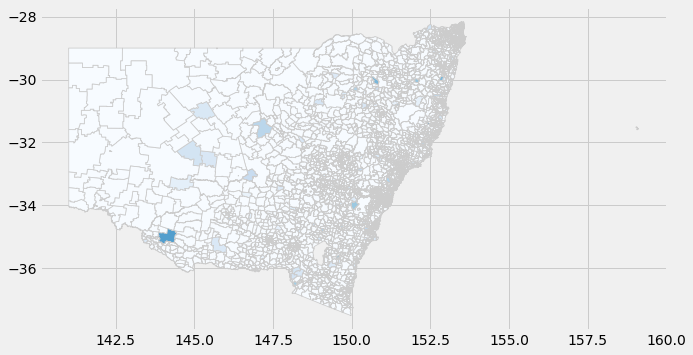

In [103]:
variable = "guests_included"
vmin, vmax = 0, 20
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

(140.0939567219233, 160.0107386088967, -37.9724793714895, -27.689617754120505)

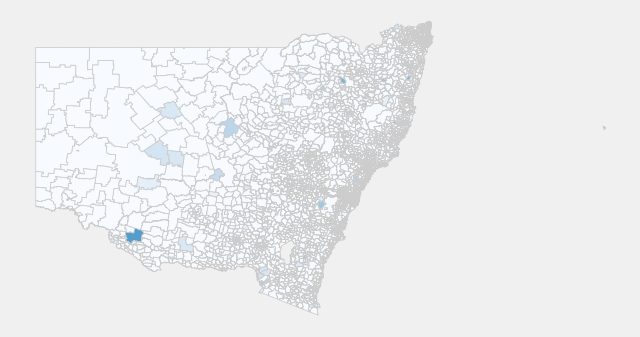

In [104]:
variable = "guests_included"
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")

Text(0.1, 0.08, 'Map of NSW')

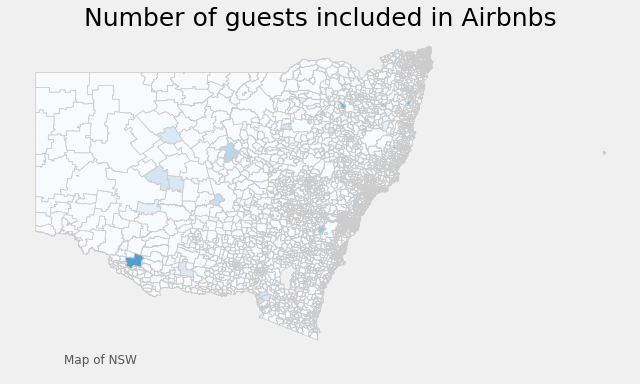

In [105]:
variable = "guests_included"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")
# add a title
ax.set_title("Number of guests included in Airbnbs", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Map of NSW", xy=(0.1, .08), xycoords="figure fraction", ha="left", va="top", fontsize=12, color="#555555")

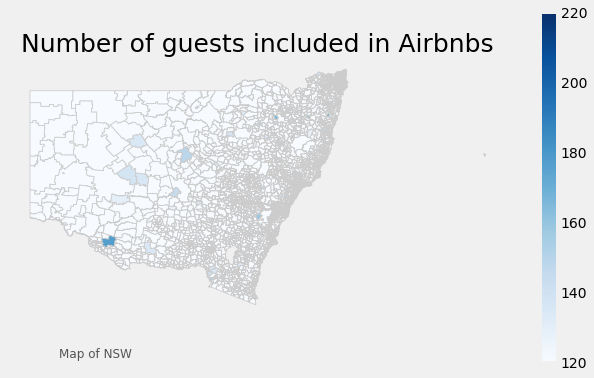

In [106]:
variable = "guests_included"
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")
ax.axis("off")
# add a title
ax.set_title("Number of guests included in Airbnbs", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Map of NSW", xy=(0.1, .08), xycoords="figure fraction", ha="left", va="top", fontsize=12, color="#555555")
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

In [107]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

POINT (151.7246099649729 -32.88497041458911)


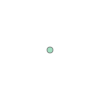

In [108]:
a = burbs.iloc[0]
print(a.centroid)
a.centroid

In [109]:
this_point = shapely.geometry.point.Point(144.3,-34.45)
burbs["distance_from_Maude"] = burbs.geometry.distance(this_point)

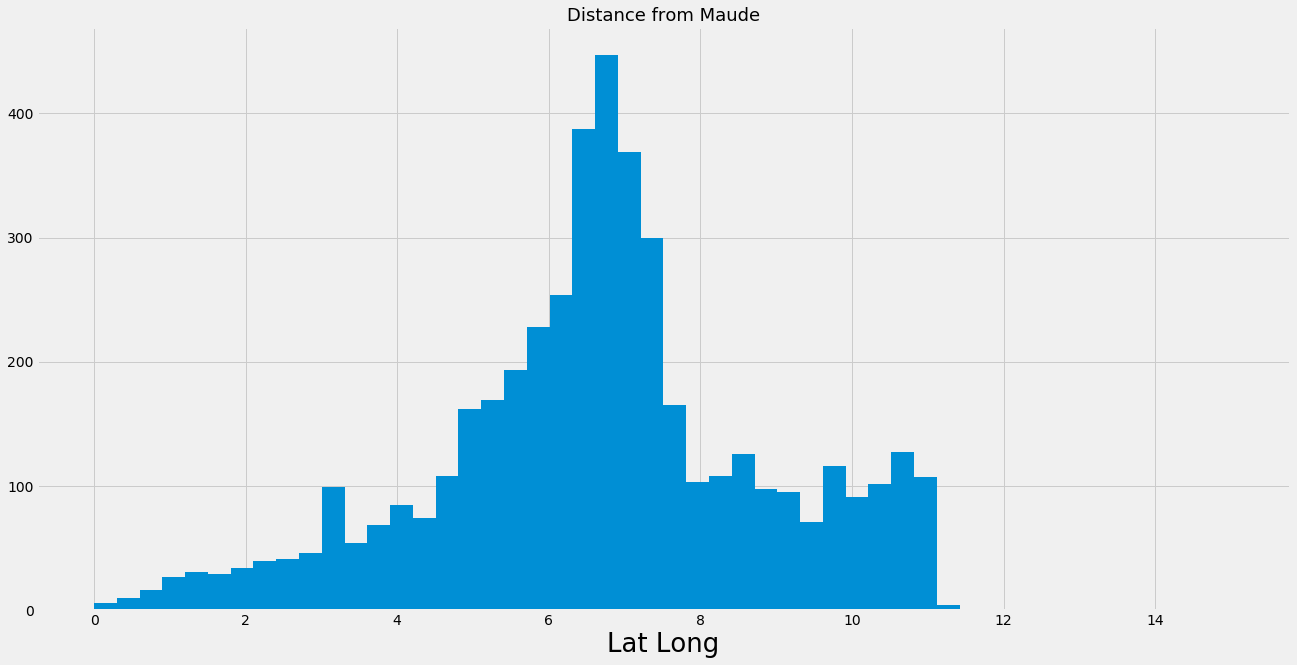

In [110]:
burbs.distance_from_Maude.hist(bins=50);
plt.title("Distance from Maude", fontsize=18)
plt.xlabel('Lat Long', fontsize=26)
plt.grid(True)
plt.show()

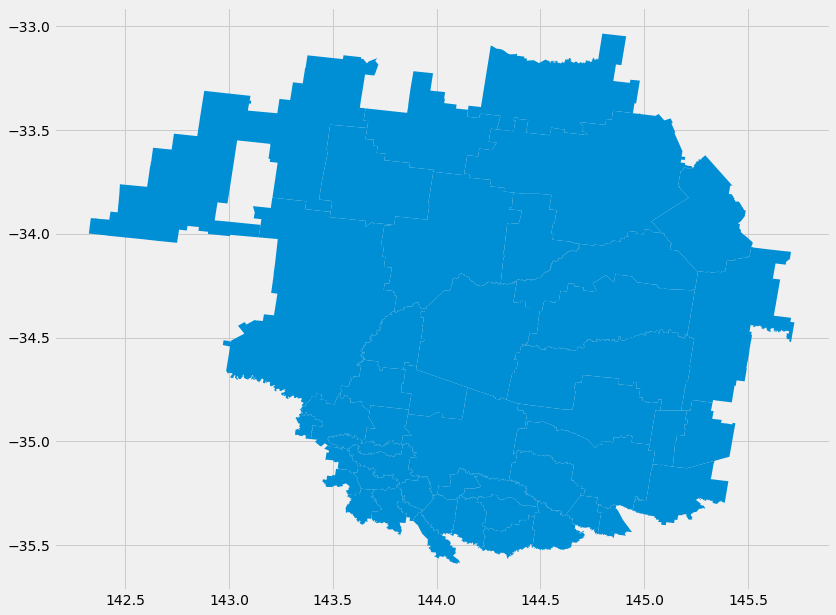

In [111]:
close_burbs = burbs[burbs.distance_from_Maude<1]
close_burbs.plot();

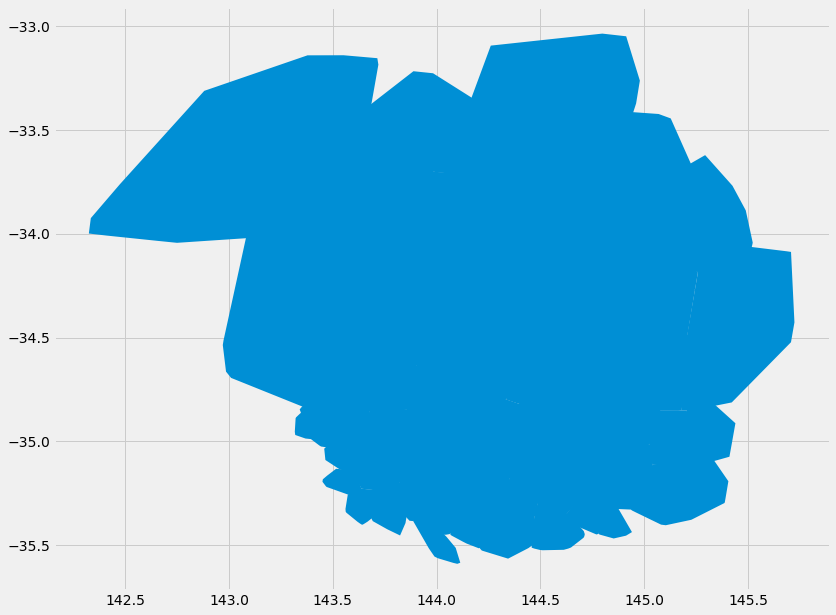

In [112]:
close_burbs.geometry.convex_hull.plot();

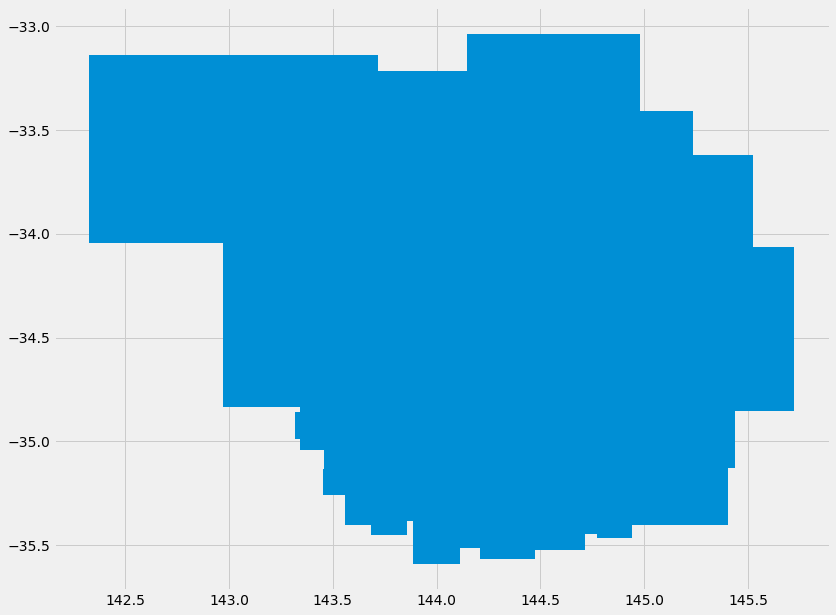

In [113]:
close_burbs.geometry.envelope.plot();

Text(0.5, 1, 'Suburbs near town with largest accomodation')

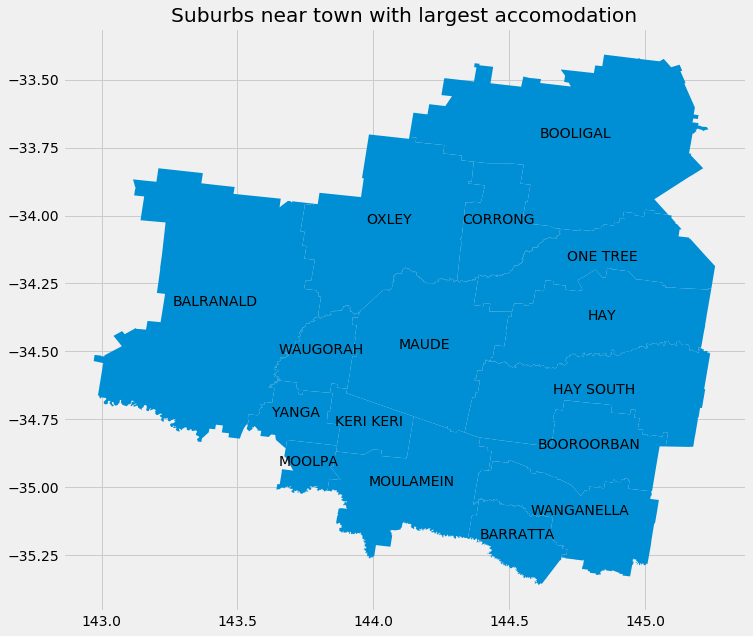

In [114]:
really_close_burbs = burbs[burbs.distance_from_Maude<0.6]
really_close_burbs.plot()

for idx, row in really_close_burbs.iterrows():
    plt.annotate(row.NSW_LOCA_2, xy=tuple(row.centroid.coords)[0], ha='center')
plt.title('Suburbs near town with largest accomodation')

In [115]:
print(this_point)
in_this_burb = None
for _, row in really_close_burbs.iterrows():
    if this_point.within(row.geometry):
        in_this_burb = row
        
in_this_burb

POINT (144.3 -34.45)


LC_PLY_PID                                                         17464
DT_CREATE                                                     2012-05-15
DT_RETIRE                                                           None
LOC_PID                                                             2546
NSW_LOCALI                                                    2012-07-27
NSW_LOCA_1                                                          None
NSW_LOCA_2                                                         MAUDE
NSW_LOCA_3                                                          None
NSW_LOCA_4                                                          None
NSW_LOCA_5                                                             G
NSW_LOCA_6                                                          None
NSW_LOCA_7                                                             1
geometry               POLYGON ((144.120085256053 -34.1924519579089, ...
centroid                    POINT (144.190039783909

In [116]:
in_this_burb = really_close_burbs[really_close_burbs.apply(lambda x: this_point.within(x.geometry) , axis=1)]
in_this_burb

LC_PLY_PID   DT_CREATE DT_RETIRE LOC_PID  NSW_LOCALI NSW_LOCA_1  \
559      17464  2012-05-15      None    2546  2012-07-27       None   

    NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
559      MAUDE       None       None          G       None          1   

                                              geometry  \
559  POLYGON ((144.120085256053 -34.1924519579089, ...   

                                         centroid  distance_from_Maude  
559  POINT (144.1900397839091 -34.48988714293753)                  0.0

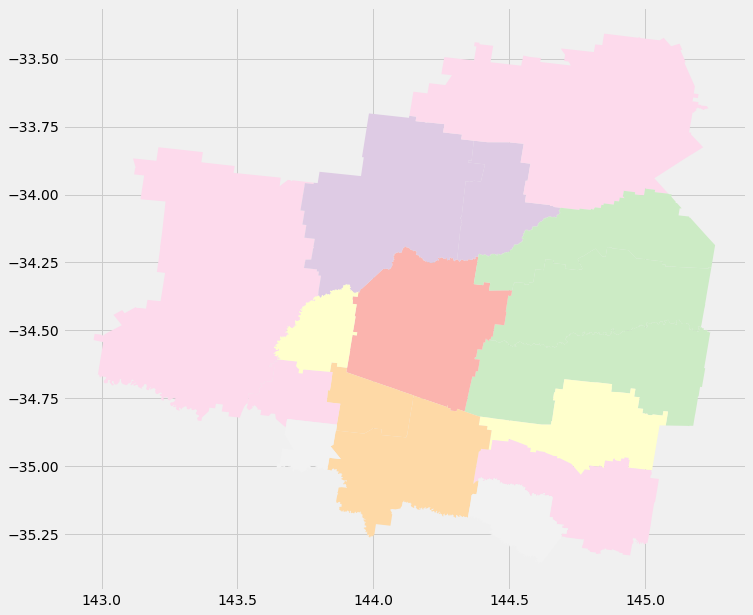

In [117]:
really_close_burbs.plot(column='distance_from_Maude', cmap='Pastel1');

# END OF PRESENTATION
> In conclusion, the Airbnb Dataset was an interesting dataset to analyse because of the diversity of information it provides. It informed me that it was cheaper to hire airbnbs with chinese characters in the description, go to Marrickville or Bondi for a Futon bed and much more. 